In [1]:
import pandas as pd
import numpy as np

import os
import sys
from sys import argv
import pickle
import random
import joblib

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statistics
import scipy
import math

import warnings
import itertools
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, f1_score, mean_absolute_percentage_error, r2_score
from scikit_posthocs import posthoc_nemenyi_friedman, posthoc_conover_friedman

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# path to project folder
# please change to your own
PATH = os.getcwd()

color_palette = ["#000","#778899"]

palette = sns.color_palette(color_palette)
#sns.set_palette(palette)

bright_palette = sns.diverging_palette(145, 300, s=60, as_cmap=True)
bright_colours = sns.diverging_palette(145, 300, s=60)
sns.set_palette(bright_colours)

# White Box Fidelity

In [22]:
datasets = ["breast_cancer", "compas", "diabetes", "income", "iris", "mushroom", "nursery"]
models = ["decision_tree", "logit", "nb"]
cls_xai = ["LIME", "SHAP", "LINDA", "ACV"]

data_names = {"breast_cancer":"Breast Cancer", "compas": "COMPAS", "diabetes":"Diabetes", "income": "Adult Income",
              "iris": "Iris", "mushroom": "Mushroom", "nursery": "Nursery"}

orig_data = pd.DataFrame()
cls_results = pd.DataFrame()

for data in datasets:
    for model in models:
        results = pd.read_csv(os.path.join(PATH, data, model, "results.csv"), sep = ";")
        
        accuracy = accuracy_score(results["Actual"], results["Prediction"])
        f1 = f1_score(results["Actual"], results["Prediction"])
        
        results["Model Accuracy"] = [accuracy]*results.shape[0]
        results["F1 Score"] = [f1]*results.shape[0]
        
        results["Model"] = [model]*results.shape[0]
        results["Dataset"] = [data_names[data]]*results.shape[0]
        results["Dataset Type"] = ["Classification"]*results.shape[0]
        
        orig_data = orig_data.append(results)
        cls_results = cls_results.append(results)

In [23]:
datasets = ["bike_sharing", "facebook", "housing", "real_estate", "solar_flare", "student_scores", "wine_quality"]
models = ["decision_tree", "lin_reg"]
reg_xai = ["LIME", "SHAP", "ACV"]

data_names = {"bike_sharing":"Bike Rentals", "facebook": "Facebook", "housing":"Housing", "real_estate": "Real Estate",
              "solar_flare": "Solar Flare", "student_scores": "Student Results", "wine_quality": "Wine Quality"}

reg_results = pd.DataFrame()

for data in datasets:
    for model in models:
        results = pd.read_csv(os.path.join(PATH, data, model, "results.csv"), sep = ";")
        
        mape = mean_absolute_percentage_error(results["Actual"], results["Prediction"])
        rsquared = r2_score(results["Actual"], results["Prediction"])
        
        results["MAPE"] = [mape]*results.shape[0]
        results["R-Squared"] = [rsquared]*results.shape[0]
        
        results["Model"] = [model]*results.shape[0]
        results["Dataset"] = [data_names[data]]*results.shape[0]
        results["Dataset Type"] = ["Regression"]*results.shape[0]
        
        orig_data = orig_data.append(results)
        reg_results = reg_results.append(results)

In [24]:
#all_data = orig_data.drop(["LINDA Precision", "LINDA Recall"], axis = 1)
#cls_results = cls_results.drop(["LINDA Precision", "LINDA Recall"], axis = 1)

#all_data = all_data.dropna(0)

def prediction_type(row):
    if row['Dataset Type'] == "Classification":
        if row['Actual'] == 0 and row['Prediction'] == 0:
            return "True Negative"
        elif row['Actual'] == 0 and row['Prediction'] == 1:
            return "False Positive"
        elif row['Actual'] == 1 and row['Prediction'] == 0:
            return "False Negative"
        elif row['Actual'] == 1 and row['Prediction'] == 1:
            return "True Positive"
    else:
        return None
    
def pred_type_num(row):
    return row["Prediction"]-row["Actual"]

orig_data["Prediction Type"] = orig_data.apply(lambda row: prediction_type(row), axis = 1)
orig_data["Prediction Type Numeric"] = orig_data.apply(lambda row: pred_type_num(row), axis = 1)

cls_results["Prediction Type"] = cls_results.apply(lambda row: prediction_type(row), axis = 1)
cls_results["Prediction Type Numeric"] = cls_results.apply(lambda row: pred_type_num(row), axis = 1)

reg_results["Prediction Type Numeric"] = reg_results.apply(lambda row: pred_type_num(row), axis = 1)

#reg_results = reg_results.drop(["ACV Precision", "ACV Recall"], axis=1)
#orig_data = orig_data.drop(["ACV Precision", "ACV Recall"], axis=1)
#cls_results.reset_index(inplace=True)
#reg_results.reset_index(inplace=True)
#orig_data.reset_index(inplace=True)

#all_data

In [25]:
print(cls_results.shape)
print(reg_results.shape)

(1878, 18)
(1400, 14)


In [7]:
cls_order = [ "Model Accuracy","LIME Precision", "LIME Recall", "SHAP Precision", "SHAP Recall", 
             "LINDA Precision", "LINDA Recall","ACV Precision", "ACV Recall"]
cls_results.groupby(["Model", "Dataset"]).mean()[cls_order].round(4)

Model Accuracy  LIME Precision  LIME Recall  \
Model         Dataset                                                      
decision_tree Adult Income             0.81          0.9500       0.1536   
              Breast Cancer            0.87          1.0000       0.4325   
              COMPAS                   0.78          0.9608       0.3135   
              Diabetes                 0.68          0.8900       0.3567   
              Iris                     1.00          1.0000       1.0000   
              Mushroom                 1.00          0.7178       0.5704   
              Nursery                  1.00          1.0000       1.0000   
logit         Adult Income             0.86          0.9950       1.0000   
              Breast Cancer            0.97          0.9593       0.2425   
              COMPAS                   0.74          0.8350       0.6100   
              Diabetes                 0.74          0.5425       0.6200   
              Iris                     1.00          0.9808       0.7692   
              Mushroom                 1.00          1.0000       0.5000   
              Nursery                  1.00          1.0000       1.0000   
nb            Adult Income             0.78          0.8893       0.0348   
              Breast Cancer            0.97          0.2709       0.1725   
              COMPAS                   0.69          0.7373       0.4481   
              Diabetes                 0.70          0.3083       0.1213   
              Iris                     1.00          0.7692       0.5577   
              Mushroom                 0.99          0.7671       0.2256   
              Nursery                  1.00          1.0000       0.6667   

                             SHAP Precision  SHAP Recall  LINDA Precision  \
Model         Dataset                                                       
decision_tree Adult Income           0.9267       0.2145           0.4788   
              Breast Cancer          1.0000       0.4425           0.0996   
              COMPAS                 1.0000       0.3126           0.3313   
              Diabetes               1.0000       0.4667           0.5027   
              Iris                   1.0000       1.0000           0.2340   
              Mushroom               0.8650       0.3479           0.0464   
              Nursery                1.0000       1.0000           0.0370   
logit         Adult Income           0.2767       0.3800           0.0044   
              Breast Cancer          0.9240       0.2475           0.4273   
              COMPAS                 0.8733       0.6250           0.0240   
              Diabetes               0.4683       0.5800           0.2683   
              Iris                   0.9359       0.8462           0.4808   
              Mushroom               0.5553       0.4250           0.0171   
              Nursery                1.0000       1.0000           0.0370   
nb            Adult Income           0.3992       0.0057           0.8528   
              Breast Cancer          0.2600       0.1311           0.3222   
              COMPAS                 0.0262       0.0200           0.2125   
              Diabetes               0.2050       0.0984           0.4455   
              Iris                   0.7500       0.6154           0.5096   
              Mushroom               0.1583       0.0054           0.5532   
              Nursery                1.0000       0.6667           0.0741   

                             LINDA Recall  ACV Precision  ACV Recall  
Model         Dataset                                                 
decision_tree Adult Income         0.4208         0.7378      0.2117  
              Breast Cancer        0.5325         0.3238      0.4700  
              COMPAS               0.1145         0.9247      0.4041  
              Diabetes             0.4700         0.6942      0.4433  
              Iris                 0.8846         0.5000      1.0000  
           

In [42]:
cls_f1 = cls_results
def f1_calc(prec, rec):
    #print(prec)
    #print(rec)
    if prec == 0 and rec == 0:
        return 0
    f1 = 2*(prec*rec)/(prec+rec)
    return f1
cls_f1["SHAP F1"] = cls_f1.apply(lambda x: f1_calc(x["SHAP Precision"], x["SHAP Recall"]), axis=1) #f1_calc(cls_f1["SHAP Precision"].values, cls_f1["SHAP Recall"].values)
cls_f1["LIME F1"] = cls_f1.apply(lambda x: f1_calc(x["LIME Precision"], x["LIME Recall"]), axis=1) #f1_calc(cls_f1["SHAP Precision"].values, cls_f1["SHAP Recall"].values)
cls_f1["LINDA F1"] = cls_f1.apply(lambda x: f1_calc(x["LINDA Precision"], x["LINDA Recall"]), axis=1) #f1_calc(cls_f1["SHAP Precision"].values, cls_f1["SHAP Recall"].values)
cls_f1["ACV F1"] = cls_f1.apply(lambda x: f1_calc(x["ACV Precision"], x["ACV Recall"]), axis=1) #f1_calc(cls_f1["SHAP Precision"].values, cls_f1["SHAP Recall"].values)
print(cls_f1[cls_f1.isnull().any(axis=1)])

cls_f1.groupby(["Model", "Dataset"]).mean()[["LIME F1", "SHAP F1", "LINDA F1", "ACV F1"]].round(4)

Empty DataFrame
Columns: [Actual, Prediction, Prediction Probability, SHAP Precision, SHAP Recall, LIME Precision, LIME Recall, LINDA Precision, LINDA Recall, ACV Precision, ACV Recall, Model Accuracy, F1 Score, Model, Dataset, Dataset Type, Prediction Type, Prediction Type Numeric, SHAP F1, LIME F1, LINDA F1, ACV F1]
Index: []

[0 rows x 22 columns]


LIME F1  SHAP F1  LINDA F1  ACV F1
Model         Dataset                                          
decision_tree Adult Income    0.2594   0.3326    0.1664  0.3162
              Breast Cancer   0.5973   0.6080    0.1375  0.3681
              COMPAS          0.4508   0.4566    0.1321  0.5335
              Diabetes        0.4817   0.6127    0.3982  0.5303
              Iris            1.0000   1.0000    0.3692  0.6667
              Mushroom        0.5445   0.3729    0.0874  0.1605
              Nursery         1.0000   1.0000    0.0714  0.3447
logit         Adult Income    0.9967   0.3060    0.0088  0.1027
              Breast Cancer   0.3767   0.3749    0.3564  0.3007
              COMPAS          0.6850   0.7033    0.0436  0.6020
              Diabetes        0.5637   0.5013    0.3212  0.5850
              Iris            0.8397   0.8692    0.6410  1.0000
              Mushroom        0.6667   0.4421    0.0336  0.3069
              Nursery         1.0000   1.0000    0.0714  0.3442
nb            Adult Income    0.0669   0.0112    0.8188  0.0233
              Breast Cancer   0.1639   0.1430    0.3631  0.0687
              COMPAS          0.5409   0.0221    0.2357  0.0856
              Diabetes        0.1580   0.1242    0.3573  0.2974
              Iris            0.6077   0.6551    0.6454  0.7038
              Mushroom        0.3432   0.0103    0.6749  0.0342
              Nursery         0.7500   0.7500    0.1357  0.5370

('decision_tree', 'Adult Income')
XAI Method     object
F1-score      float64
dtype: object


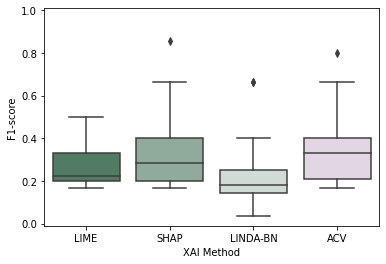

('decision_tree', 'Breast Cancer')
XAI Method     object
F1-score      float64
dtype: object


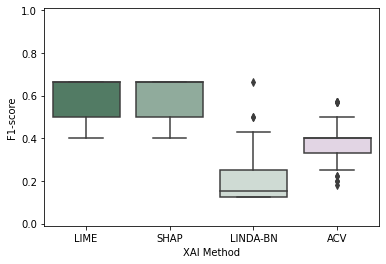

('decision_tree', 'COMPAS')
XAI Method     object
F1-score      float64
dtype: object


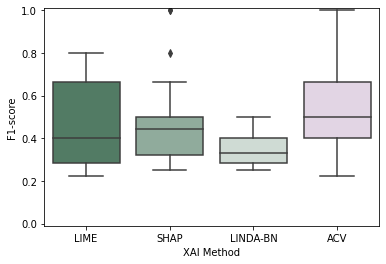

('decision_tree', 'Diabetes')
XAI Method     object
F1-score      float64
dtype: object


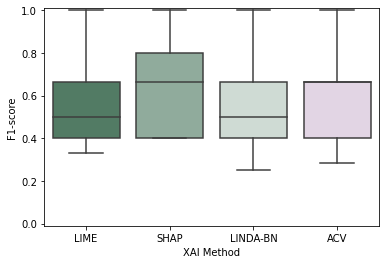

('decision_tree', 'Iris')
XAI Method     object
F1-score      float64
dtype: object


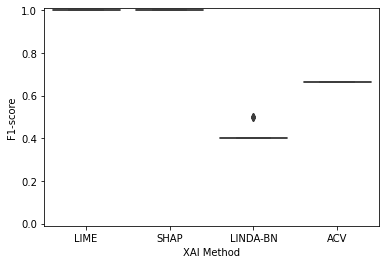

('decision_tree', 'Mushroom')
XAI Method     object
F1-score      float64
dtype: object


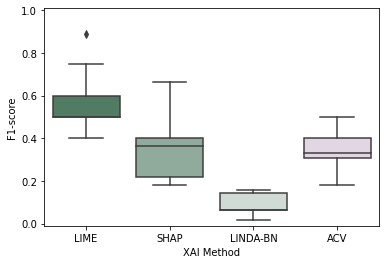

('decision_tree', 'Nursery')
XAI Method     object
F1-score      float64
dtype: object


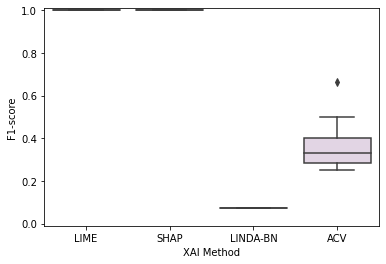

('logit', 'Adult Income')
XAI Method     object
F1-score      float64
dtype: object


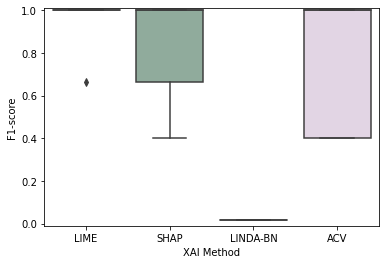

('logit', 'Breast Cancer')
XAI Method     object
F1-score      float64
dtype: object


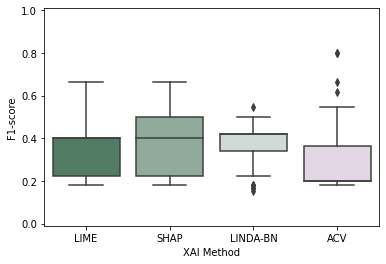

('logit', 'COMPAS')
XAI Method     object
F1-score      float64
dtype: object


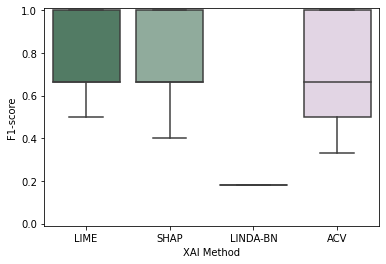

('logit', 'Diabetes')
XAI Method     object
F1-score      float64
dtype: object


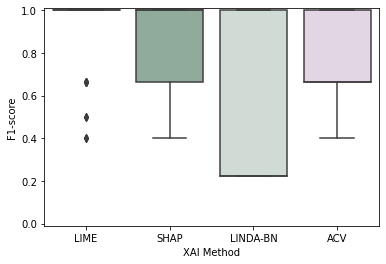

('logit', 'Iris')
XAI Method     object
F1-score      float64
dtype: object


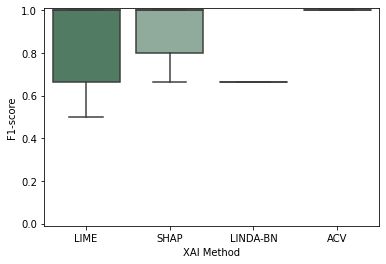

('logit', 'Mushroom')
XAI Method     object
F1-score      float64
dtype: object


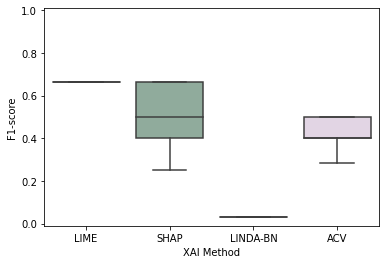

('logit', 'Nursery')
XAI Method     object
F1-score      float64
dtype: object


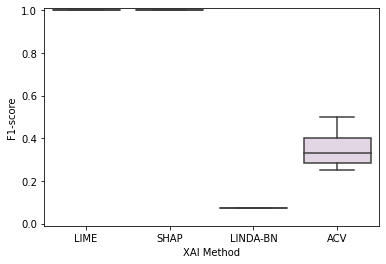

('nb', 'Adult Income')
XAI Method     object
F1-score      float64
dtype: object


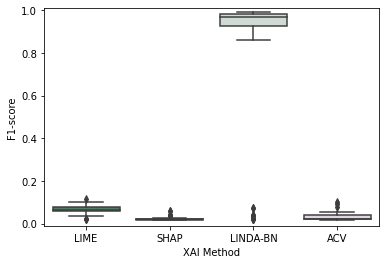

('nb', 'Breast Cancer')
XAI Method     object
F1-score      float64
dtype: object


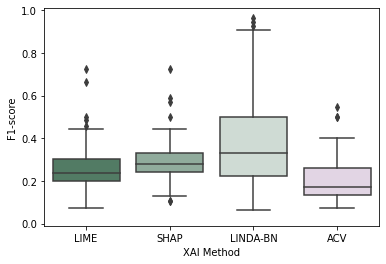

('nb', 'COMPAS')
XAI Method     object
F1-score      float64
dtype: object


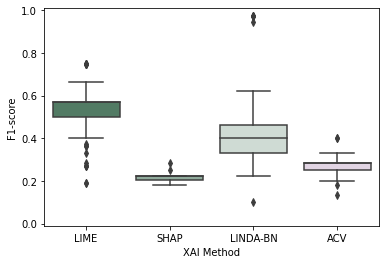

('nb', 'Diabetes')
XAI Method     object
F1-score      float64
dtype: object


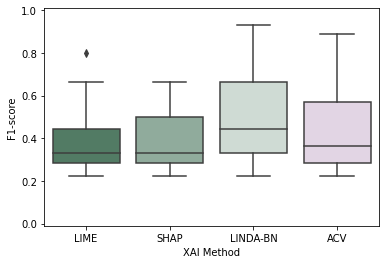

('nb', 'Iris')
XAI Method     object
F1-score      float64
dtype: object


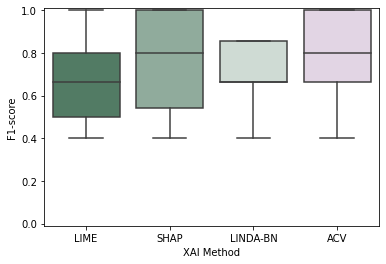

('nb', 'Mushroom')
XAI Method     object
F1-score      float64
dtype: object


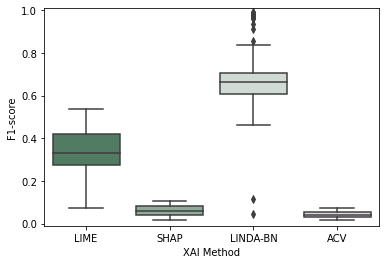

('nb', 'Nursery')
XAI Method     object
F1-score      float64
dtype: object


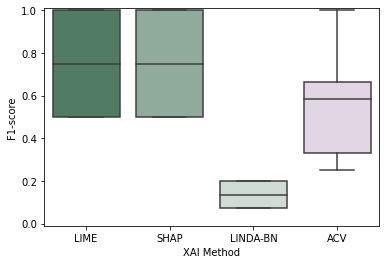

In [9]:
for index,group in cls_f1.groupby(["Model", "Dataset"]):
    print(index)
    
    group = group[["LIME F1", "SHAP F1", "LINDA F1", "ACV F1"]]
    group.columns = ["LIME", "SHAP", "LINDA-BN", "ACV"]
    melted_group = group.melt(var_name = "XAI Method", value_name = "F1-score")
    
    print(melted_group.dtypes)
    
    sns.boxplot(data = melted_group, x = "XAI Method", y = "F1-score")
    plt.ylim(-0.01,1.01)
    plt.show()

In [10]:
group.columns

Index(['LIME', 'SHAP', 'LINDA-BN', 'ACV'], dtype='object')

In [11]:
reg_order = [ "R-Squared","LIME Precision", "LIME Recall", "SHAP Precision", "SHAP Recall", "ACV Precision", "ACV Recall"]
pd.options.display.float_format = '{:.4f}'.format
reg_results.groupby(["Model", "Dataset"]).mean()[reg_order].round(4)

R-Squared  LIME Precision  \
Model         Dataset                                                     
decision_tree Bike Rentals                       0.8082          0.7551   
              Facebook                           0.4642          0.9050   
              Housing                            0.5764          0.8155   
              Real Estate                        0.6193          0.9900   
              Solar Flare                        0.1977          0.8900   
              Student Results                    0.7404          0.9400   
              Wine Quality                       0.0908          0.9967   
lin_reg       Bike Rentals                       0.7360          1.0000   
              Facebook        -9159531546076018688.0000          1.0000   
              Housing                            0.7643          0.7902   
              Real Estate                        0.4021          0.4333   
              Solar Flare                        0.0065          1.0000   
              Student Results                    0.8893          1.0000   
              Wine Quality                       0.3149          0.3058   

                               LIME Recall  SHAP Precision  SHAP Recall  \
Model         Dataset                                                     
decision_tree Bike Rentals          0.2768          0.9900       0.0827   
              Facebook              0.2468          0.9250       0.2010   
              Housing               0.1386          1.0000       0.2076   
              Real Estate           0.3683          1.0000       0.3600   
              Solar Flare           0.1618          0.9600       0.2778   
              Student Results       0.5588          1.0000       0.5722   
              Wine Quality          0.4133          1.0000       0.3530   
lin_reg       Bike Rentals          0.8750          0.6525       0.2250   
              Facebook              1.0000          1.0000       0.3333   
              Housing               0.3733          0.7190       0.3500   
              Real Estate           0.6700          0.3217       0.4200   
              Solar Flare           1.0000          0.1600       0.1600   
              Student Results       1.0000          0.0800       0.0800   
              Wine Quality          0.5600          0.3300       0.5700   

                               ACV Precision  ACV Recall  
Model         Dataset                                     
decision_tree Bike Rentals            0.7013      0.2605  
              Facebook                0.6968      0.4971  
              Housing                 0.7505      0.3067  
              Real Estate             0.7833      0.6343  
              Solar Flare             0.0000      0.0000  
              Student Results         0.9320      0.5422  
              Wine Quality            0.3400      0.0957  
lin_reg       Bike Rentals            0.0788      0.0638  
              Facebook                0.0826      0.2233  
              Housing                 0.4692      0.4800  
              Real Estate             0.1667      0.4500  
              Solar Flare             0.0000      0.0000  
              Student Results         0.0000      0.0000  
              Wine Quality            0.0500      0.0500

In [43]:
reg_f1 = reg_results

reg_f1["SHAP F1"] = reg_f1.apply(lambda x: f1_calc(x["SHAP Precision"], x["SHAP Recall"]), axis=1) #f1_calc(cls_f1["SHAP Precision"].values, cls_f1["SHAP Recall"].values)
reg_f1["LIME F1"] = reg_f1.apply(lambda x: f1_calc(x["LIME Precision"], x["LIME Recall"]), axis=1) #f1_calc(cls_f1["SHAP Precision"].values, cls_f1["SHAP Recall"].values)
reg_f1["ACV F1"] = reg_f1.apply(lambda x: f1_calc(x["ACV Precision"], x["ACV Recall"]), axis=1) #f1_calc(cls_f1["SHAP Precision"].values, cls_f1["SHAP Recall"].values)

reg_f1.groupby(["Model", "Dataset"]).mean()[["SHAP F1", "LIME F1", "ACV F1"]].round(4)

SHAP F1  LIME F1  ACV F1
Model         Dataset                                  
decision_tree Bike Rentals      0.1493   0.3890  0.3664
              Facebook          0.3103   0.3635  0.5327
              Housing           0.3305   0.2278  0.4128
              Real Estate       0.5088   0.5122  0.6785
              Solar Flare       0.4090   0.2730  0.0000
              Student Results   0.6706   0.6459  0.6281
              Wine Quality      0.5100   0.5641  0.1473
lin_reg       Bike Rentals      0.3270   0.9333  0.0698
              Facebook          0.5000   1.0000  0.1196
              Housing           0.4490   0.4727  0.4540
              Real Estate       0.3533   0.4977  0.2417
              Solar Flare       0.1600   1.0000  0.0000
              Student Results   0.0800   1.0000  0.0000
              Wine Quality      0.4050   0.3857  0.0500

Adult Income


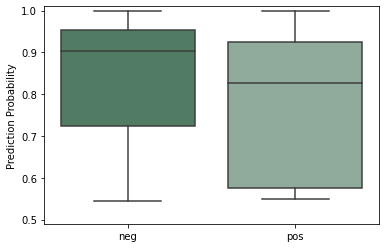

Breast Cancer


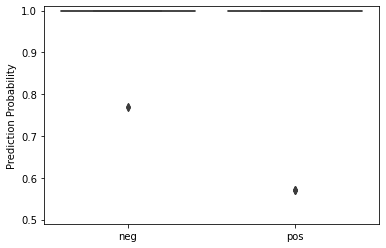

COMPAS


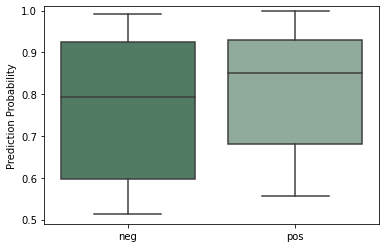

Diabetes


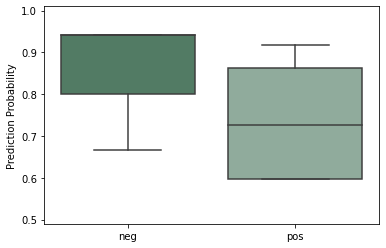

Iris


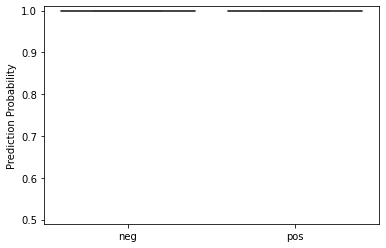

Mushroom


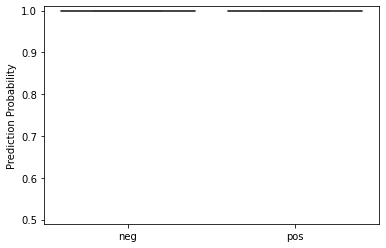

Nursery


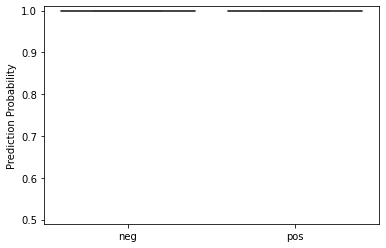

In [13]:
dt_results = cls_results[cls_results["Model"] == "decision_tree"]
dt_groups = dt_results.groupby("Dataset")
for index,group in dt_groups:
    print(index)
    probas = group["Prediction Probability"]
    preds = group["Prediction"].map({0: "neg", 1: "pos"}).values #["neg" for i in group["Prediction"] if (group["Prediction"][i] == 0) else "pos"]
    sns.boxplot(preds, probas)
    plt.ylim(0.49, 1.01)
    plt.show()

In [14]:
dt_results.groupby(["Dataset", "Prediction"])["Prediction Probability", "LINDA Precision", "LINDA Recall", 
                                              "ACV Precision", "ACV Recall"].median()

Prediction Probability  LINDA Precision  \
Dataset       Prediction                                            
Adult Income  0                           0.9038           1.0000   
              1                           0.8270           0.0769   
Breast Cancer 0                           1.0000           0.0000   
              1                           1.0000           0.0667   
COMPAS        0                           0.7935           0.0000   
              1                           0.8500           0.0000   
Diabetes      0                           0.9412           0.5000   
              1                           0.7273           0.2917   
Iris          0                           1.0000           0.2500   
              1                           1.0000           0.2500   
Mushroom      0                           1.0000           0.0769   
              1                           1.0000           0.0342   
Nursery       0                           1.0000           0.0370   
              1                           1.0000           0.0370   

                          LINDA Recall  ACV Precision  ACV Recall  
Dataset       Prediction                                           
Adult Income  0                 0.1111         1.0000      0.2000  
              1                 1.0000         0.6667      0.2111  
Breast Cancer 0                 0.0000         0.3333      0.5000  
              1                 1.0000         0.3333      0.5000  
COMPAS        0                 0.0000         1.0000      0.2917  
              1                 0.0000         1.0000      0.3333  
Diabetes      0                 0.3333         0.7083      0.5000  
              1                 0.5000         1.0000      0.5000  
Iris          0                 1.0000         0.5000      1.0000  
              1                 1.0000         0.5000      1.0000  
Mushroom      0                 1.0000         0.6667      0.2222  
              1                 1.0000         0.0000      0.0000  
Nursery       0                 1.0000         0.1667      1.0000  
              1                 1.0000         0.2000      1.0000

Adult Income


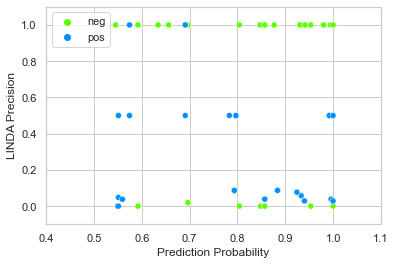

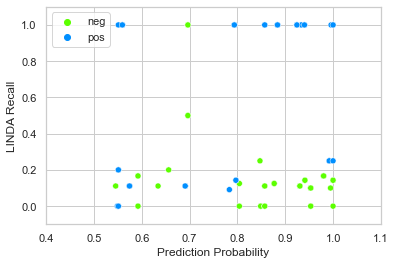

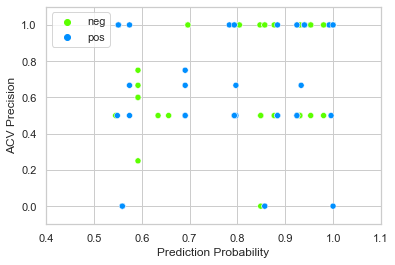

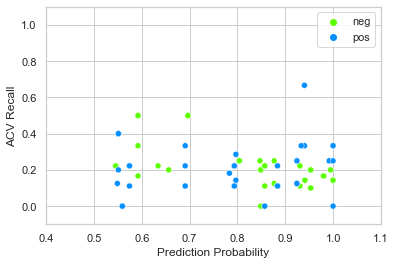

Breast Cancer


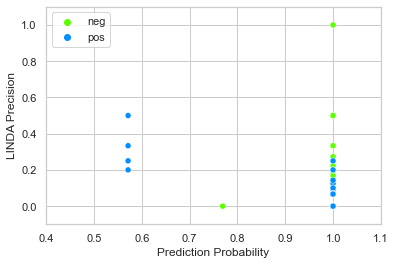

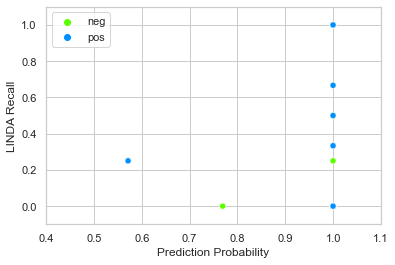

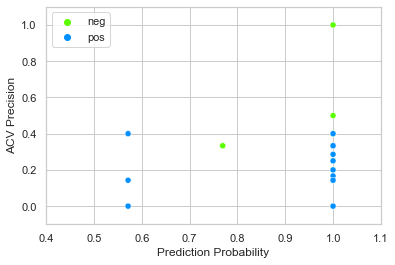

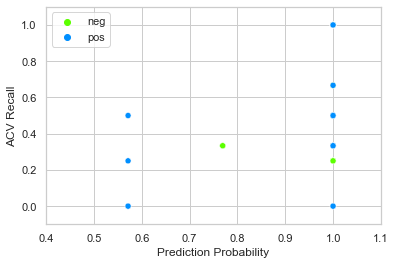

COMPAS


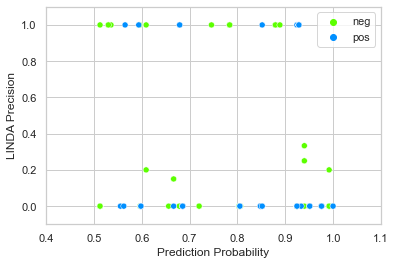

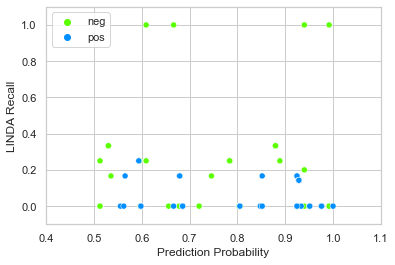

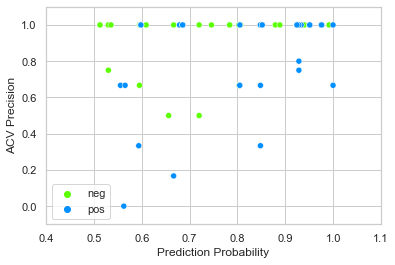

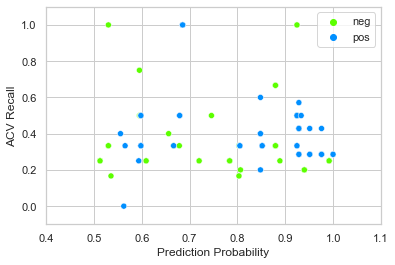

Diabetes


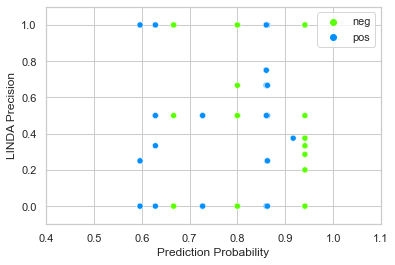

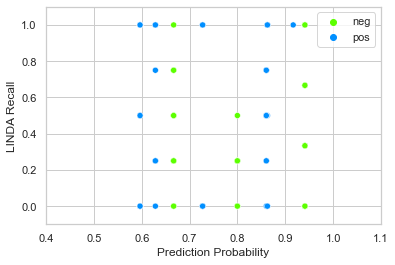

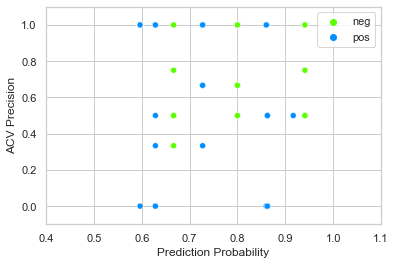

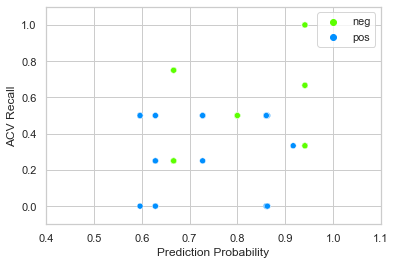

Iris


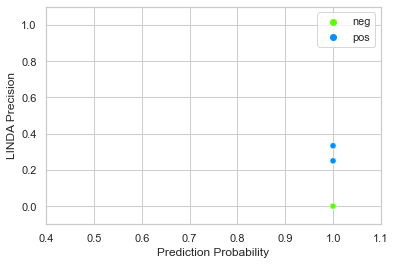

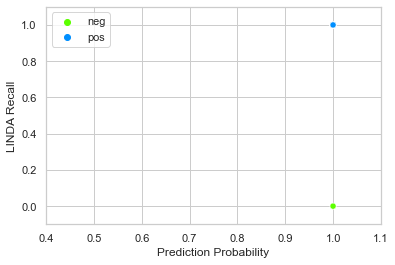

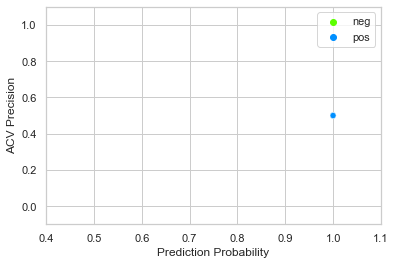

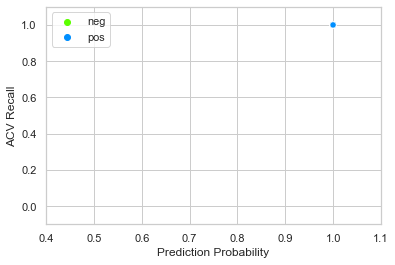

Mushroom


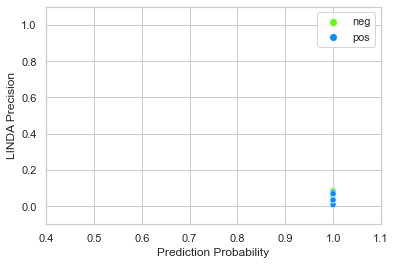

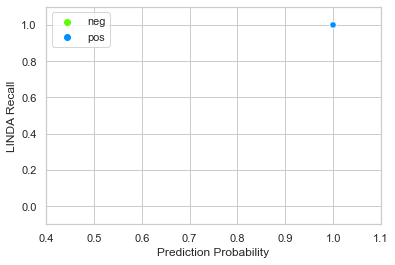

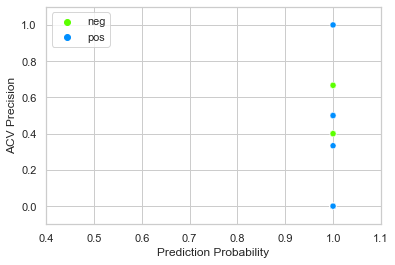

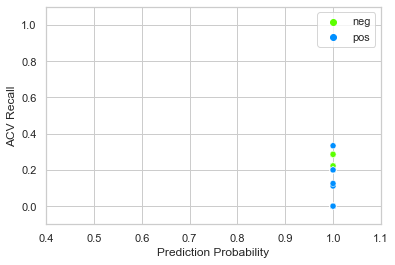

Nursery


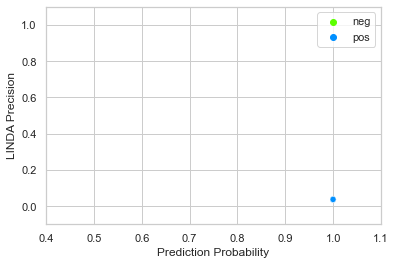

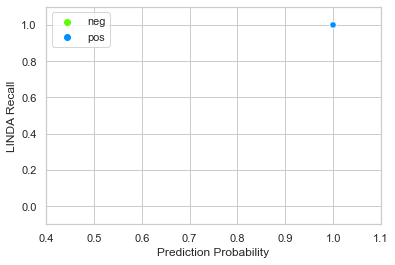

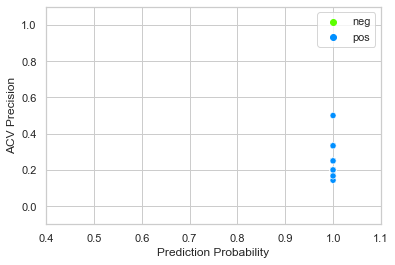

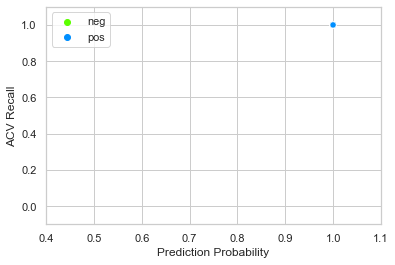

In [78]:
for index,group in dt_groups:
    print(index)
    probas = group["Prediction Probability"]
    preds = group["Prediction"].map({0: "neg", 1: "pos"}).values #["neg" for i in group["Prediction"] if (group["Prediction"][i] == 0) else "pos"]

    shap_prec = group["LINDA Precision"]
    shap_rec = group["LINDA Recall"]
    
    lime_prec = group["ACV Precision"]
    lime_rec = group["ACV Recall"]
    
    sns.scatterplot(probas, shap_prec, hue = preds, palette = "gist_rainbow")
    plt.xlim(0.4, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()
    
    sns.scatterplot(probas, shap_rec, hue = preds, palette = "gist_rainbow")
    plt.xlim(0.4, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()
    
    sns.scatterplot(probas, lime_prec, hue = preds, palette = "gist_rainbow")
    plt.xlim(0.4, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()
    
    sns.scatterplot(probas, lime_rec, hue = preds, palette = "gist_rainbow")
    plt.xlim(0.4, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()

Adult Income


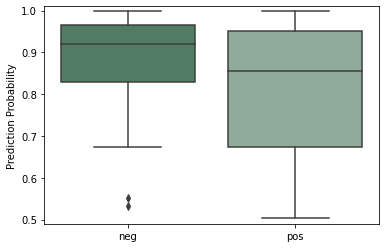

Breast Cancer


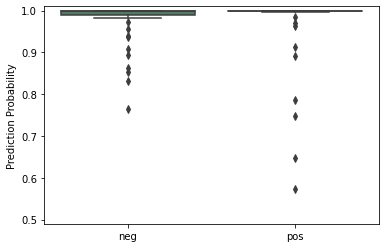

COMPAS


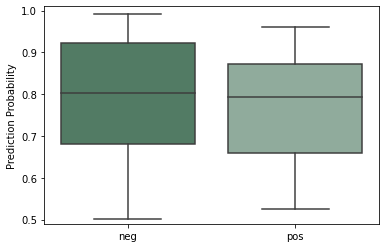

Diabetes


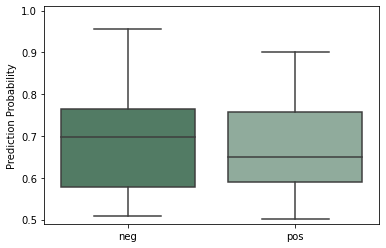

Iris


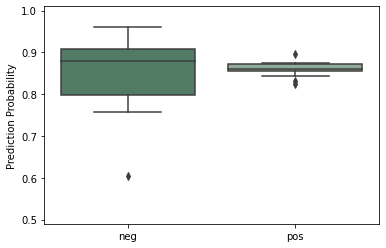

Mushroom


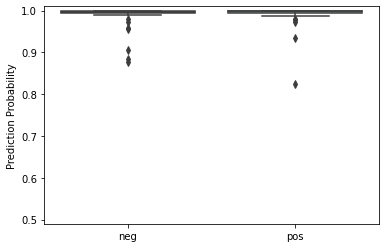

Nursery


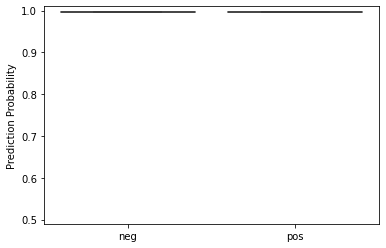

In [15]:
logit_results = cls_results[cls_results["Model"] == "logit"]
logit_groups = logit_results.groupby("Dataset")
for index,group in logit_groups:
    print(index)
    probas = group["Prediction Probability"]
    preds = group["Prediction"].map({0: "neg", 1: "pos"}).values #["neg" for i in group["Prediction"] if (group["Prediction"][i] == 0) else "pos"]
    sns.boxplot(preds, probas)
    plt.ylim(0.49, 1.01)
    plt.show()

In [81]:
logit_results.groupby(["Dataset", "Prediction"])["Prediction Probability", "LINDA Precision", "LINDA Recall", 
                                                 "ACV Precision", "ACV Recall"].median()

Prediction Probability  LINDA Precision  \
Dataset       Prediction                                            
Adult Income  0                           0.9208           0.0000   
              1                           0.8549           0.0096   
Breast Cancer 0                           0.9985           0.5000   
              1                           0.9999           0.2667   
COMPAS        0                           0.8026           0.0000   
              1                           0.7942           0.0000   
Diabetes      0                           0.6985           0.1250   
              1                           0.6486           0.1250   
Iris          0                           0.8801           0.5000   
              1                           0.8610           0.5000   
Mushroom      0                           0.9976           0.0171   
              1                           0.9985           0.0171   
Nursery       0                           0.9974           0.0370   
              1                           0.9973           0.0370   

                          LINDA Recall  ACV Precision  ACV Recall  
Dataset       Prediction                                           
Adult Income  0                 0.0000         0.0000      0.0000  
              1                 1.0000         0.0000      0.0000  
Breast Cancer 0                 0.2500         0.5000      0.1250  
              1                 1.0000         0.5000      0.1250  
COMPAS        0                 0.0000         0.6667      0.5000  
              1                 0.0000         0.5000      0.5000  
Diabetes      0                 1.0000         0.5000      1.0000  
              1                 1.0000         0.5000      1.0000  
Iris          0                 1.0000         1.0000      1.0000  
              1                 1.0000         1.0000      1.0000  
Mushroom      0                 1.0000         0.3333      0.5000  
              1                 1.0000         0.3333      0.5000  
Nursery       0                 1.0000         0.2000      1.0000  
              1                 1.0000         0.2000      1.0000

Adult Income


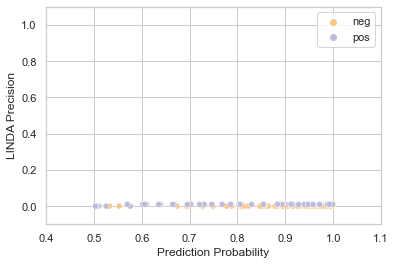

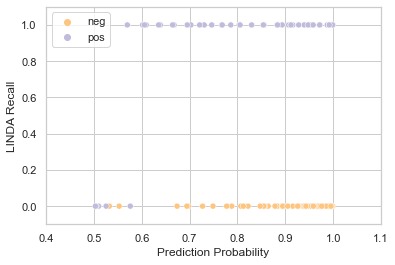

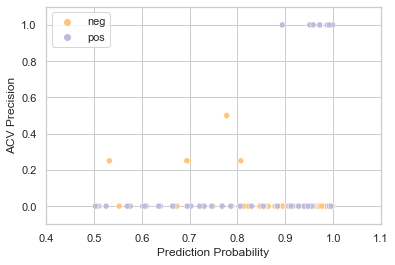

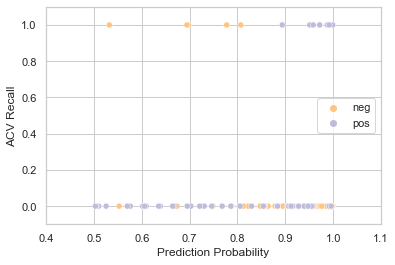

Breast Cancer


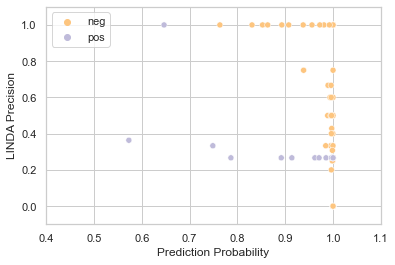

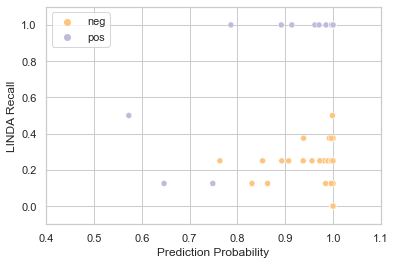

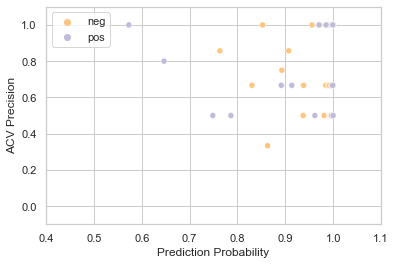

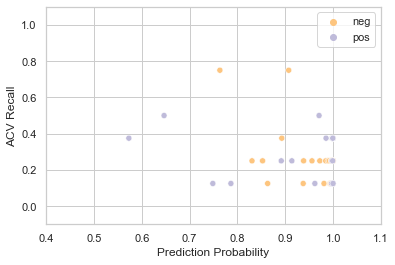

COMPAS


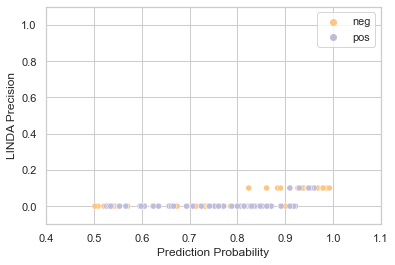

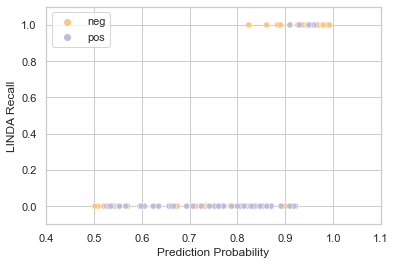

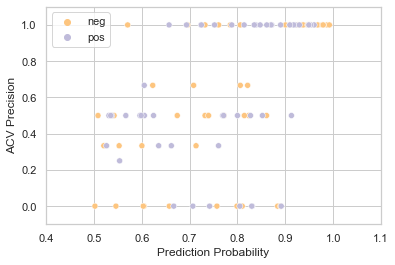

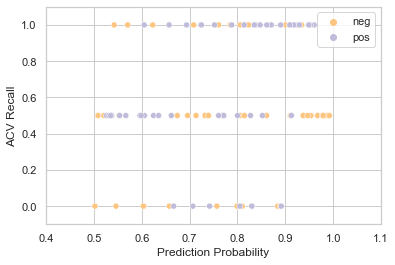

Diabetes


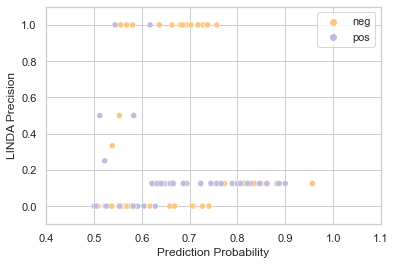

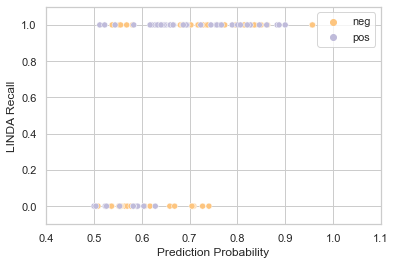

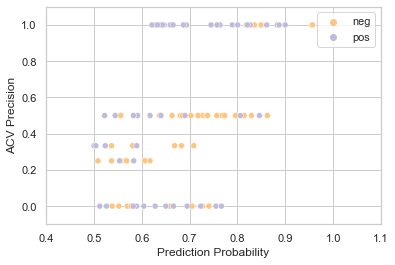

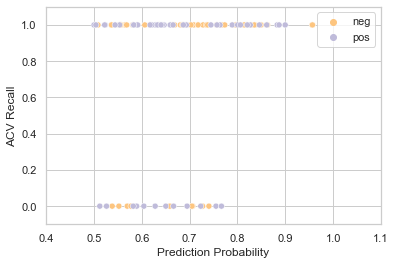

Iris


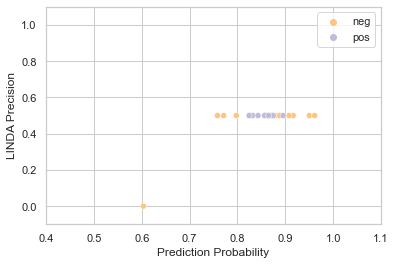

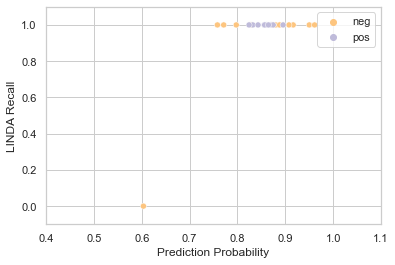

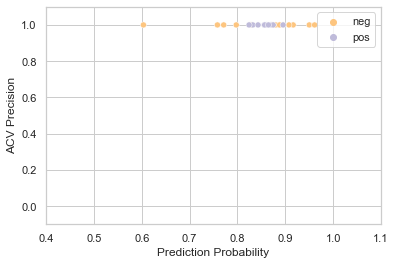

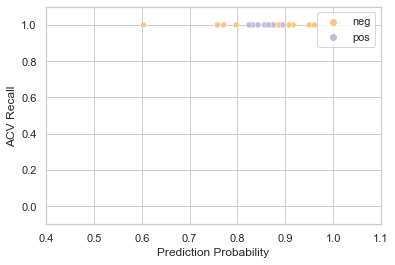

Mushroom


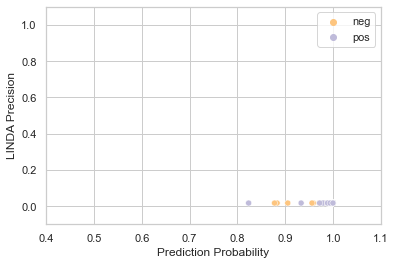

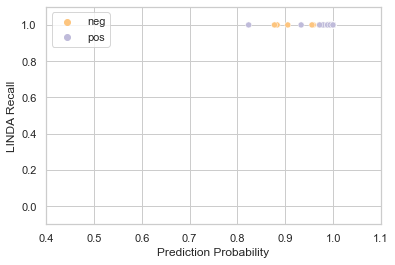

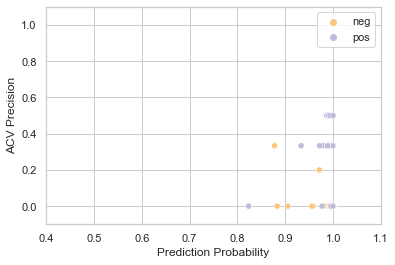

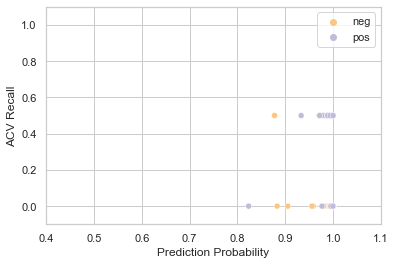

Nursery


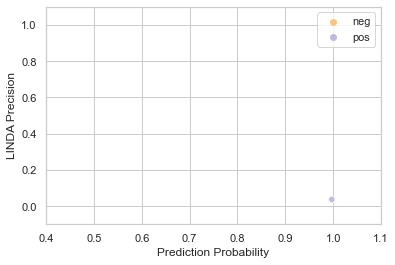

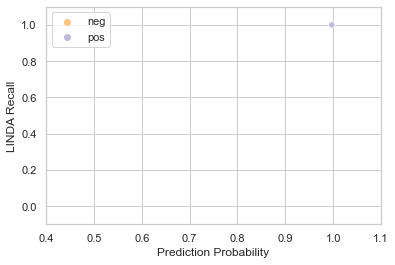

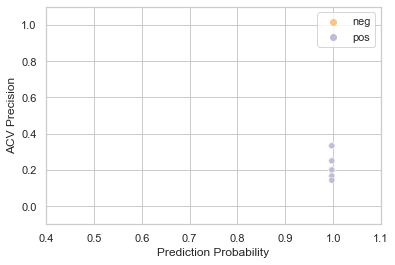

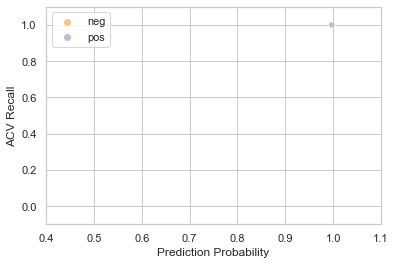

In [84]:
for index,group in logit_groups:
    print(index)
    probas = group["Prediction Probability"]
    preds = group["Prediction"].map({0: "neg", 1: "pos"}).values #["neg" for i in group["Prediction"] if (group["Prediction"][i] == 0) else "pos"]

    shap_prec = group["LINDA Precision"]
    shap_rec = group["LINDA Recall"]
    
    lime_prec = group["ACV Precision"]
    lime_rec = group["ACV Recall"]
    
    sns.scatterplot(probas, shap_prec, hue = preds, palette = "PuOr")
    plt.xlim(0.4, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()
    
    sns.scatterplot(probas, shap_rec, hue = preds, palette = "PuOr")
    plt.xlim(0.4, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()
    
    sns.scatterplot(probas, lime_prec, hue = preds, palette = "PuOr")
    plt.xlim(0.4, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()
    
    sns.scatterplot(probas, lime_rec, hue = preds, palette = "PuOr")
    plt.xlim(0.4, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()

Adult Income


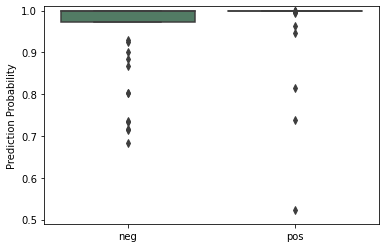

Breast Cancer


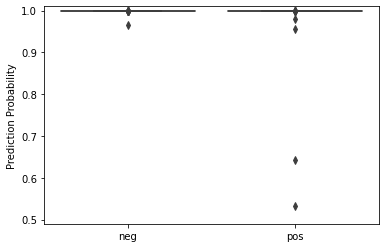

COMPAS


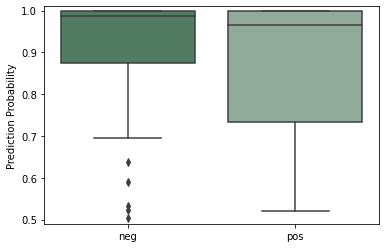

Diabetes


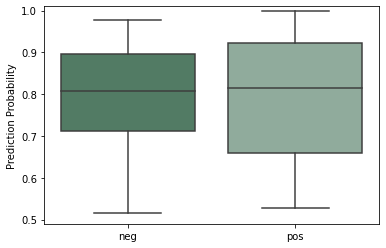

Iris


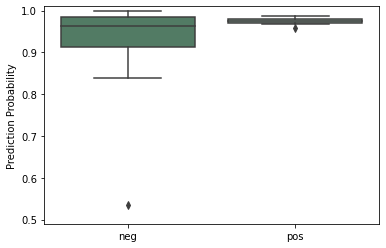

Mushroom


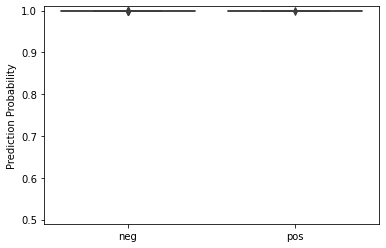

Nursery


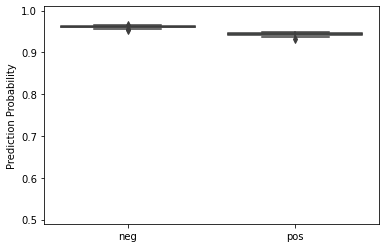

SHAP Precision  SHAP Recall  LIME Precision  \
Dataset       Prediction                                                
Adult Income  0                   0.1400       0.0018          0.7837   
              1                   0.6583       0.0097          0.9950   
Breast Cancer 0                   0.3267       0.2120          0.2701   
              1                   0.1933       0.0501          0.2718   
COMPAS        0                   0.0050       0.0040          0.8167   
              1                   0.0473       0.0360          0.6580   
Diabetes      0                   0.2917       0.1427          0.3067   
              1                   0.1183       0.0540          0.3100   
Iris          0                   0.5000       0.4487          0.5385   
              1                   1.0000       0.7821          1.0000   
Mushroom      0                   0.2767       0.0104          0.6297   
              1                   0.0400       0.0004          0.9044   
Nursery       0                   1.0000       0.3333          1.0000   
              1                   1.0000       1.0000          1.0000   

                          LIME Recall  
Dataset       Prediction               
Adult Income  0                0.0298  
              1                0.0398  
Breast Cancer 0                0.2376  
              1                0.1075  
COMPAS        0                0.4596  
              1                0.4366  
Diabetes      0                0.1600  
              1                0.0825  
Iris          0                0.4487  
              1                0.6667  
Mushroom      0                0.1758  
              1                0.2753  
Nursery       0                0.3333  
              1                1.0000

In [18]:
nb_results = cls_results[cls_results["Model"] == "nb"]
nb_groups = nb_results.groupby("Dataset")
for index,group in nb_groups:
    print(index)
    probas = group["Prediction Probability"]
    preds = group["Prediction"].map({0: "neg", 1: "pos"}).values #["neg" for i in group["Prediction"] if (group["Prediction"][i] == 0) else "pos"]
    sns.boxplot(preds, probas)
    plt.ylim(0.49, 1.01)
    plt.show()
nb_results.groupby(["Dataset", "Prediction"])["SHAP Precision", "SHAP Recall", "LIME Precision", "LIME Recall"].mean()

In [85]:
nb_results.groupby(["Dataset", "Prediction"])["Prediction Probability", "LINDA Precision", "LINDA Recall", 
                                              "ACV Precision", "ACV Recall"].median()

Prediction Probability  LINDA Precision  \
Dataset       Prediction                                            
Adult Income  0                           1.0000           0.9519   
              1                           1.0000           0.9327   
Breast Cancer 0                           1.0000           0.2917   
              1                           1.0000           0.2333   
COMPAS        0                           0.9865           0.2000   
              1                           0.9666           0.0000   
Diabetes      0                           0.8080           0.4375   
              1                           0.8151           0.3125   
Iris          0                           0.9638           0.2500   
              1                           0.9760           0.5000   
Mushroom      0                           1.0000           0.4915   
              1                           1.0000           0.4957   
Nursery       0                           0.9607           0.1111   
              1                           0.9428           0.0370   

                          LINDA Recall  ACV Precision  ACV Recall  
Dataset       Prediction                                           
Adult Income  0                 1.0000         0.1250      0.0049  
              1                 1.0000         1.0000      0.0125  
Breast Cancer 0                 0.3333         0.0000      0.0000  
              1                 1.0000         0.0000      0.0000  
COMPAS        0                 1.0000         0.0000      0.0000  
              1                 0.0000         0.0000      0.0000  
Diabetes      0                 0.2000         0.5000      0.3333  
              1                 1.0000         0.0000      0.0000  
Iris          0                 1.0000         0.5000      0.5000  
              1                 1.0000         1.0000      1.0000  
Mushroom      0                 1.0000         0.3333      0.0227  
              1                 1.0000         0.4167      0.0125  
Nursery       0                 1.0000         0.5000      1.0000  
              1                 1.0000         0.2000      1.0000

Adult Income


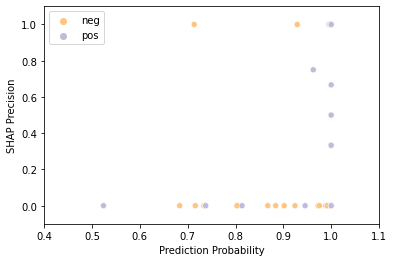

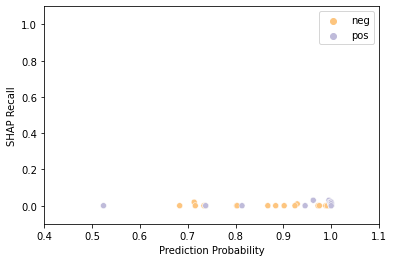

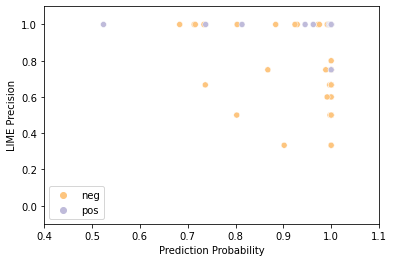

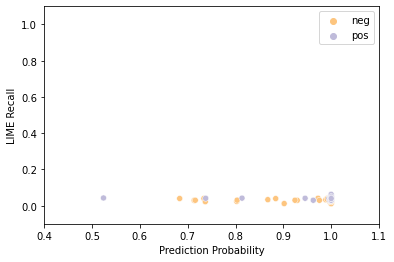

Breast Cancer


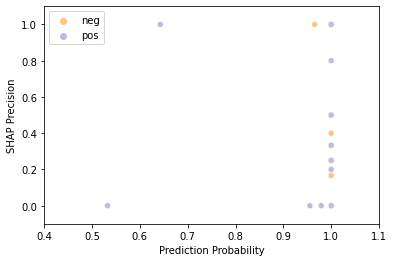

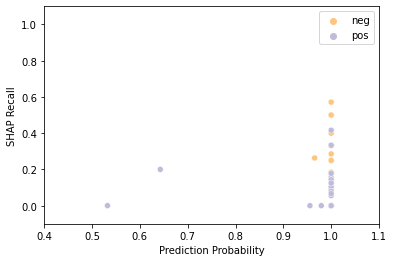

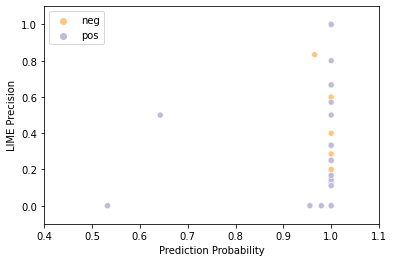

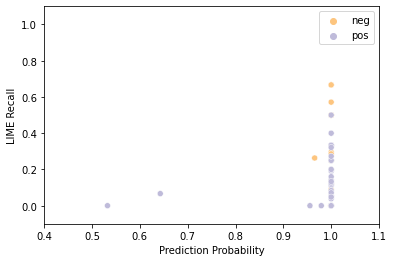

COMPAS


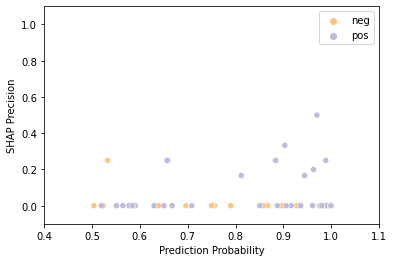

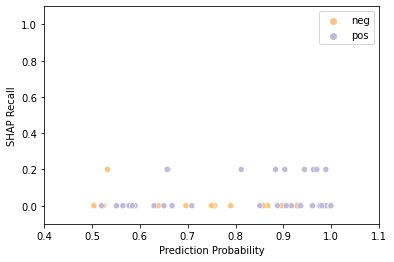

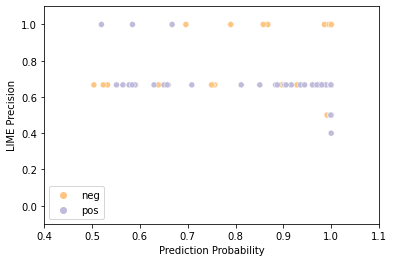

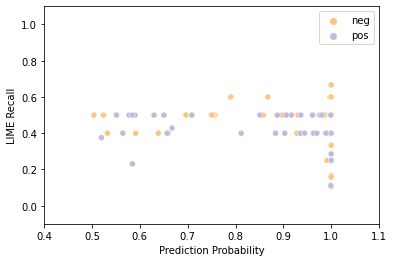

Diabetes


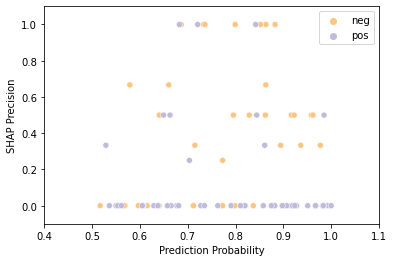

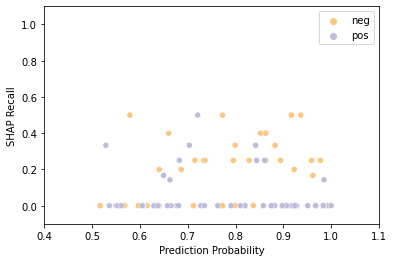

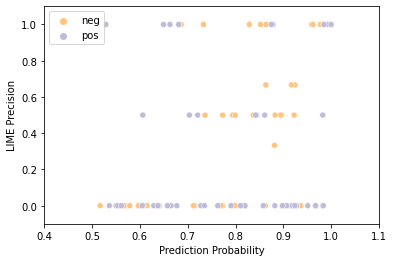

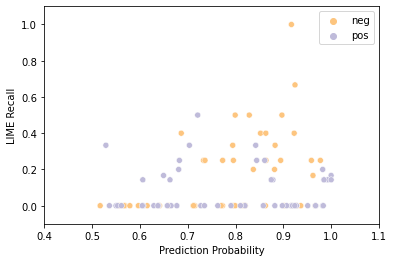

Iris


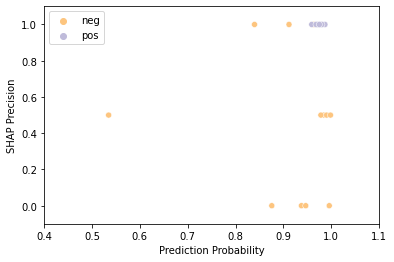

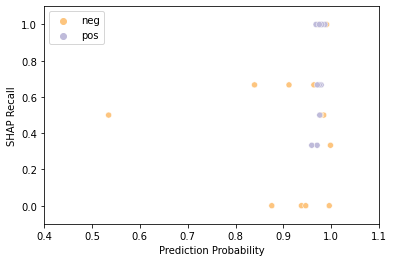

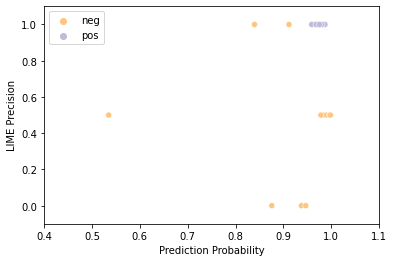

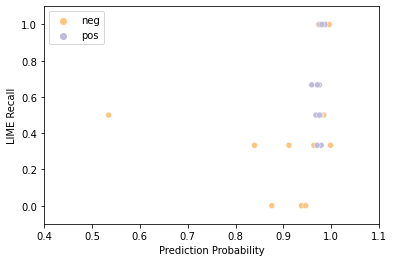

Mushroom


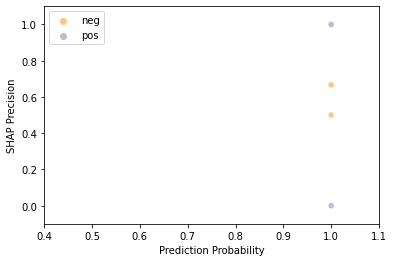

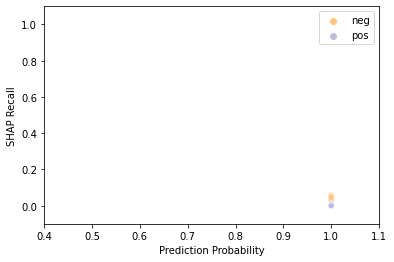

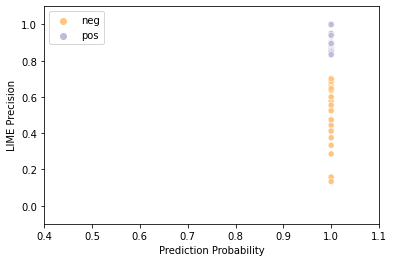

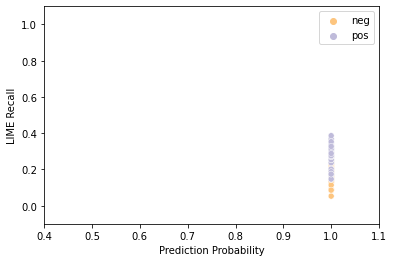

Nursery


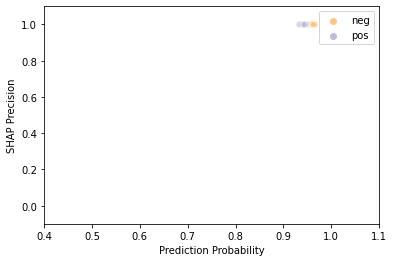

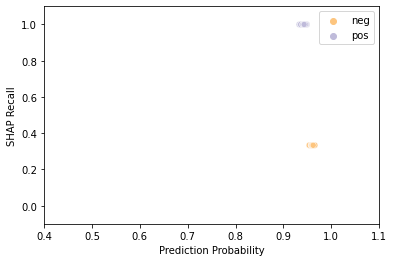

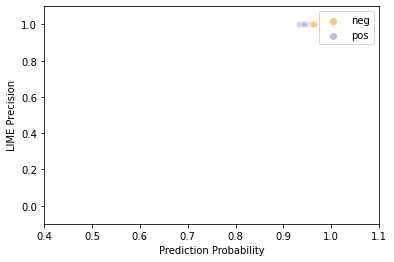

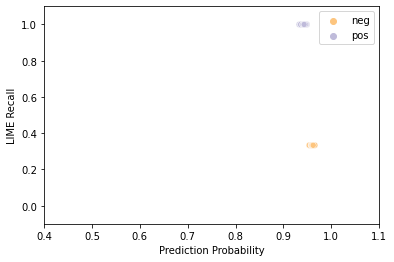

In [20]:
for index,group in nb_groups:
    print(index)
    probas = group["Prediction Probability"]
    preds = group["Prediction"].map({0: "neg", 1: "pos"}).values #["neg" for i in group["Prediction"] if (group["Prediction"][i] == 0) else "pos"]

    shap_prec = group["SHAP Precision"]
    shap_rec = group["SHAP Recall"]
    
    lime_prec = group["LIME Precision"]
    lime_rec = group["LIME Recall"]
    
    sns.scatterplot(probas, shap_prec, hue = preds, palette = "PuOr")
    plt.xlim(0.4, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()
    
    sns.scatterplot(probas, shap_rec, hue = preds, palette = "PuOr")
    plt.xlim(0.4, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()
    
    sns.scatterplot(probas, lime_prec, hue = preds, palette = "PuOr")
    plt.xlim(0.4, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()
    
    sns.scatterplot(probas, lime_rec, hue = preds, palette = "PuOr")
    plt.xlim(0.4, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()

In [16]:
cls_precision_columns = [method+" Precision" for method in cls_xai]
cls_recall_columns = [method+" Recall" for method in cls_xai]
cls_f1_columns = [method+" F1" for method in cls_xai]

print(cls_precision_columns)
print(cls_recall_columns)

all_cls_cols = []
all_cls_cols.extend(cls_precision_columns)
all_cls_cols.extend(cls_recall_columns)

reg_precision_columns = [method+" Precision" for method in reg_xai]
reg_recall_columns = [method+" Recall" for method in reg_xai]
reg_f1_columns = [method+" F1" for method in reg_xai]

print(reg_precision_columns)
print(reg_recall_columns)

all_reg_cols = []
all_reg_cols.extend(reg_precision_columns)
all_reg_cols.extend(reg_recall_columns)

['LIME Precision', 'SHAP Precision', 'LINDA Precision', 'ACV Precision']
['LIME Recall', 'SHAP Recall', 'LINDA Recall', 'ACV Recall']
['LIME Precision', 'SHAP Precision', 'ACV Precision']
['LIME Recall', 'SHAP Recall', 'ACV Recall']


Adult Income


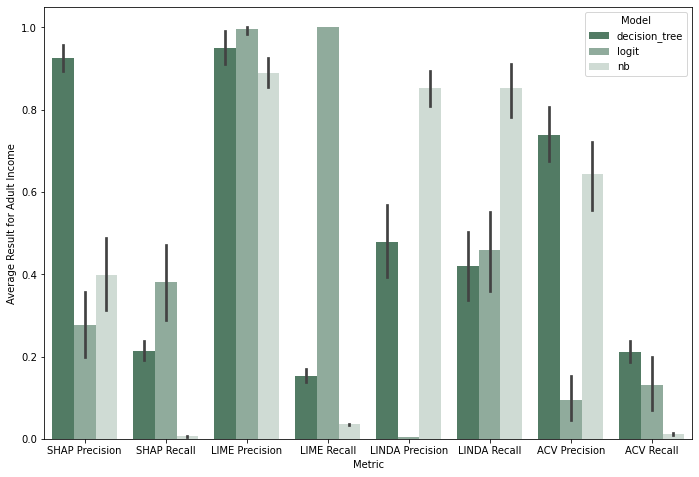

Breast Cancer


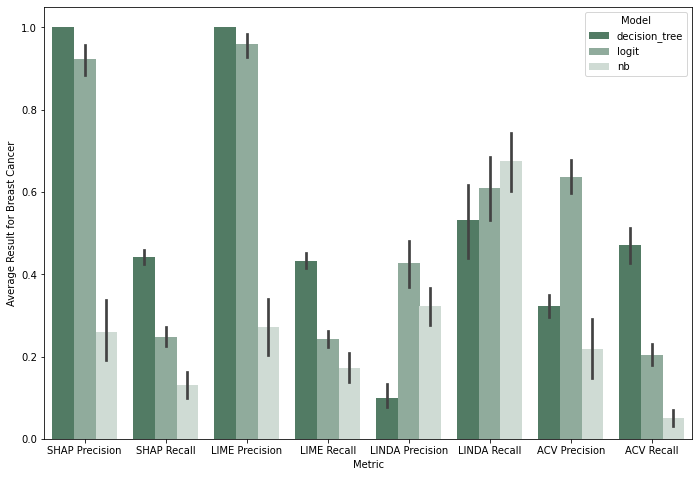

COMPAS


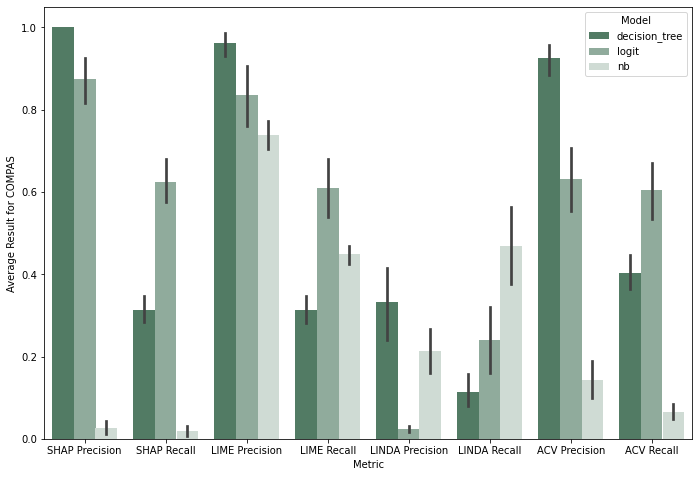

Diabetes


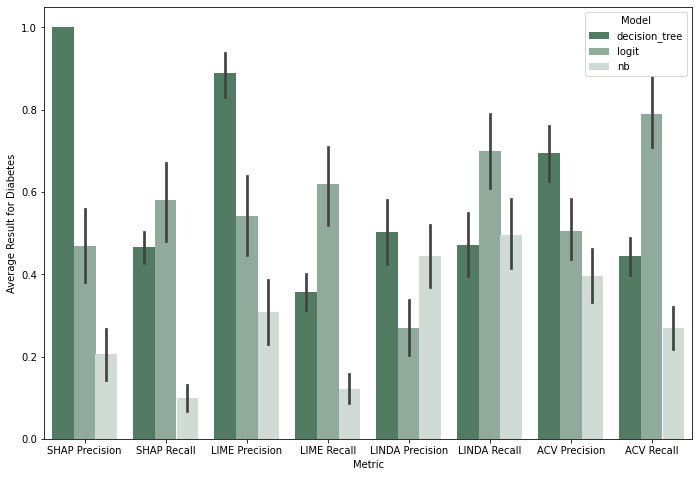

Iris


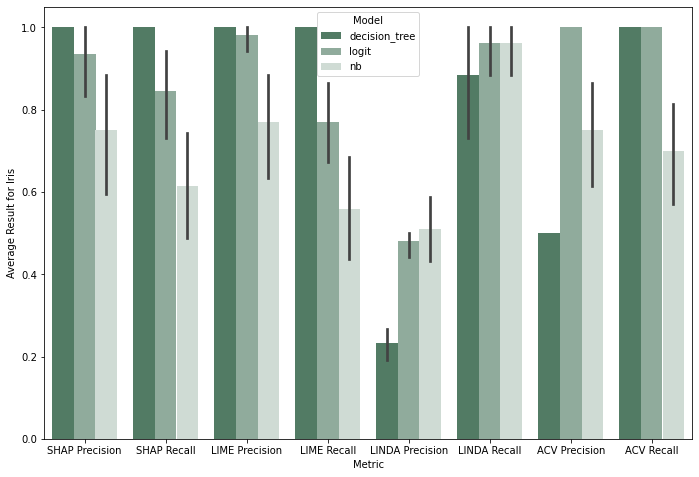

Mushroom


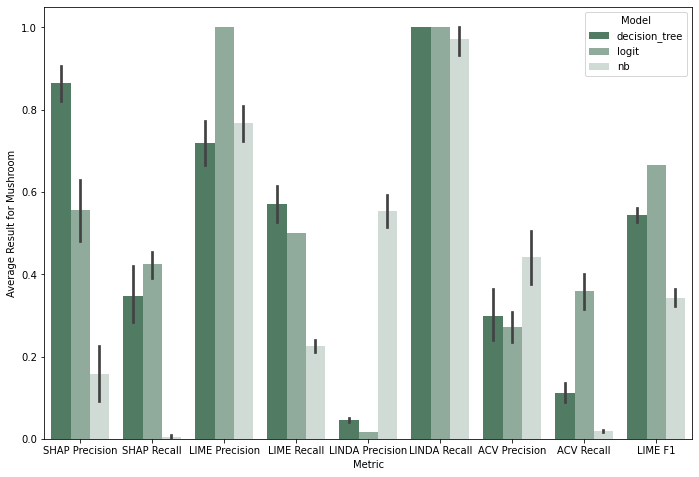

Nursery


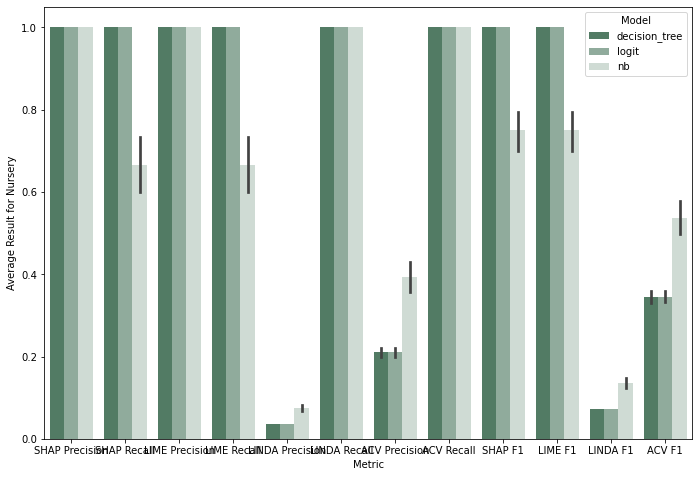

In [22]:
classification_results = cls_results.groupby('Dataset')
for index, group in classification_results:
    print(index)
#     model_group = group.groupby('Model').mean()
#     model_group = model_group.drop(["Actual", "Prediction", "Prediction Probability", 
#                                     "Model Accuracy", "F1 Score", "Prediction Type Numeric"], axis = 1)
#     model_group = model_group.transpose()
    
#     ax = plt.axes((0,0,1,1))
#     model_group.plot(legend=True, ax=ax, kind='bar', x=precision_columns.extend(recall_columns))
#     plt.show()
    
    fixed_group = group.drop(["Actual", "Prediction", "Prediction Probability", 
                                    "Model Accuracy", "F1 Score", "Prediction Type Numeric", 
                                     "Dataset", "Dataset Type", "Prediction Type"],
                             axis = 1)
    fixed_group = fixed_group.dropna(1)
#    fixed_group = fixed_group.groupby("Model").mean()
#    fixed_group.reset_index(inplace=True)
    
    res_name = "Average Result for "+index
    data = fixed_group.melt(id_vars = "Model", var_name="Metric", value_name = res_name)
    
    ax = plt.axes((0,0,1.5,1.5))
    sns.barplot(data = data, x = "Metric", y=res_name, hue="Model")
#     sns.boxplot(x = "variable", y = "value", data = pd.melt(fixed_group, id_vars="Model"), hue="Model")
    plt.show()

Bike Rentals


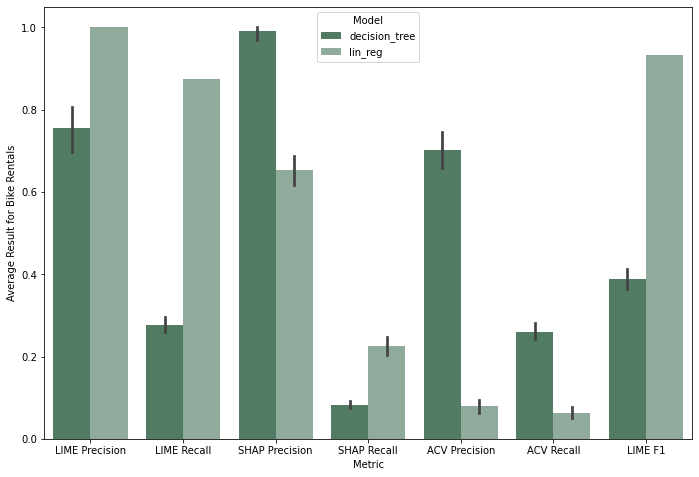

Facebook


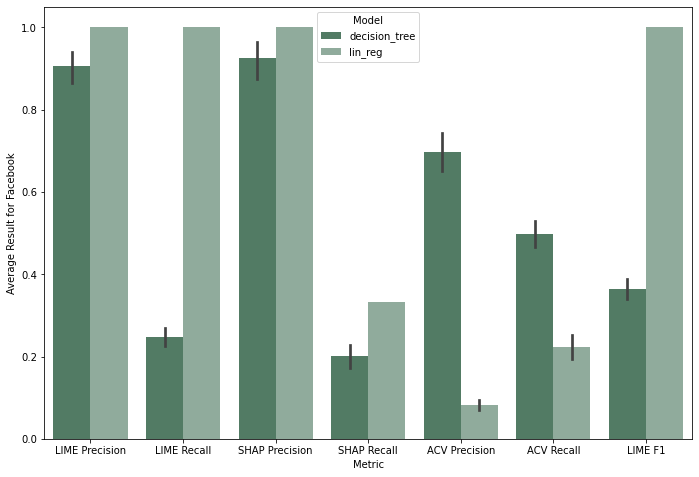

Housing


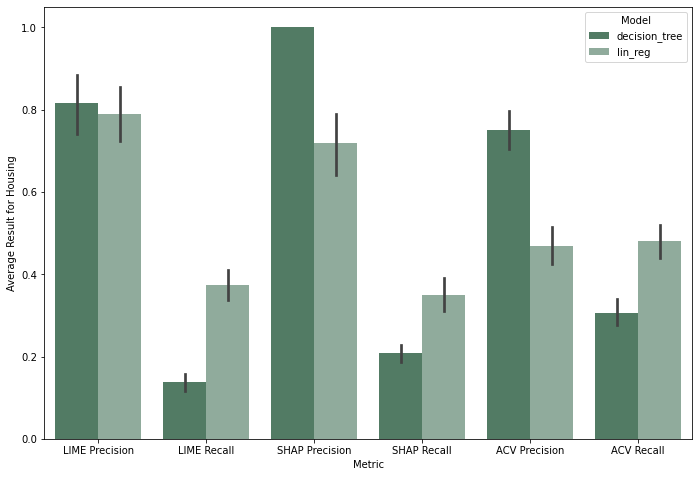

Real Estate


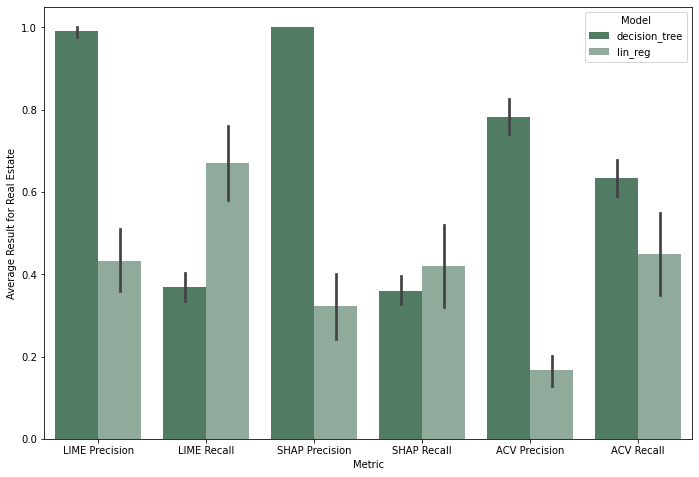

Solar Flare


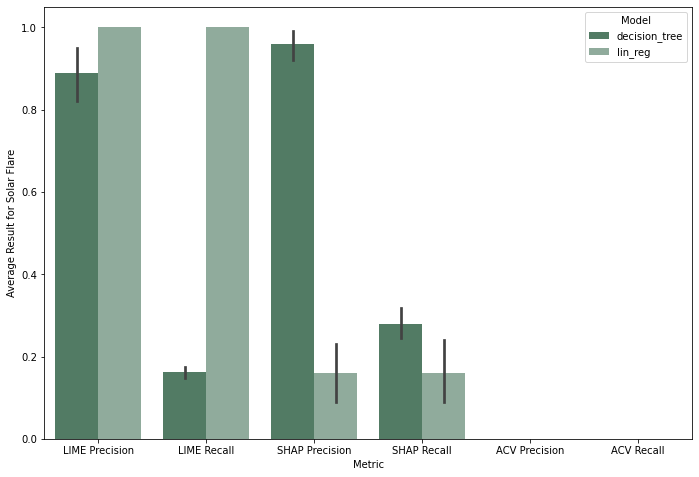

Student Results


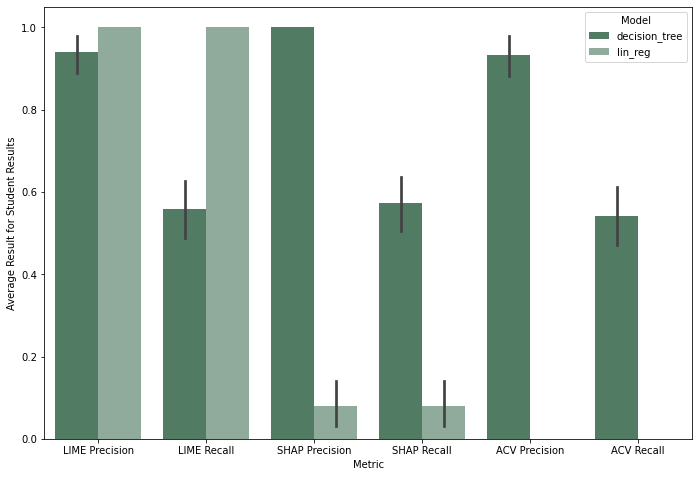

Wine Quality


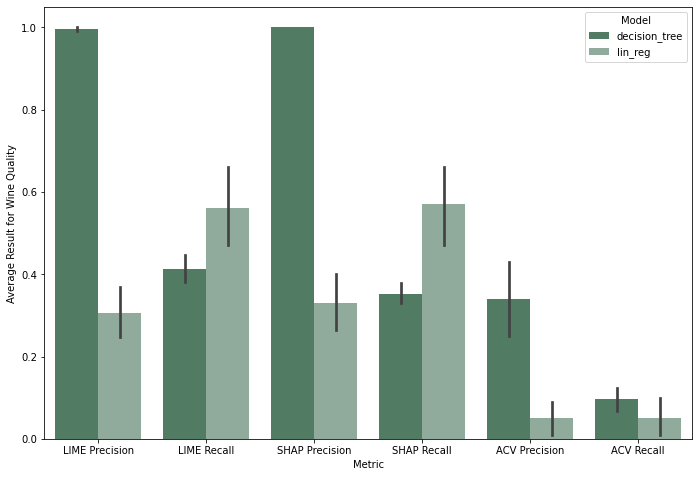

In [23]:
regression_results = reg_results.groupby('Dataset')
for index, group in regression_results:
    print(index)
#     model_group = group.groupby('Model').mean()
#     model_group = model_group.drop(["Actual", "Prediction", "Prediction Probability", 
#                                     "Model Accuracy", "F1 Score", "Prediction Type Numeric"], axis = 1)
#     model_group = model_group.transpose()
    
#     ax = plt.axes((0,0,1,1))
#     model_group.plot(legend=True, ax=ax, kind='bar', x=precision_columns.extend(recall_columns))
#     plt.show()
    
    fixed_group = group.drop(["Actual", "Prediction", "MAPE", "R-Squared", "Prediction Type Numeric", 
                                     "Dataset", "Dataset Type"],
                             axis = 1)
    fixed_group = fixed_group.dropna(1)
#    fixed_group = fixed_group.groupby("Model").mean()
#    fixed_group.reset_index(inplace=True)
    
    res_name = "Average Result for "+index
    data = fixed_group.melt(id_vars = "Model", var_name="Metric", value_name = res_name)
    
    ax = plt.axes((0,0,1.5,1.5))
    sns.barplot(data = data, x = "Metric", y=res_name, hue="Model")
#     sns.boxplot(x = "variable", y = "value", data = pd.melt(fixed_group, id_vars="Model"), hue="Model")
    plt.show()

# Dataset Prediction Probabilities

Adult Income


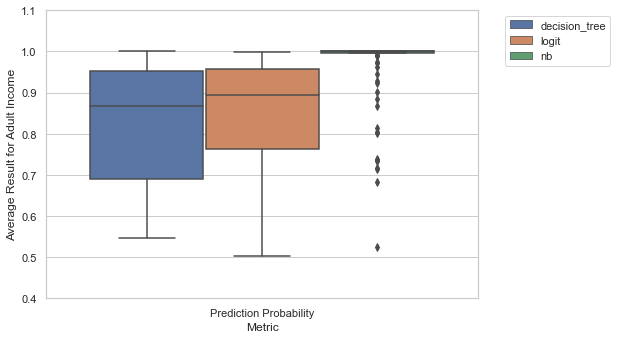

Breast Cancer


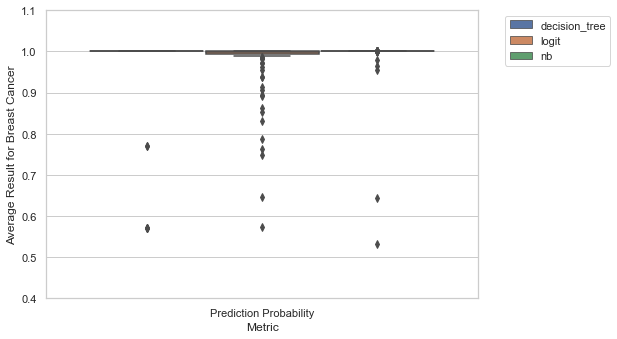

COMPAS


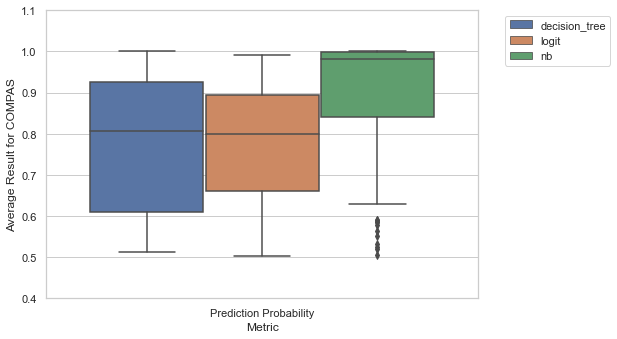

Diabetes


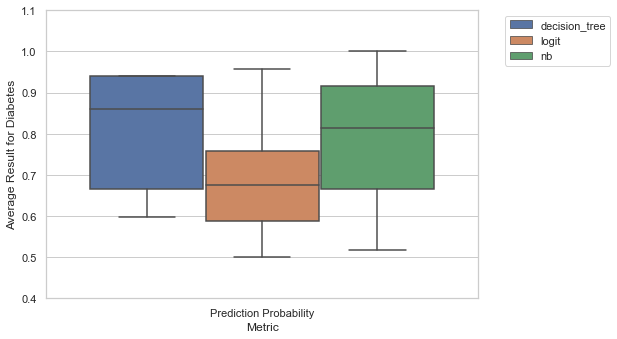

Iris


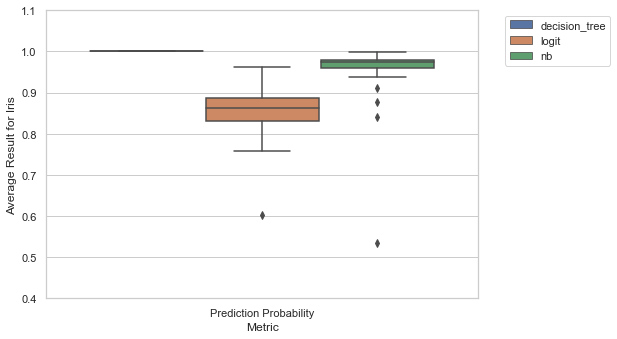

Mushroom


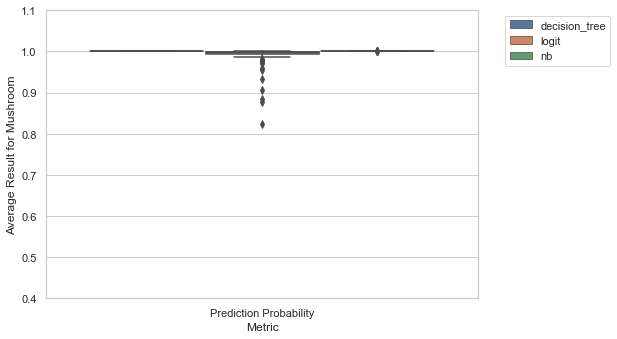

Nursery


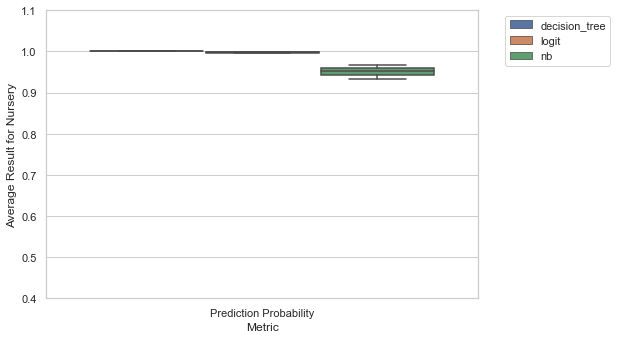

In [54]:
classification_results = cls_results.groupby('Dataset')
sns.set_theme(style="whitegrid")
for index, group in classification_results:
    print(index)
    
    fixed_group = group.drop(["LIME Precision", "LIME Recall", "SHAP Precision", "SHAP Recall", 
                              "LINDA Precision", "LINDA Recall", "ACV Precision", "ACV Recall",
                              "LIME F1", "SHAP F1", "LINDA F1", "ACV F1"], axis = 1)

    fixed_group = fixed_group.drop(["Actual", "Prediction", 
                                    "Model Accuracy", "F1 Score", "Prediction Type Numeric", 
                                     "Dataset", "Dataset Type", "Prediction Type"], axis = 1)
    fixed_group = fixed_group.dropna(1)

    res_name = "Average Result for "+index
    data = fixed_group.melt(id_vars = "Model", var_name="Metric", value_name = res_name)

    ax = plt.axes((0,0,1,1))
    ax.set_ylim(0.4,1.1)
    sns.boxplot(data = data, x = "Metric", y=res_name, hue="Model")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

In [25]:
cls_results[['Dataset', 'Model', 'Prediction Probability']].groupby(['Dataset','Model']).describe()#.isnull().values.any()

Prediction Probability                       \
                                             count   mean    std    min   
Dataset       Model                                                       
Adult Income  decision_tree               100.0000 0.8215 0.1573 0.5455   
              logit                       100.0000 0.8461 0.1420 0.5032   
              nb                          100.0000 0.9657 0.0871 0.5240   
Breast Cancer decision_tree               100.0000 0.9782 0.0895 0.5714   
              logit                       100.0000 0.9727 0.0725 0.5731   
              nb                          100.0000 0.9907 0.0587 0.5323   
COMPAS        decision_tree               100.0000 0.7856 0.1582 0.5128   
              logit                       100.0000 0.7741 0.1411 0.5022   
              nb                          100.0000 0.8925 0.1559 0.5040   
Diabetes      decision_tree               100.0000 0.7957 0.1288 0.5965   
              logit                       100.0000 0.6826 0.1111 0.5003   
              nb                          100.0000 0.7907 0.1395 0.5170   
Iris          decision_tree                26.0000 1.0000 0.0000 1.0000   
              logit                        26.0000 0.8524 0.0688 0.6036   
              nb                           26.0000 0.9464 0.0914 0.5347   
Mushroom      decision_tree               100.0000 1.0000 0.0000 1.0000   
              logit                       100.0000 0.9896 0.0267 0.8235   
              nb                          100.0000 1.0000 0.0000 0.9999   
Nursery       decision_tree               100.0000 1.0000 0.0000 1.0000   
              logit                       100.0000 0.9974 0.0001 0.9972   
              nb                          100.0000 0.9517 0.0096 0.9331   

                                                         
                               25%    50%    75%    max  
Dataset       Model                                      
Adult Income  decision_tree 0.6909 0.8670 0.9533 1.0000  
              logit         0.7628 0.8945 0.9577 0.9993  
              nb            0.9968 1.0000 1.0000 1.0000  
Breast Cancer decision_tree 1.0000 1.0000 1.0000 1.0000  
              logit         0.9947 0.9997 1.0000 1.0000  
              nb            1.0000 1.0000 1.0000 1.0000  
COMPAS        decision_tree 0.6092 0.8058 0.9255 1.0000  
              logit         0.6609 0.7996 0.8939 0.9923  
              nb            0.8411 0.9806 0.9997 1.0000  
Diabetes      decision_tree 0.6667 0.8605 0.9412 0.9412  
              logit         0.5878 0.6747 0.7589 0.9569  
              nb            0.6647 0.8135 0.9165 1.0000  
Iris          decision_tree 1.0000 1.0000 1.0000 1.0000  
              logit         0.8299 0.8630 0.8861 0.9614  
              nb            0.9605 0.9752 0.9791 0.9985  
Mushroom      decision_tree 1.0000 1.0000 1.0000 1.0000  
              logit         0.9932 0.9979 0.9996 1.0000  
              nb            1.0000 1.0000 1.0000 1.0000  
Nursery       decision_tree 1.0000 1.0000 1.0000 1.0000  
              logit         0.9973 0.9974 0.9974 0.9976  
              nb            0.9428 0.9517 0.9606 0.9660

# Results Distributions

Adult Income


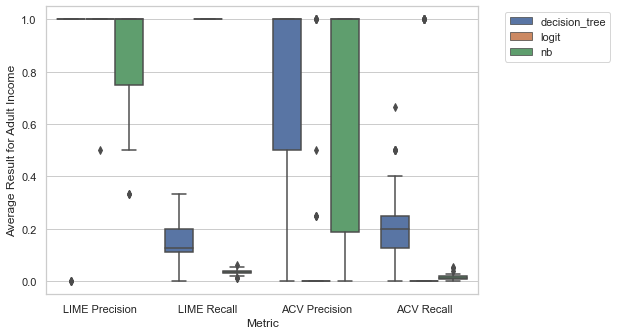

Breast Cancer


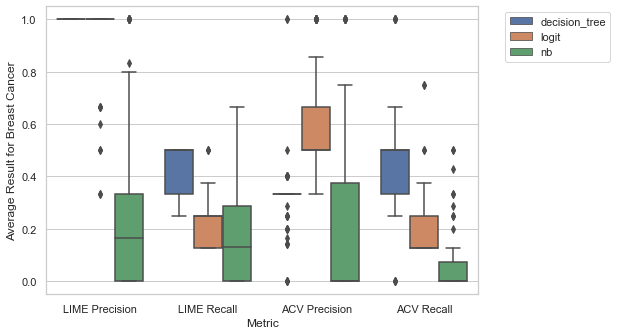

COMPAS


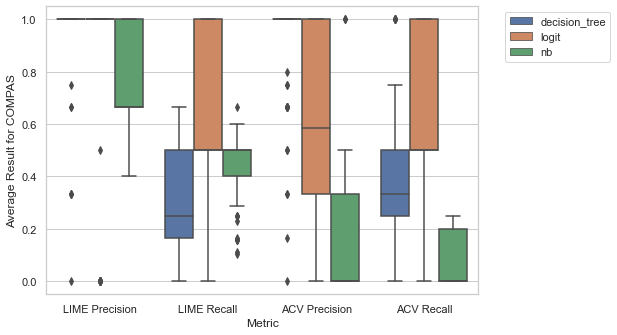

Diabetes


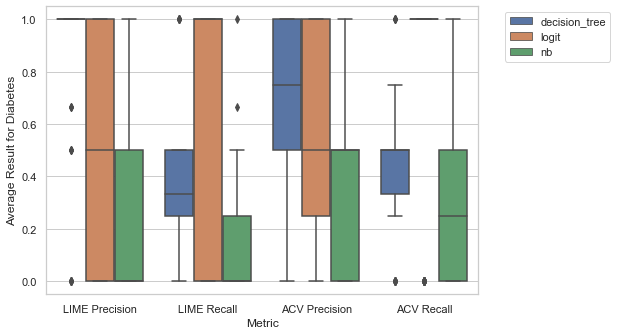

Iris


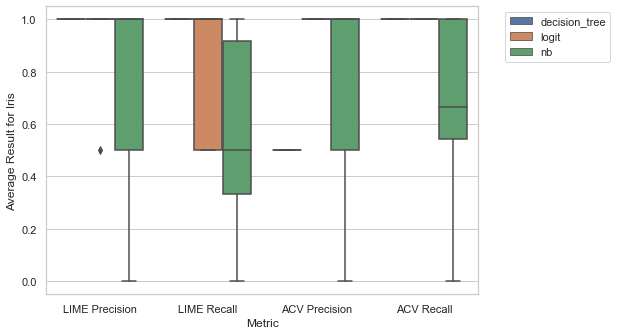

Mushroom


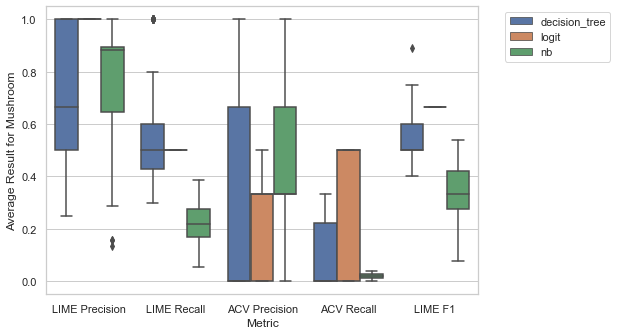

Nursery


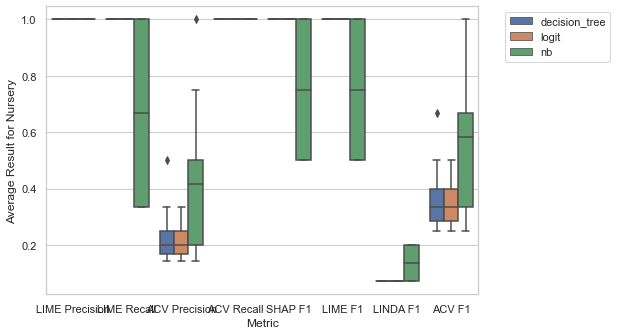

In [26]:
classification_results = cls_results.groupby('Dataset')
sns.set_theme(style="whitegrid")
for index, group in classification_results:
    print(index)
    
    fixed_group = group.drop(["SHAP Precision", "SHAP Recall", "LINDA Precision", "LINDA Recall"], axis = 1)#, "ACV Precision", "ACV Recall"],

    fixed_group = fixed_group.drop(["Actual", "Prediction", "Prediction Probability", 
                                    "Model Accuracy", "F1 Score", "Prediction Type Numeric", 
                                     "Dataset", "Dataset Type", "Prediction Type"], axis = 1)
    fixed_group = fixed_group.dropna(1)

    res_name = "Average Result for "+index
    data = fixed_group.melt(id_vars = "Model", var_name="Metric", value_name = res_name)

    ax = plt.axes((0,0,1,1))
    sns.boxplot(data = data, x = "Metric", y=res_name, hue="Model")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

In [27]:
cls_results[['Dataset', 'Model', 'LIME Precision', 'LIME Recall']].groupby(['Dataset','Model']).describe()#.isnull().values.any()

LIME Precision                                     \
                                     count   mean    std    min    25%    50%   
Dataset       Model                                                             
Adult Income  decision_tree       100.0000 0.9500 0.2190 0.0000 1.0000 1.0000   
              logit               100.0000 0.9950 0.0500 0.5000 1.0000 1.0000   
              nb                  100.0000 0.8893 0.1885 0.3333 0.7500 1.0000   
Breast Cancer decision_tree       100.0000 1.0000 0.0000 1.0000 1.0000 1.0000   
              logit               100.0000 0.9593 0.1359 0.3333 1.0000 1.0000   
              nb                  100.0000 0.2709 0.3375 0.0000 0.0000 0.1667   
COMPAS        decision_tree       100.0000 0.9608 0.1578 0.0000 1.0000 1.0000   
              logit               100.0000 0.8350 0.3697 0.0000 1.0000 1.0000   
              nb                  100.0000 0.7373 0.1646 0.4000 0.6667 0.6667   
Diabetes      decision_tree       100.0000 0.8900 0.2865 0.0000 1.0000 1.0000   
              logit               100.0000 0.5425 0.4697 0.0000 0.0000 0.5000   
              nb                  100.0000 0.3083 0.4044 0.0000 0.0000 0.0000   
Iris          decision_tree        26.0000 1.0000 0.0000 1.0000 1.0000 1.0000   
              logit                26.0000 0.9808 0.0981 0.5000 1.0000 1.0000   
              nb                   26.0000 0.7692 0.3530 0.0000 0.5000 1.0000   
Mushroom      decision_tree       100.0000 0.7178 0.2921 0.2500 0.5000 0.6667   
              logit               100.0000 1.0000 0.0000 1.0000 1.0000 1.0000   
              nb                  100.0000 0.7671 0.2170 0.1333 0.6444 0.8824   
Nursery       decision_tree       100.0000 1.0000 0.0000 1.0000 1.0000 1.0000   
              logit               100.0000 1.0000 0.0000 1.0000 1.0000 1.0000   
              nb                  100.0000 1.0000 0.0000 1.0000 1.0000 1.0000   

                                          LIME Recall                       \
                               75%    max       count   mean    std    min   
Dataset       Model                                                          
Adult Income  decision_tree 1.0000 1.0000    100.0000 0.1536 0.0739 0.0000   
              logit         1.0000 1.0000    100.0000 1.0000 0.0000 1.0000   
              nb            1.0000 1.0000    100.0000 0.0348 0.0097 0.0115   
Breast Cancer decision_tree 1.0000 1.0000    100.0000 0.4325 0.0953 0.2500   
              logit         1.0000 1.0000    100.0000 0.2425 0.1002 0.1250   
              nb            0.3333 1.0000    100.0000 0.1725 0.1789 0.0000   
COMPAS        decision_tree 1.0000 1.0000    100.0000 0.3135 0.1637 0.0000   
              logit         1.0000 1.0000    100.0000 0.6100 0.3523 0.0000   
              nb            1.0000 1.0000    100.0000 0.4481 0.1096 0.1053   
Diabetes      decision_tree 1.0000 1.0000    100.0000 0.3567 0.2191 0.0000   
              logit         1.0000 1.0000    100.0000 0.6200 0.4878 0.0000   
              nb            0.5000 1.0000    100.0000 0.1213 0.1816 0.0000   
Iris          decision_tree 1.0000 1.0000     26.0000 1.0000 0.0000 1.0000   
              logit         1.0000 1.0000     26.0000 0.7692 0.2542 0.5000   
              nb            1.0000 1.0000     26.0000 0.5577 0.3264 0.0000   
Mushroom      decision_tree 1.0000 1.0000    100.0000 0.5704 0.2336 0.3000   
              logit         1.0000 1.0000    100.0000 0.5000 0.0000 0.5000   
              nb            0.8947 1.0000    100.0000 0.2256 0.0724 0.0526   
Nursery       decision_tree 1.0000 1.0000    100.0000 1.0000 0.0000 1.0000   
              logit         1.0000 1.0000    100.0000 1.0000 0.0000 1.0000   
              nb            1.0000 1.0000    100.0000 0.6667 0.3350 0.3333   

                                                         
                               25%    50%    75%    max  
Dataset       Model                                      
Adult Income  decision_tree 0.1111 0

Adult Income


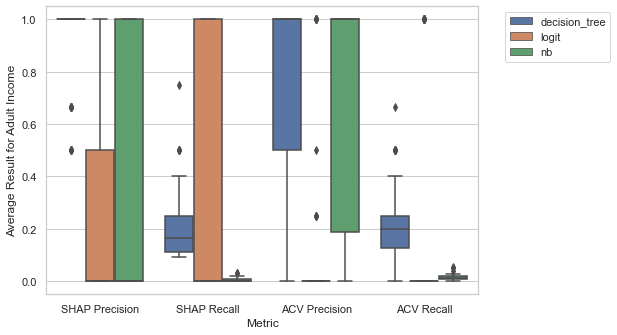

Breast Cancer


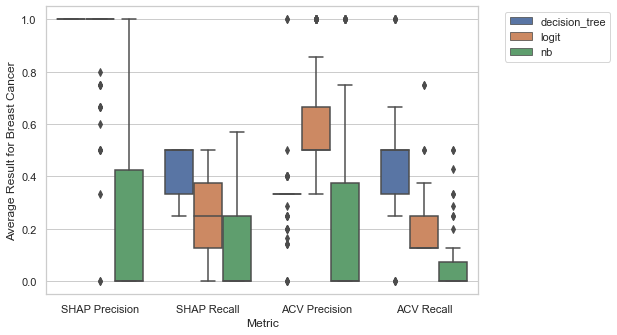

COMPAS


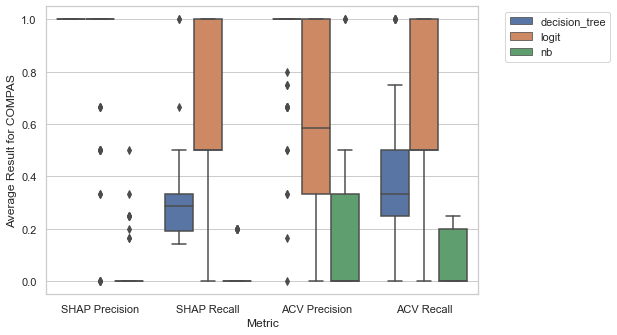

Diabetes


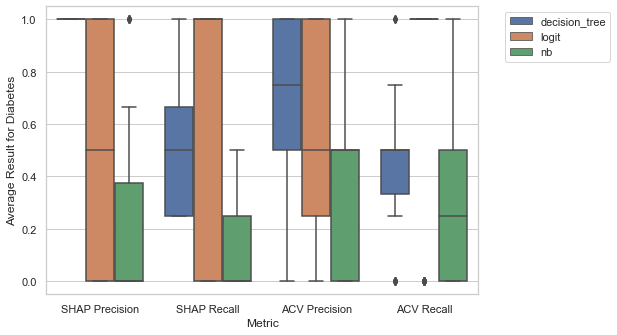

Iris


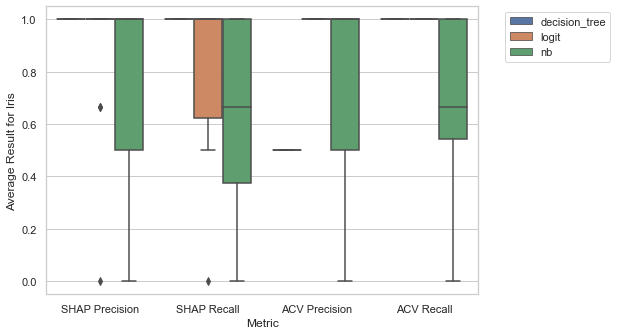

Mushroom


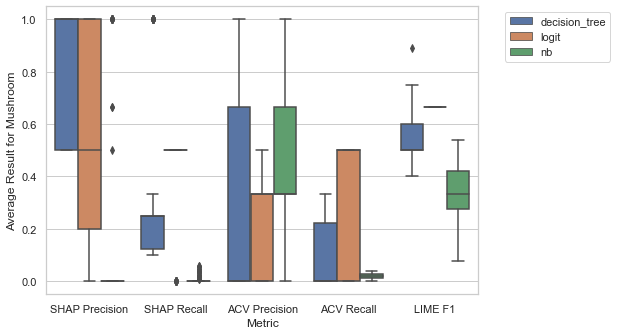

Nursery


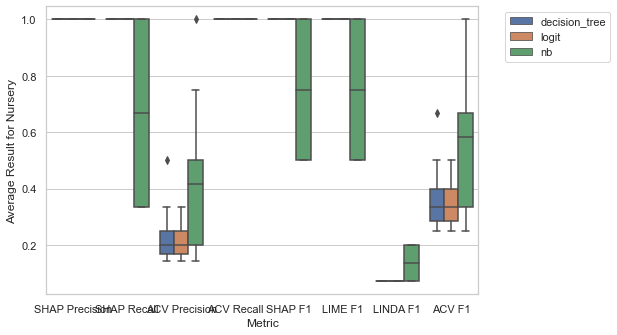

In [28]:
classification_results = cls_results.groupby('Dataset')
sns.set_theme(style="whitegrid")
for index, group in classification_results:
    print(index)
    
    fixed_group = group.drop(["LIME Precision", "LIME Recall", "LINDA Precision", "LINDA Recall"], axis = 1)#, "ACV Precision", "ACV Recall"],

    fixed_group = fixed_group.drop(["Actual", "Prediction", "Prediction Probability", 
                                    "Model Accuracy", "F1 Score", "Prediction Type Numeric", 
                                     "Dataset", "Dataset Type", "Prediction Type"], axis = 1)
    fixed_group = fixed_group.dropna(1)

    res_name = "Average Result for "+index
    data = fixed_group.melt(id_vars = "Model", var_name="Metric", value_name = res_name)

    ax = plt.axes((0,0,1,1))
    sns.boxplot(data = data, x = "Metric", y=res_name, hue="Model")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

In [29]:
cls_results[['Dataset', 'Model', 'SHAP Precision', 'SHAP Recall']].groupby(['Dataset','Model']).describe()#.isnull().values.any()

SHAP Precision                                     \
                                     count   mean    std    min    25%    50%   
Dataset       Model                                                             
Adult Income  decision_tree       100.0000 0.9267 0.1612 0.5000 1.0000 1.0000   
              logit               100.0000 0.2767 0.3997 0.0000 0.0000 0.0000   
              nb                  100.0000 0.3992 0.4623 0.0000 0.0000 0.0000   
Breast Cancer decision_tree       100.0000 1.0000 0.0000 1.0000 1.0000 1.0000   
              logit               100.0000 0.9240 0.1949 0.0000 1.0000 1.0000   
              nb                  100.0000 0.2600 0.3573 0.0000 0.0000 0.0000   
COMPAS        decision_tree       100.0000 1.0000 0.0000 1.0000 1.0000 1.0000   
              logit               100.0000 0.8733 0.2794 0.0000 1.0000 1.0000   
              nb                  100.0000 0.0262 0.0841 0.0000 0.0000 0.0000   
Diabetes      decision_tree       100.0000 1.0000 0.0000 1.0000 1.0000 1.0000   
              logit               100.0000 0.4683 0.4510 0.0000 0.0000 0.5000   
              nb                  100.0000 0.2050 0.3322 0.0000 0.0000 0.0000   
Iris          decision_tree        26.0000 1.0000 0.0000 1.0000 1.0000 1.0000   
              logit                26.0000 0.9359 0.2112 0.0000 1.0000 1.0000   
              nb                   26.0000 0.7500 0.3808 0.0000 0.5000 1.0000   
Mushroom      decision_tree       100.0000 0.8650 0.2231 0.5000 0.5000 1.0000   
              logit               100.0000 0.5553 0.3955 0.0000 0.2000 0.5000   
              nb                  100.0000 0.1583 0.3572 0.0000 0.0000 0.0000   
Nursery       decision_tree       100.0000 1.0000 0.0000 1.0000 1.0000 1.0000   
              logit               100.0000 1.0000 0.0000 1.0000 1.0000 1.0000   
              nb                  100.0000 1.0000 0.0000 1.0000 1.0000 1.0000   

                                          SHAP Recall                       \
                               75%    max       count   mean    std    min   
Dataset       Model                                                          
Adult Income  decision_tree 1.0000 1.0000    100.0000 0.2145 0.1231 0.0909   
              logit         0.5000 1.0000    100.0000 0.3800 0.4878 0.0000   
              nb            1.0000 1.0000    100.0000 0.0057 0.0070 0.0000   
Breast Cancer decision_tree 1.0000 1.0000    100.0000 0.4425 0.0884 0.2500   
              logit         1.0000 1.0000    100.0000 0.2475 0.1218 0.0000   
              nb            0.4250 1.0000    100.0000 0.1311 0.1670 0.0000   
COMPAS        decision_tree 1.0000 1.0000    100.0000 0.3126 0.1613 0.1429   
              logit         1.0000 1.0000    100.0000 0.6250 0.2787 0.0000   
              nb            0.0000 0.5000    100.0000 0.0200 0.0603 0.0000   
Diabetes      decision_tree 1.0000 1.0000    100.0000 0.4667 0.1996 0.2500   
              logit         1.0000 1.0000    100.0000 0.5800 0.4960 0.0000   
              nb            0.3750 1.0000    100.0000 0.0984 0.1540 0.0000   
Iris          decision_tree 1.0000 1.0000     26.0000 1.0000 0.0000 1.0000   
              logit         1.0000 1.0000     26.0000 0.8462 0.2746 0.0000   
              nb            1.0000 1.0000     26.0000 0.6154 0.3552 0.0000   
Mushroom      decision_tree 1.0000 1.0000    100.0000 0.3479 0.3337 0.1000   
              logit         1.0000 1.0000    100.0000 0.4250 0.1794 0.0000   
              nb            0.0000 1.0000    100.0000 0.0054 0.0136 0.0000   
Nursery       decision_tree 1.0000 1.0000    100.0000 1.0000 0.0000 1.0000   
              logit         1.0000 1.0000    100.0000 1.0000 0.0000 1.0000   
              nb            1.0000 1.0000    100.0000 0.6667 0.3350 0.3333   

                                                         
                               25%    50%    75%    max  
Dataset       Model                                      
Adult Income  decision_tree 0.1111 0

Adult Income


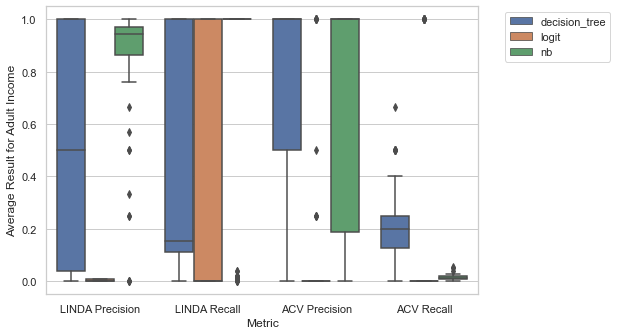

Breast Cancer


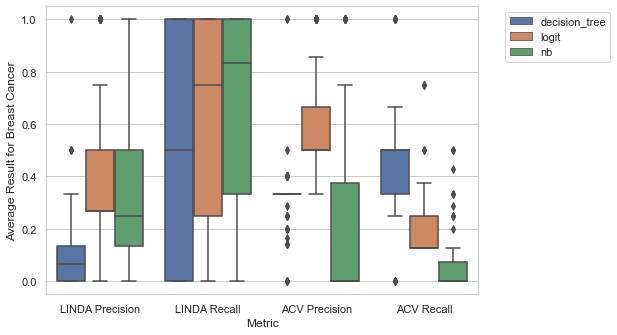

COMPAS


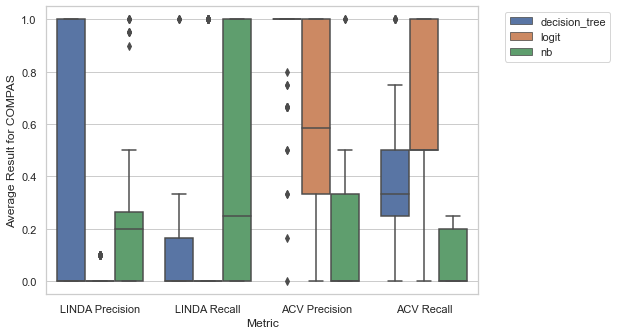

Diabetes


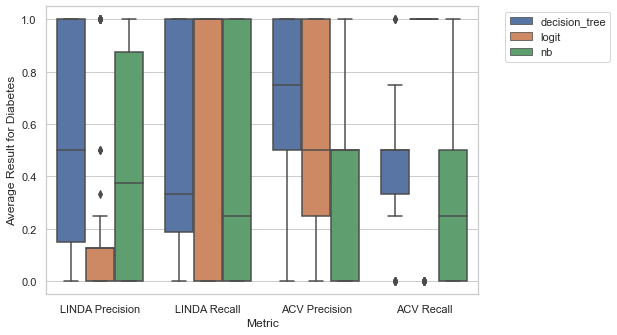

Iris


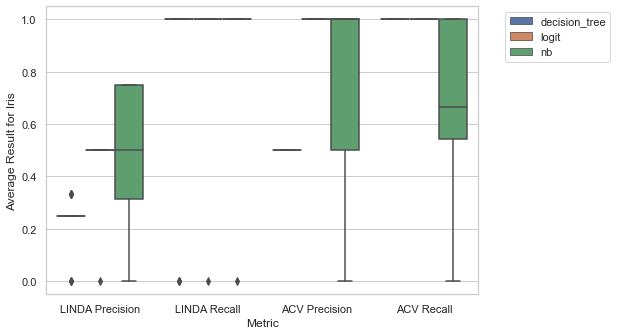

Mushroom


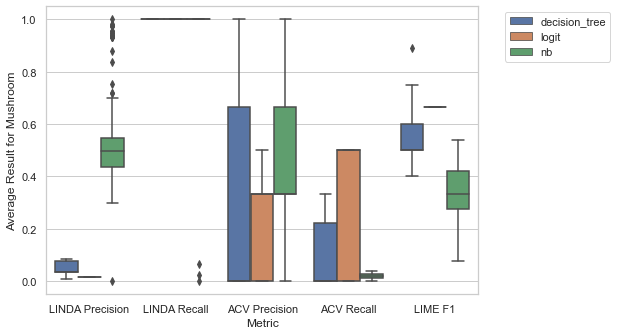

Nursery


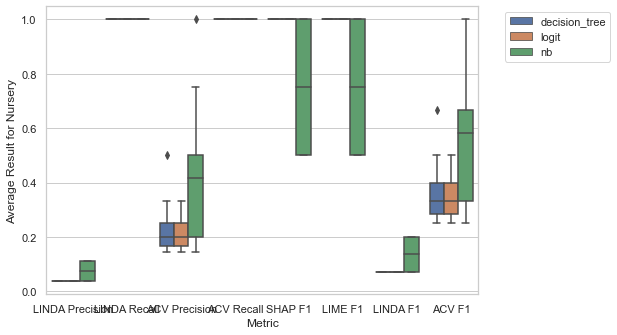

In [30]:
classification_results = cls_results.groupby('Dataset')
sns.set_theme(style="whitegrid")
for index, group in classification_results:
    print(index)
    
    if group['LINDA Precision'].isnull().values.any():
        print("No LINDA results for dataset")
    else:
        fixed_group = group.drop(["SHAP Precision", "SHAP Recall", "LIME Precision", 
                                        "LIME Recall"], axis = 1)#, "ACV Precision", "ACV Recall"],
                                 
        fixed_group = fixed_group.drop(["Actual", "Prediction", "Prediction Probability", 
                                        "Model Accuracy", "F1 Score", "Prediction Type Numeric", 
                                         "Dataset", "Dataset Type", "Prediction Type"], axis = 1)
        fixed_group = fixed_group.dropna(1)

        res_name = "Average Result for "+index
        data = fixed_group.melt(id_vars = "Model", var_name="Metric", value_name = res_name)

        ax = plt.axes((0,0,1,1))
        sns.boxplot(data = data, x = "Metric", y=res_name, hue="Model")
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.show()

In [31]:
cls_results[['Dataset', 'Model', 'LINDA Precision', 'LINDA Recall']].groupby(['Dataset','Model']).describe()#.isnull().values.any()

LINDA Precision                              \
                                      count   mean    std    min    25%   
Dataset       Model                                                       
Adult Income  decision_tree        100.0000 0.4788 0.4518 0.0000 0.0385   
              logit                100.0000 0.0044 0.0048 0.0000 0.0000   
              nb                   100.0000 0.8528 0.2265 0.0000 0.8630   
Breast Cancer decision_tree        100.0000 0.0996 0.1407 0.0000 0.0000   
              logit                100.0000 0.4273 0.2946 0.0000 0.2667   
              nb                   100.0000 0.3222 0.2345 0.0000 0.1333   
COMPAS        decision_tree        100.0000 0.3313 0.4638 0.0000 0.0000   
              logit                100.0000 0.0240 0.0429 0.0000 0.0000   
              nb                   100.0000 0.2125 0.2884 0.0000 0.0000   
Diabetes      decision_tree        100.0000 0.5027 0.3978 0.0000 0.1500   
              logit                100.0000 0.2683 0.3685 0.0000 0.0000   
              nb                   100.0000 0.4455 0.4018 0.0000 0.0000   
Iris          decision_tree         26.0000 0.2340 0.0913 0.0000 0.2500   
              logit                 26.0000 0.4808 0.0981 0.0000 0.5000   
              nb                    26.0000 0.5096 0.2177 0.0000 0.3125   
Mushroom      decision_tree        100.0000 0.0464 0.0270 0.0085 0.0342   
              logit                100.0000 0.0171 0.0000 0.0171 0.0171   
              nb                   100.0000 0.5532 0.2061 0.0000 0.4359   
Nursery       decision_tree        100.0000 0.0370 0.0000 0.0370 0.0370   
              logit                100.0000 0.0370 0.0000 0.0370 0.0370   
              nb                   100.0000 0.0741 0.0372 0.0370 0.0370   

                                                 LINDA Recall                \
                               50%    75%    max        count   mean    std   
Dataset       Model                                                           
Adult Income  decision_tree 0.5000 1.0000 1.0000     100.0000 0.4208 0.4252   
              logit         0.0000 0.0096 0.0096     100.0000 0.4600 0.5009   
              nb            0.9423 0.9712 1.0000     100.0000 0.8521 0.3538   
Breast Cancer decision_tree 0.0667 0.1357 1.0000     100.0000 0.5325 0.4495   
              logit         0.2667 0.5000 1.0000     100.0000 0.6088 0.4031   
              nb            0.2500 0.5000 1.0000     100.0000 0.6740 0.3601   
COMPAS        decision_tree 0.0000 1.0000 1.0000     100.0000 0.1145 0.2143   
              logit         0.0000 0.0000 0.1000     100.0000 0.2400 0.4292   
              nb            0.2000 0.2625 1.0000     100.0000 0.4696 0.4863   
Diabetes      decision_tree 0.5000 1.0000 1.0000     100.0000 0.4700 0.3811   
              logit         0.1250 0.1250 1.0000     100.0000 0.7000 0.4606   
              nb            0.3750 0.8750 1.0000     100.0000 0.4965 0.4502   
Iris          decision_tree 0.2500 0.2500 0.3333      26.0000 0.8846 0.3258   
              logit         0.5000 0.5000 0.5000      26.0000 0.9615 0.1961   
              nb            0.5000 0.7500 0.7500      26.0000 0.9615 0.1961   
Mushroom      decision_tree 0.0342 0.0769 0.0855     100.0000 1.0000 0.0000   
              logit         0.0171 0.0171 0.0171     100.0000 1.0000 0.0000   
              nb            0.4957 0.5470 1.0000     100.0000 0.9709 0.1665   
Nursery       decision_tree 0.0370 0.0370 0.0370     100.0000 1.0000 0.0000   
              logit         0.0370 0.0370 0.0370     100.0000 1.0000 0.0000   
              nb            0.0741 0.1111 0.1111     100.0000 1.0000 0.0000   

                                                                
                               min    25%    50%    75%    max  
Dataset       Model                                             
Adult Income  decision_tree 0.0000 0.1111 0.1548 1.0000 1.0000  
              logit         0.0000 0.0000 0.0000 1.0000 1.0000  
     

Bike Rentals


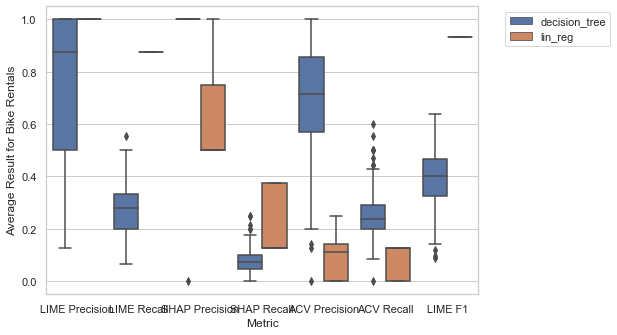

Facebook


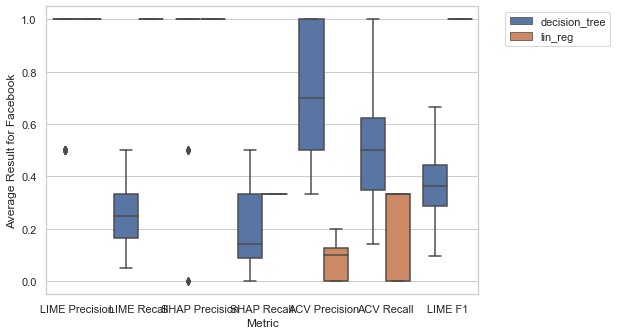

Housing


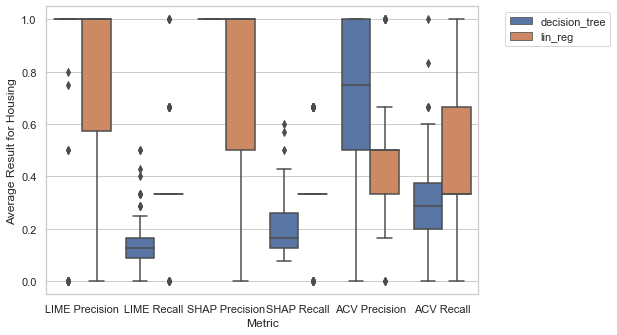

Real Estate


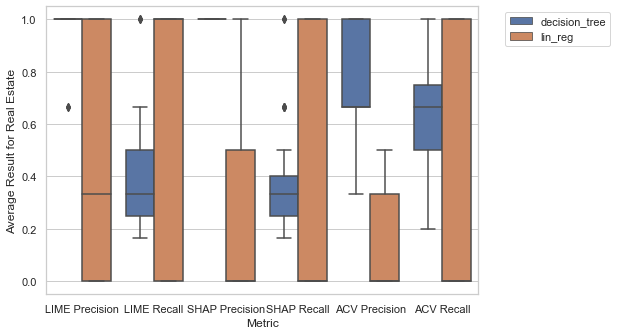

Solar Flare


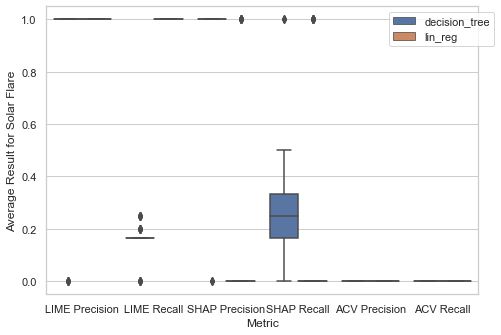

Student Results


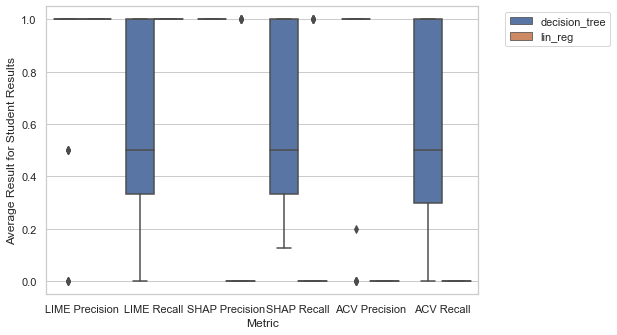

Wine Quality


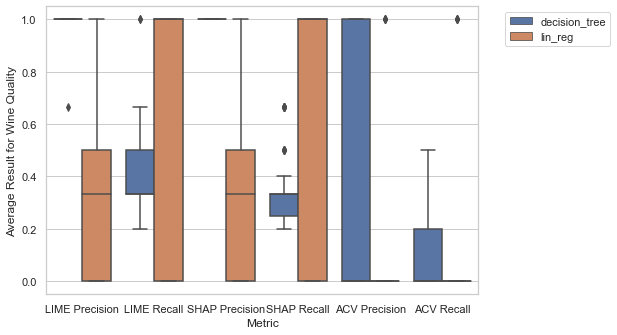

In [32]:
regression_results = reg_results.groupby('Dataset')
sns.set_theme(style="whitegrid")
for index, group in regression_results:
    print(index)
    
    fixed_group = fixed_group = group.drop(["Actual", "Prediction", "MAPE", "R-Squared", "Prediction Type Numeric", 
                                     "Dataset", "Dataset Type"], axis = 1)
    fixed_group = fixed_group.dropna(1)

    res_name = "Average Result for "+index
    data = fixed_group.melt(id_vars = "Model", var_name="Metric", value_name = res_name)

    ax = plt.axes((0,0,1,1))
    sns.boxplot(data = data, x = "Metric", y=res_name, hue="Model")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

('Adult Income', 'decision_tree')


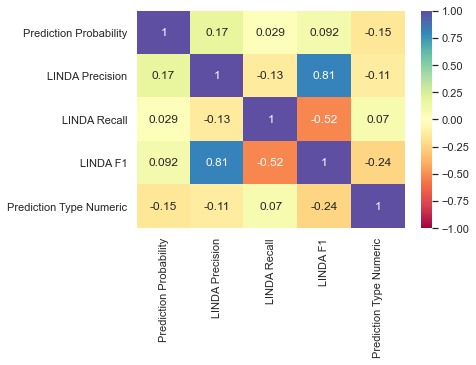

('Adult Income', 'logit')


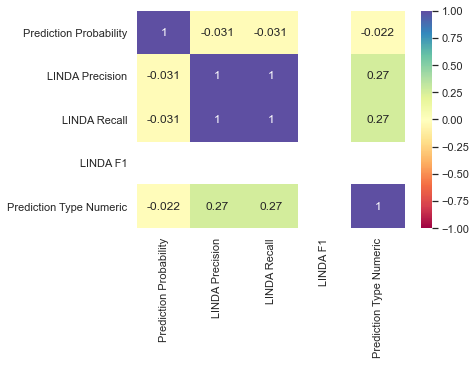

('Adult Income', 'nb')


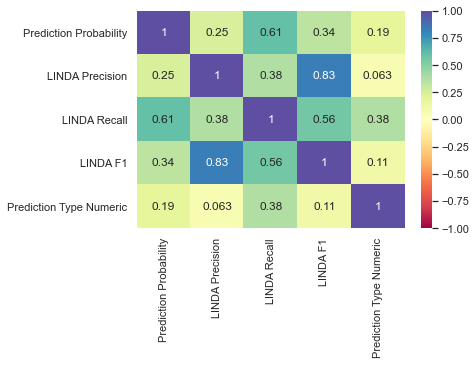

('Breast Cancer', 'decision_tree')


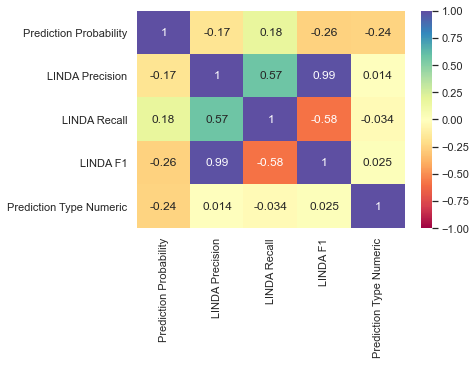

('Breast Cancer', 'logit')


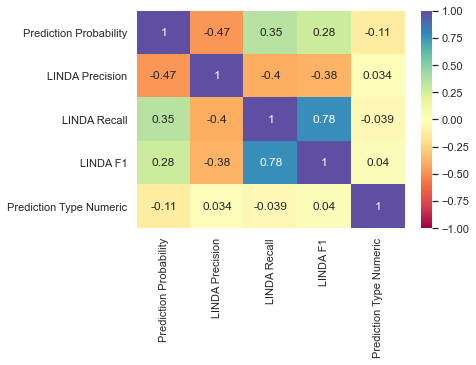

('Breast Cancer', 'nb')


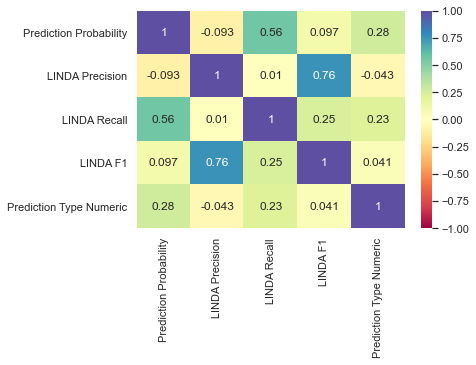

('COMPAS', 'decision_tree')


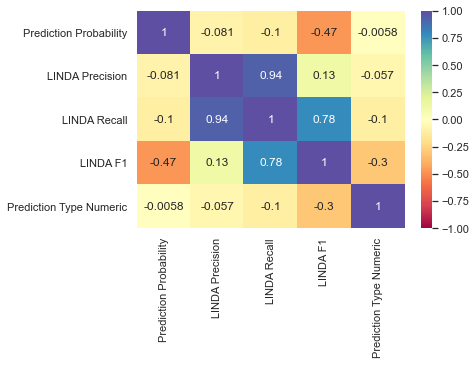

('COMPAS', 'logit')


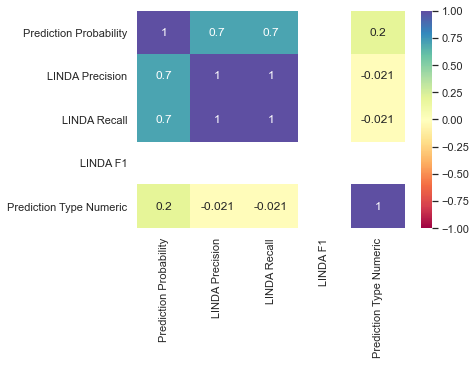

('COMPAS', 'nb')


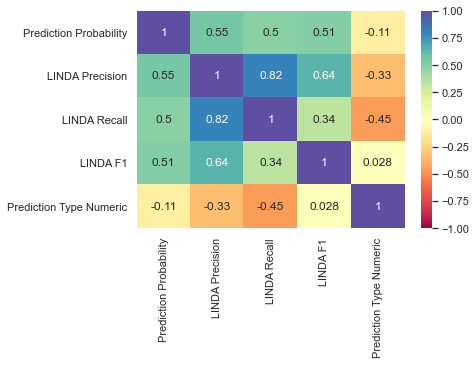

('Diabetes', 'decision_tree')


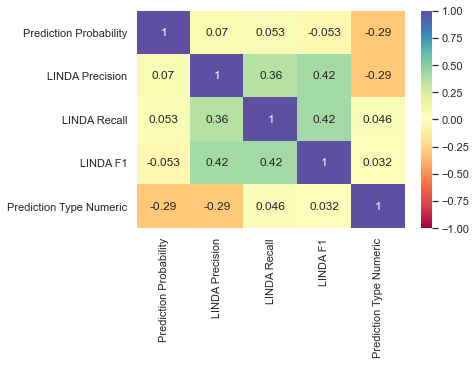

('Diabetes', 'logit')


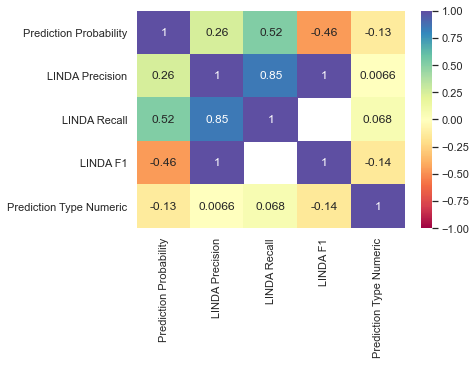

('Diabetes', 'nb')


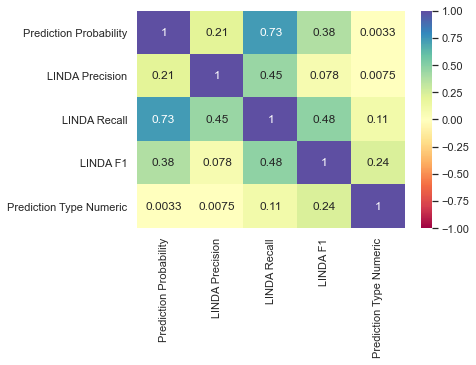

('Iris', 'decision_tree')


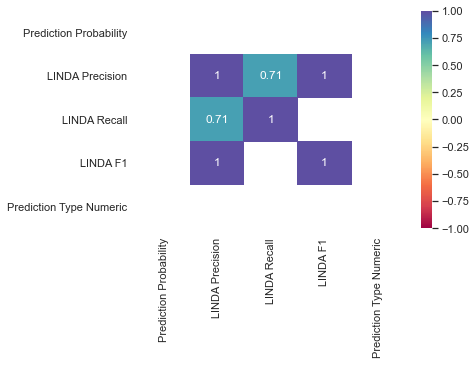

('Iris', 'logit')


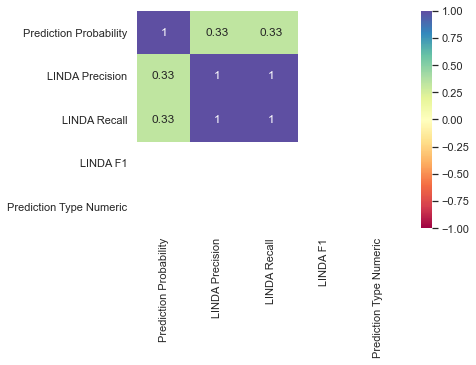

('Iris', 'nb')


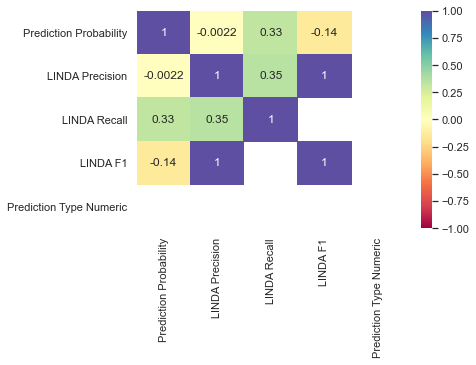

('Mushroom', 'decision_tree')


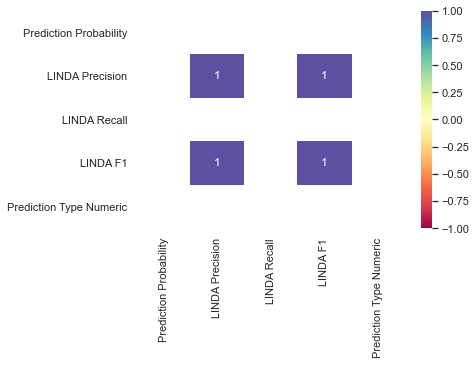

('Mushroom', 'logit')


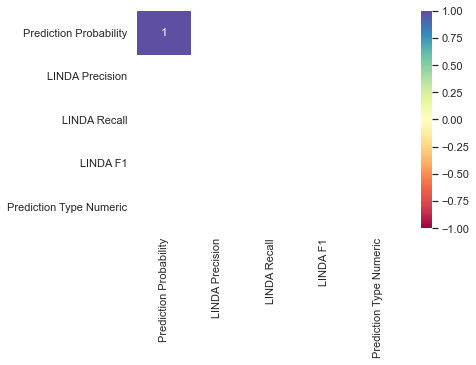

('Mushroom', 'nb')


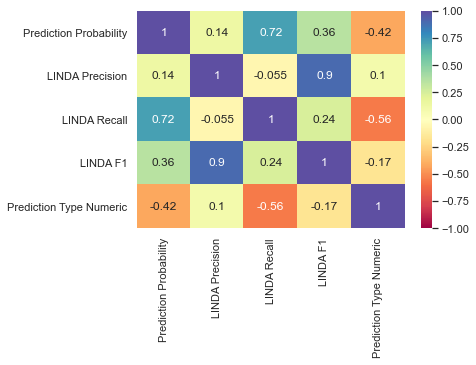

('Nursery', 'decision_tree')


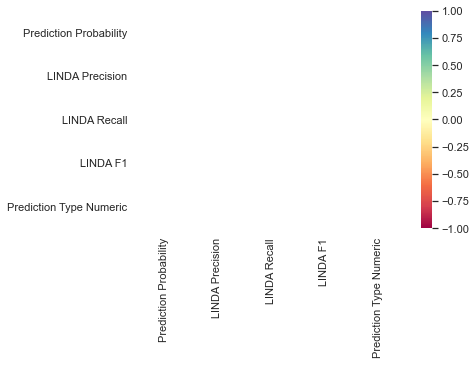

('Nursery', 'logit')


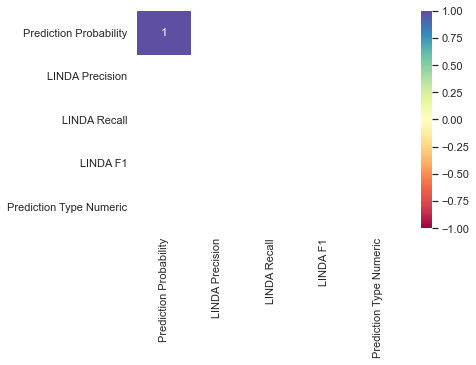

('Nursery', 'nb')


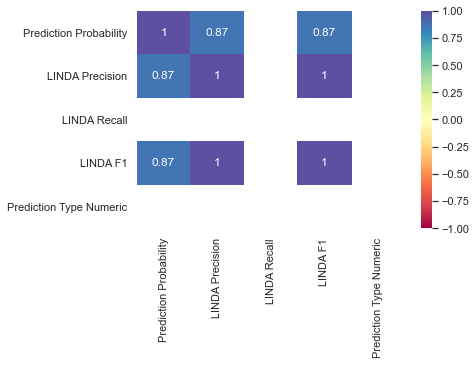

In [142]:
for index, group in cls_results.groupby(['Dataset', 'Model']):
    print(index)
    sns.heatmap(group[['Prediction Probability', 'LINDA Precision', 'LINDA Recall', 
                             'LINDA F1', 'Prediction Type Numeric']].corr("spearman"),
               vmin=-1, vmax=1, annot=True, cmap = "Spectral")
    plt.show()

In [107]:
sns.color_palette("coolwarm", as_cmap=True)

In [126]:
cls_results.columns

Index(['Actual', 'Prediction', 'Prediction Probability', 'SHAP Precision',
       'SHAP Recall', 'LIME Precision', 'LIME Recall', 'LINDA Precision',
       'LINDA Recall', 'ACV Precision', 'ACV Recall', 'Model Accuracy',
       'F1 Score', 'Model', 'Dataset', 'Dataset Type', 'Prediction Type',
       'Prediction Type Numeric', 'SHAP F1', 'LIME F1', 'LINDA F1', 'ACV F1'],
      dtype='object')

------------------------------Regression Results------------------------------


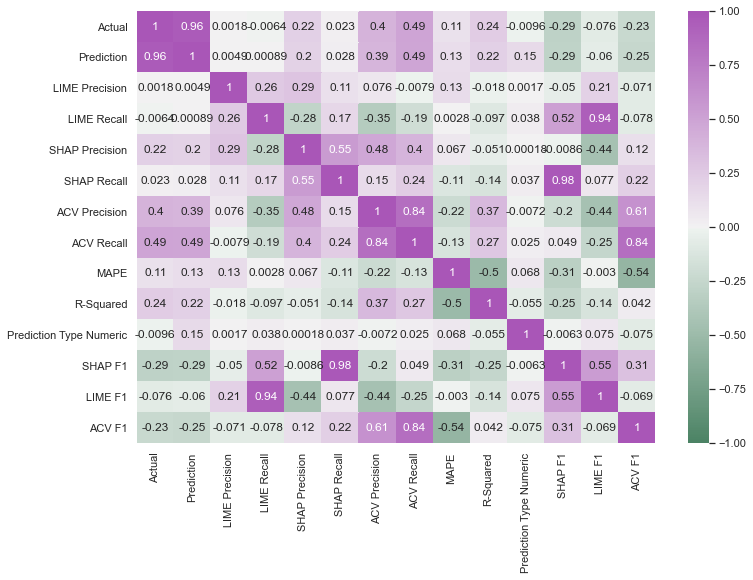

------------------------------Classification Results------------------------------


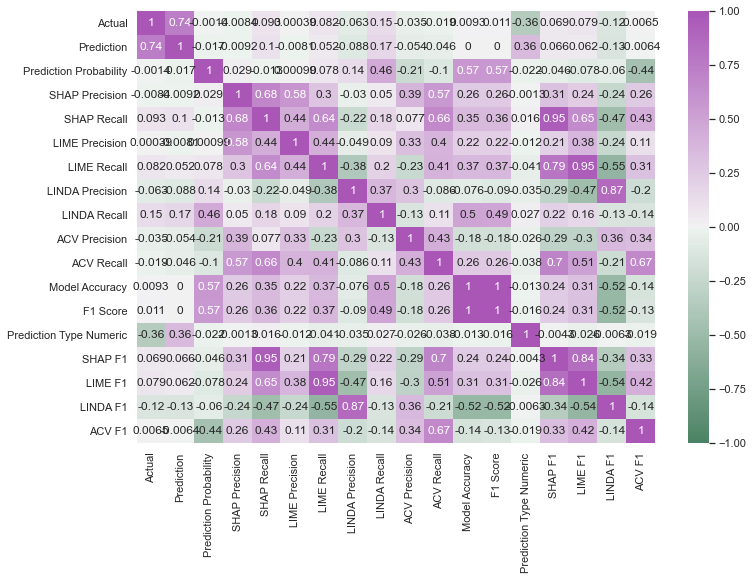

In [33]:
print("------------------------------Regression Results------------------------------")
ax = plt.axes((0,0,1.5,1.5))
sns.heatmap(reg_results.corr("spearman"), vmin=-1, vmax=1, annot=True, cmap=bright_palette,ax=ax)
plt.show()

print("------------------------------Classification Results------------------------------")
ax = plt.axes((0,0,1.5,1.5))
sns.heatmap(cls_results.corr("spearman"), vmin=-1, vmax=1, annot=True, cmap=bright_palette,ax=ax)
plt.show()

------------------------------Regression Aggregate Results------------------------------


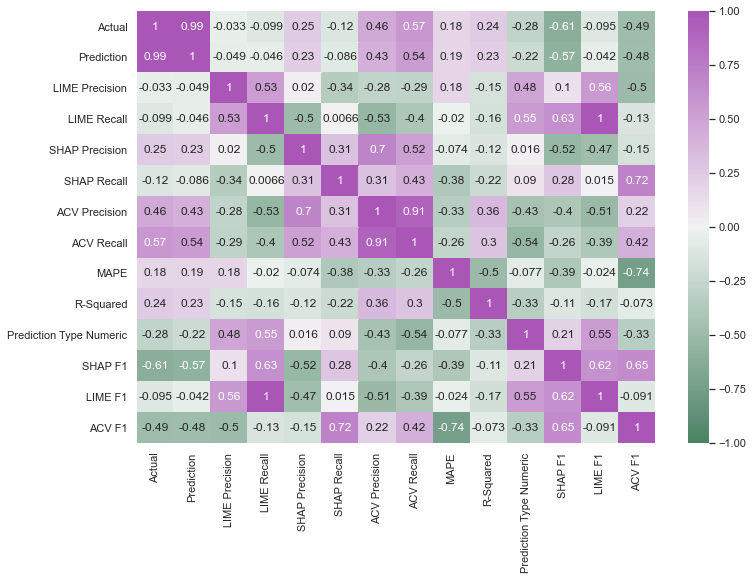

------------------------------Classification Aggregate Results------------------------------


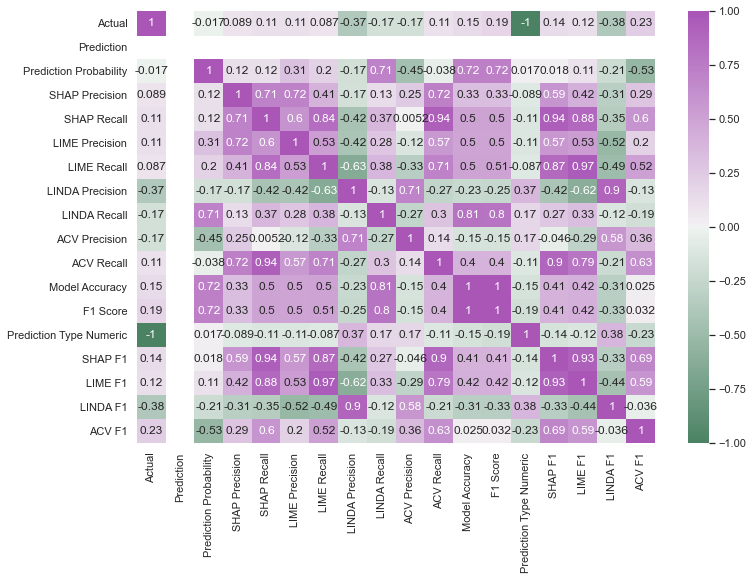

In [34]:
print("------------------------------Regression Aggregate Results------------------------------")
ax = plt.axes((0,0,1.5,1.5))
sns.heatmap(reg_results.groupby(["Model", "Dataset"]).mean().corr("spearman"), vmin=-1, vmax=1, annot=True, cmap=bright_palette,ax=ax)
plt.show()

print("------------------------------Classification Aggregate Results------------------------------")
ax = plt.axes((0,0,1.5,1.5))
sns.heatmap(cls_results.groupby(["Model", "Dataset"]).mean().corr("spearman"), vmin=-1, vmax=1, annot=True, cmap=bright_palette,ax=ax)
plt.show()


In [35]:
print([scipy.stats.shapiro(cls_results[each])[1] for each in cls_recall_columns])
print([scipy.stats.shapiro(cls_results[each])[1] for each in cls_precision_columns])
print([scipy.stats.shapiro(cls_results[each])[1] for each in cls_f1_columns])

print([scipy.stats.shapiro(cls_results[each])[1] for each in reg_recall_columns])
print([scipy.stats.shapiro(cls_results[each])[1] for each in reg_precision_columns])
print([scipy.stats.shapiro(cls_results[each])[1] for each in reg_f1_columns])

[4.2393221799704326e-38, 3.9896368577791867e-41, 0.0, 1.4615542982907842e-42]
[0.0, 0.0, 0.0, 4.036137321811587e-37]
[1.0, 1.0, 1.0, 1.0]
[4.2393221799704326e-38, 3.9896368577791867e-41, 1.4615542982907842e-42]
[0.0, 0.0, 4.036137321811587e-37]
[1.0, 1.0, 1.0]


In [36]:
scipy.stats.shapiro(cls_results["Prediction Probability"])

ShapiroResult(statistic=0.7188808917999268, pvalue=0.0)

In [45]:
print("All results")
for comb in itertools.combinations_with_replacement(cls_recall_columns, 2):
    statistic, pval = scipy.stats.ttest_ind(cls_f1[comb[0]], cls_f1[comb[1]])
    if pval < 0.05:
        pass
#         print("Statisically significant difference between %s and %s" %(comb[0], comb[1]))
#         print("T-test statistic: %.4f \t p-value: %.4f" %(statistic, pval))
    else:
        print("No statistically significant difference between %s and %s" %(comb[0], comb[1]))
        
print("All results")
for comb in itertools.combinations_with_replacement(cls_precision_columns, 2):
    statistic, pval = scipy.stats.ttest_ind(cls_f1[comb[0]], cls_f1[comb[1]])
    if pval < 0.05:
        pass
#         print("Statisically significant difference between %s and %s" %(comb[0], comb[1]))
#         print("T-test statistic: %.4f \t p-value: %.4f" %(statistic, pval))
    else:
        print("No statistically significant difference between %s and %s" %(comb[0], comb[1]))
        
print("All results")
for comb in itertools.combinations_with_replacement(cls_f1_columns, 2):
    statistic, pval = scipy.stats.ttest_ind(cls_f1[comb[0]], cls_f1[comb[1]])
    if pval < 0.05:
        pass
#         print("Statisically significant difference between %s and %s" %(comb[0], comb[1]))
#         print("T-test statistic: %.4f \t p-value: %.4f" %(statistic, pval))
    else:
        print("No statistically significant difference between %s and %s" %(comb[0], comb[1]))
        print(pval)

All results
No statistically significant difference between LIME Recall and LIME Recall
No statistically significant difference between SHAP Recall and SHAP Recall
No statistically significant difference between SHAP Recall and ACV Recall
No statistically significant difference between LINDA Recall and LINDA Recall
No statistically significant difference between ACV Recall and ACV Recall
All results
No statistically significant difference between LIME Precision and LIME Precision
No statistically significant difference between SHAP Precision and SHAP Precision
No statistically significant difference between LINDA Precision and LINDA Precision
No statistically significant difference between ACV Precision and ACV Precision
All results
No statistically significant difference between LIME F1 and LIME F1
1.0
No statistically significant difference between SHAP F1 and SHAP F1
1.0
No statistically significant difference between LINDA F1 and LINDA F1
1.0
No statistically significant difference

In [74]:
method_groups = cls_results.groupby(["Dataset", "Model"])
precision_pval_mats = []
indices = []
for index, group in method_groups:
    
    indices.append(index)
    pval_mat = np.zeros((len(cls_precision_columns), len(cls_precision_columns)))        
    
    for comb in itertools.combinations_with_replacement(cls_precision_columns, 2):
        l1 = cls_precision_columns.index(comb[0])
        l2 = cls_precision_columns.index(comb[1])
        statistic, pval = scipy.stats.ttest_ind(group[comb[0]], group[comb[1]])
        #print(pval)
        pval_mat[l1][l2] = pval
        pval_mat[l2][l1] = pval
    
    precision_pval_mats.append(pval_mat)

method_groups = cls_results.groupby(["Dataset", "Model"])
recall_pval_mats = []
indices = []
for index, group in method_groups:
    
    indices.append(index)
    pval_mat = np.zeros((len(cls_recall_columns), len(cls_recall_columns)))        
    
    for comb in itertools.combinations_with_replacement(cls_recall_columns, 2):
        l1 = cls_recall_columns.index(comb[0])
        l2 = cls_recall_columns.index(comb[1])
        statistic, pval = scipy.stats.ttest_ind(group[comb[0]], group[comb[1]])
        #print(pval)
        pval_mat[l1][l2] = pval
        pval_mat[l2][l1] = pval
    
    recall_pval_mats.append(pval_mat)
            
method_groups = cls_results.groupby(["Dataset", "Model"])
f1_pval_mats = []
#indices = []
for index, group in method_groups:
    pval_mat = np.zeros((len(cls_f1_columns), len(cls_f1_columns)))        
    for comb in itertools.combinations_with_replacement(cls_f1_columns, 2):
        l1 = cls_f1_columns.index(comb[0])
        l2 = cls_f1_columns.index(comb[1])
        statistic, pval = scipy.stats.ttest_ind(group[comb[0]], group[comb[1]])
        pval_mat[l1][l2] = pval
        pval_mat[l2][l1] = pval
        if pval < 0.05:
            pass
#             print("Statisically significant difference between %s and %s" %(comb[0], comb[1]))
#             print("T-test statistic: %.4f \t p-value: %.4f" %(statistic, pval))
        else:
            pass
#             print("%s with %s: No statistically significant difference between %s and %s" 
#                   %(index[0], index[1], comb[0], comb[1]))
#             print("Pval", pval)
    f1_pval_mats.append(pval_mat)

('Adult Income', 'decision_tree')


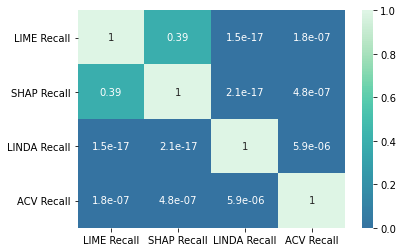

('Adult Income', 'logit')


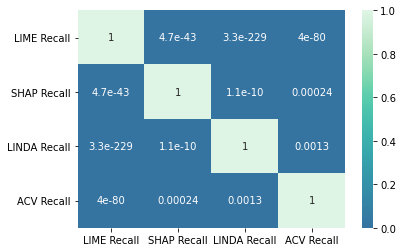

('Adult Income', 'nb')


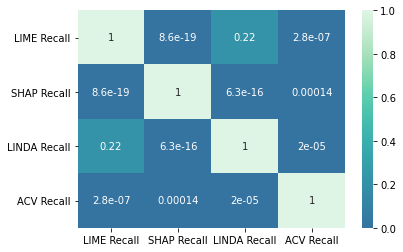

('Breast Cancer', 'decision_tree')


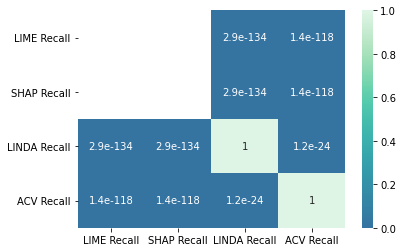

('Breast Cancer', 'logit')


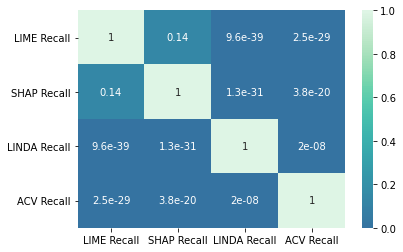

('Breast Cancer', 'nb')


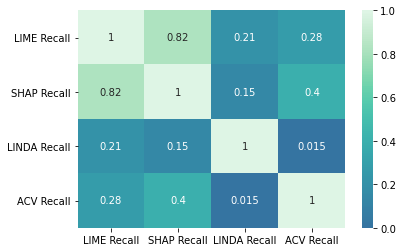

('COMPAS', 'decision_tree')


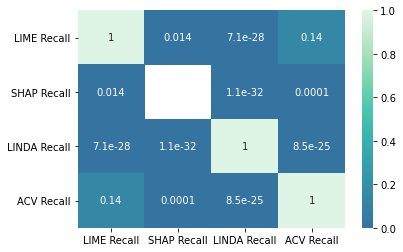

('COMPAS', 'logit')


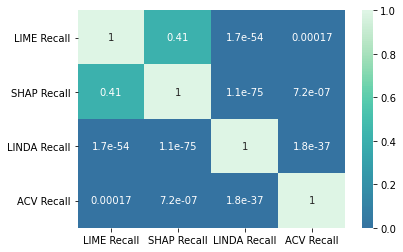

('COMPAS', 'nb')


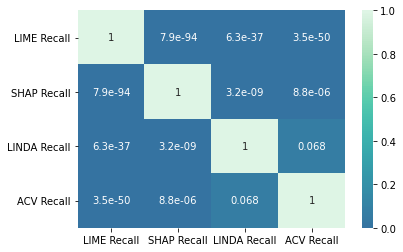

('Diabetes', 'decision_tree')


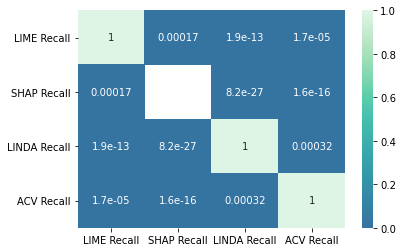

('Diabetes', 'logit')


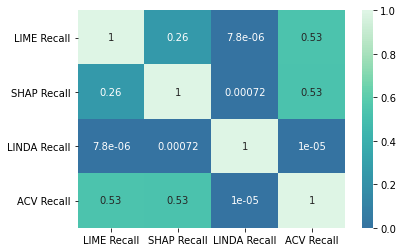

('Diabetes', 'nb')


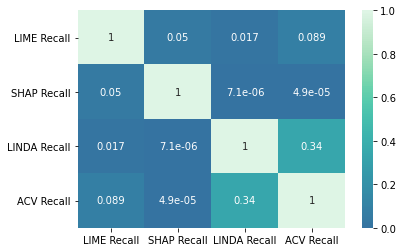

('Iris', 'decision_tree')


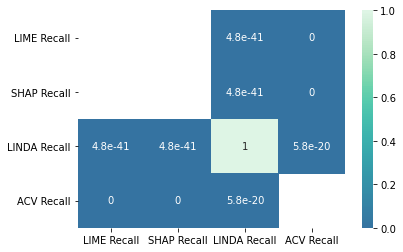

('Iris', 'logit')


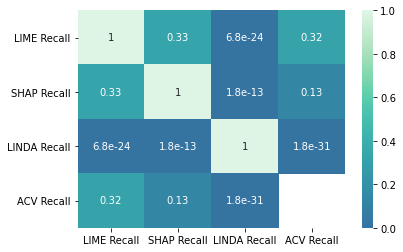

('Iris', 'nb')


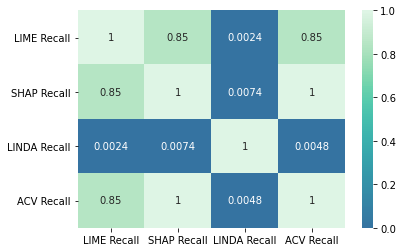

('Mushroom', 'decision_tree')


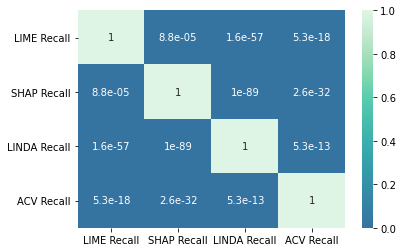

('Mushroom', 'logit')


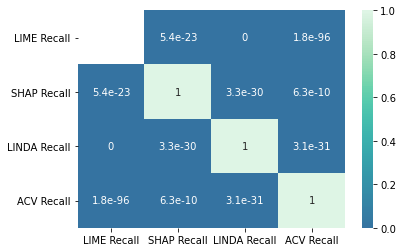

('Mushroom', 'nb')


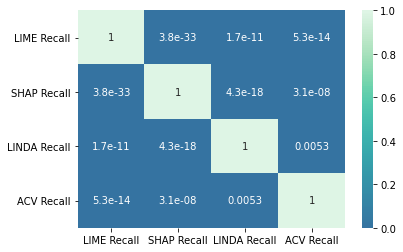

('Nursery', 'decision_tree')


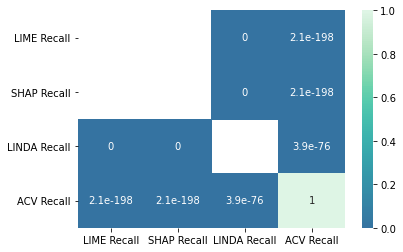

('Nursery', 'logit')


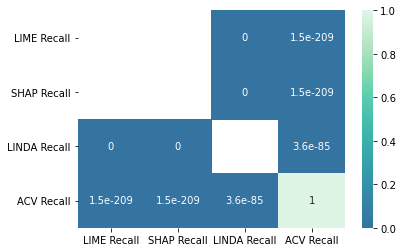

('Nursery', 'nb')


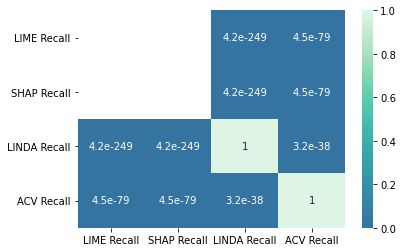

In [75]:
for i in range(len(indices)):
    print(indices[i])
    mat = precision_pval_mats[i]
#    fig, ax = plt.subplots(figsize=(15, 1.5))
    sns.heatmap(mat, vmin=0, vmax=1, annot=True, cmap="mako", center = 0.05, 
                xticklabels=cls_recall_columns, yticklabels=cls_recall_columns)
#    plt.xticks(cls_f1_columns)
#    plt.yticks(cls_f1_columns)
    plt.show()

('Adult Income', 'decision_tree')


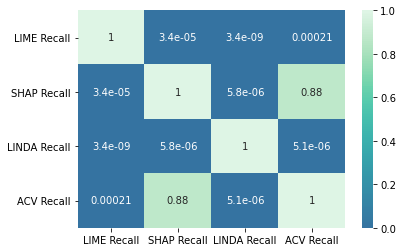

('Adult Income', 'logit')


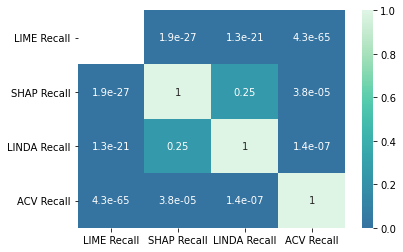

('Adult Income', 'nb')


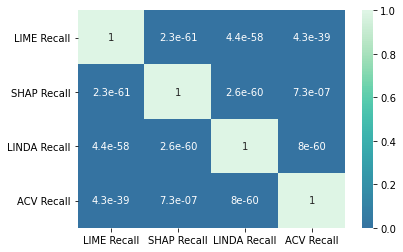

('Breast Cancer', 'decision_tree')


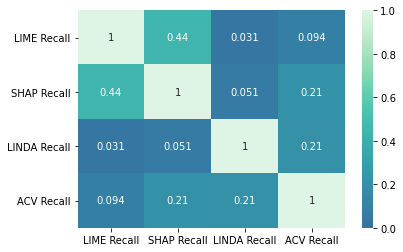

('Breast Cancer', 'logit')


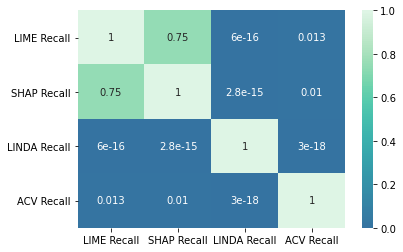

('Breast Cancer', 'nb')


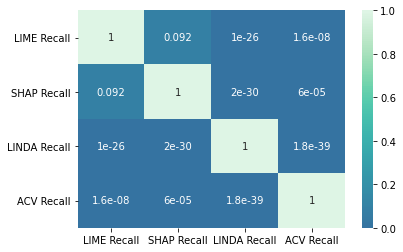

('COMPAS', 'decision_tree')


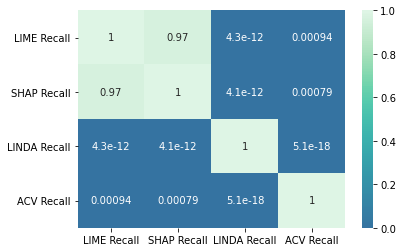

('COMPAS', 'logit')


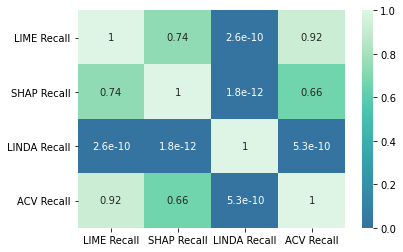

('COMPAS', 'nb')


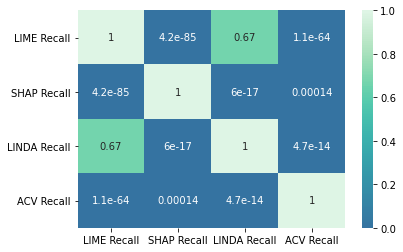

('Diabetes', 'decision_tree')


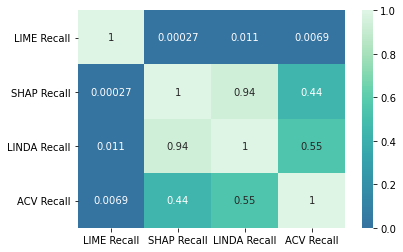

('Diabetes', 'logit')


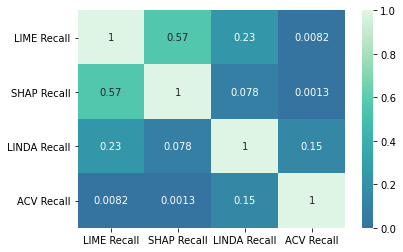

('Diabetes', 'nb')


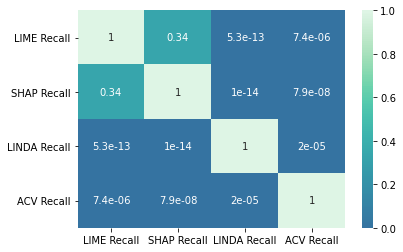

('Iris', 'decision_tree')


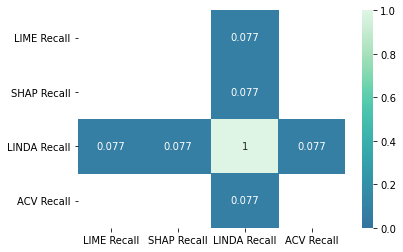

('Iris', 'logit')


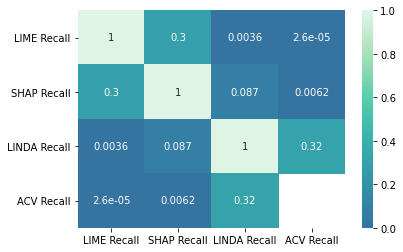

('Iris', 'nb')


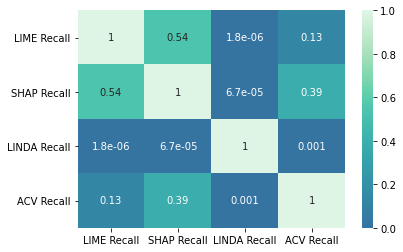

('Mushroom', 'decision_tree')


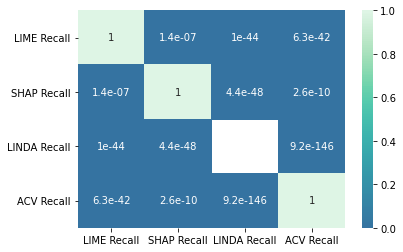

('Mushroom', 'logit')


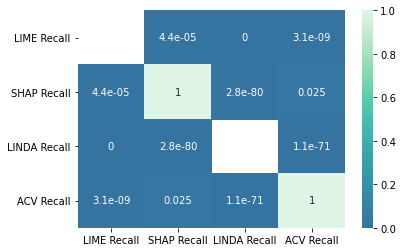

('Mushroom', 'nb')


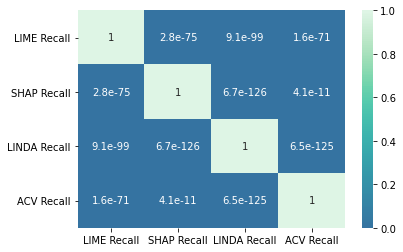

('Nursery', 'decision_tree')


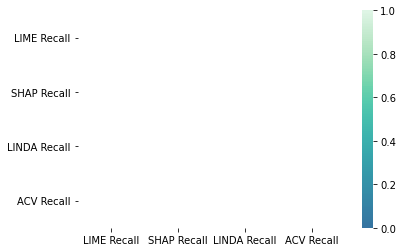

('Nursery', 'logit')


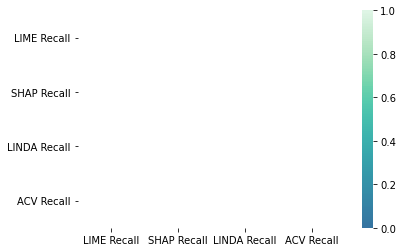

('Nursery', 'nb')


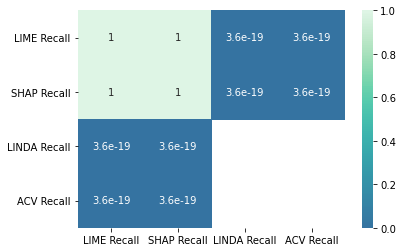

In [71]:
for i in range(len(indices)):
    print(indices[i])
    mat = recall_pval_mats[i]
#    fig, ax = plt.subplots(figsize=(15, 1.5))
    sns.heatmap(mat, vmin=0, vmax=1, annot=True, cmap="mako", center = 0.05, 
                xticklabels=cls_recall_columns, yticklabels=cls_recall_columns)
#    plt.xticks(cls_f1_columns)
#    plt.yticks(cls_f1_columns)
    plt.show()

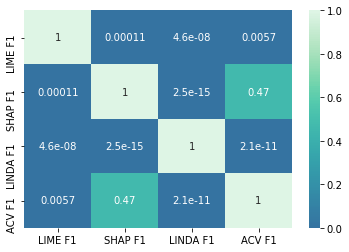

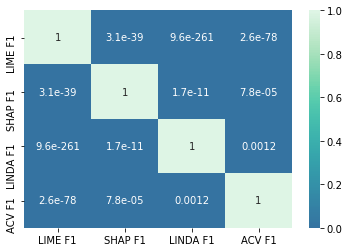

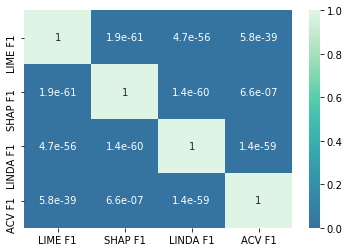

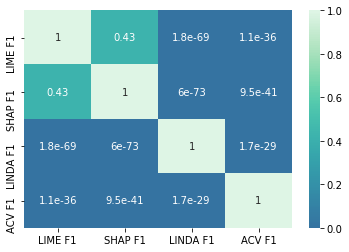

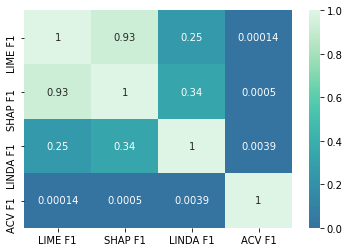

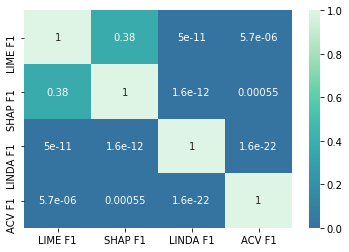

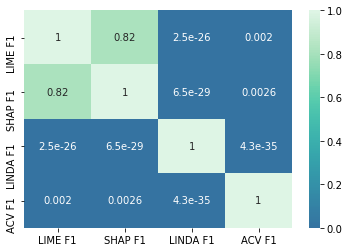

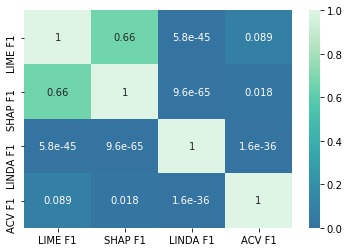

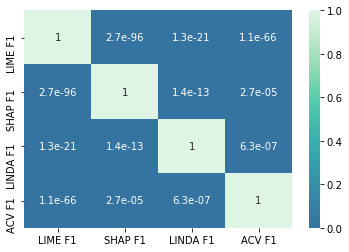

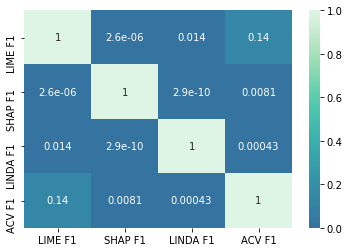

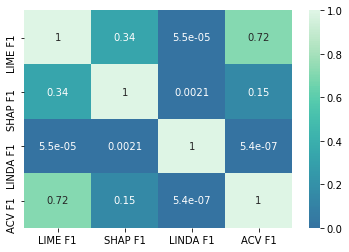

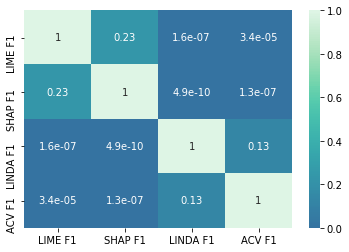

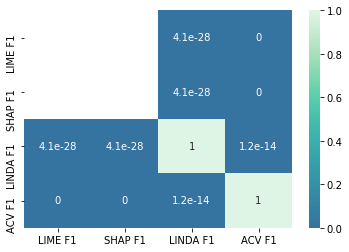

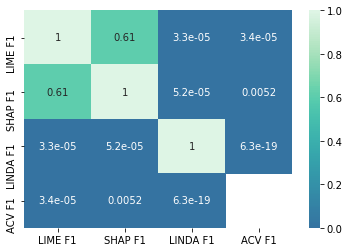

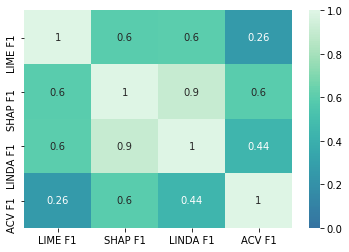

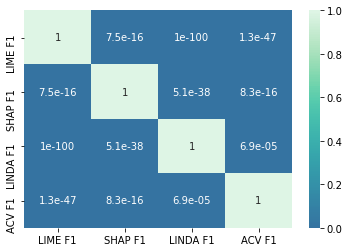

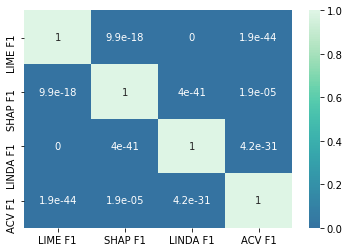

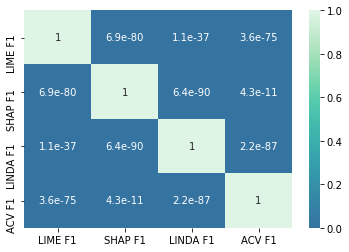

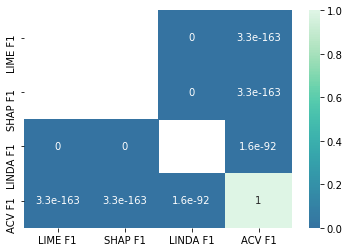

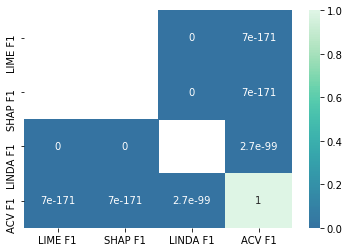

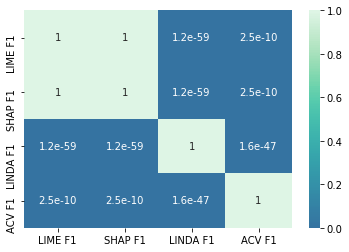

In [72]:
for mat in f1_pval_mats:
#    fig, ax = plt.subplots(figsize=(15, 1.5))
    sns.heatmap(mat, vmin=0, vmax=1, annot=True, cmap="mako", center = 0.05, xticklabels=cls_f1_columns, yticklabels=cls_f1_columns)
#    plt.xticks(cls_f1_columns)
#    plt.yticks(cls_f1_columns)
    plt.show()

In [73]:
for comb in itertools.combinations_with_replacement(reg_recall_columns, 2):
    statistic, pval = scipy.stats.ttest_ind(reg_results[comb[0]], reg_results[comb[1]])
    if pval < 0.05:
        print("Statisically significant difference between %s and %s" %(comb[0], comb[1]))
        print("T-test statistic: %.4f \t p-value: %.4f" %(statistic, pval))
    else:
        print("No statistically significant difference between %s and %s" %(comb[0], comb[1]))
        
for comb in itertools.combinations_with_replacement(reg_precision_columns, 2):
    statistic, pval = scipy.stats.ttest_ind(reg_results[comb[0]], reg_results[comb[1]])
    if pval < 0.05:
        print("Statisically significant difference between %s and %s" %(comb[0], comb[1]))
        print("T-test statistic: %.4f \t p-value: %.4f" %(statistic, pval))
    else:
        print("No statistically significant difference between %s and %s" %(comb[0], comb[1]))
        
for comb in itertools.combinations_with_replacement(reg_f1_columns, 2):
    statistic, pval = scipy.stats.ttest_ind(reg_results[comb[0]], reg_results[comb[1]])
    if pval < 0.05:
        print("Statisically significant difference between %s and %s" %(comb[0], comb[1]))
        print("T-test statistic: %.4f \t p-value: %.4f" %(statistic, pval))
    else:
        print("No statistically significant difference between %s and %s" %(comb[0], comb[1]))
        print(pval)

No statistically significant difference between LIME Recall and LIME Recall
Statisically significant difference between LIME Recall and SHAP Recall
T-test statistic: 18.9540 	 p-value: 0.0000
Statisically significant difference between LIME Recall and ACV Recall
T-test statistic: 22.1467 	 p-value: 0.0000
No statistically significant difference between SHAP Recall and SHAP Recall
Statisically significant difference between SHAP Recall and ACV Recall
T-test statistic: 3.6588 	 p-value: 0.0003
No statistically significant difference between ACV Recall and ACV Recall
No statistically significant difference between LIME Precision and LIME Precision
Statisically significant difference between LIME Precision and SHAP Precision
T-test statistic: 8.6696 	 p-value: 0.0000
Statisically significant difference between LIME Precision and ACV Precision
T-test statistic: 35.5475 	 p-value: 0.0000
No statistically significant difference between SHAP Precision and SHAP Precision
Statisically significan

In [76]:
method_groups = reg_results.groupby(["Dataset", "Model"])
precision_pval_mats = []
indices = []
for index, group in method_groups:
    
    indices.append(index)
    pval_mat = np.zeros((len(reg_precision_columns), len(reg_precision_columns)))        
    
    for comb in itertools.combinations_with_replacement(reg_precision_columns, 2):
        l1 = reg_precision_columns.index(comb[0])
        l2 = reg_precision_columns.index(comb[1])
        statistic, pval = scipy.stats.ttest_ind(group[comb[0]], group[comb[1]])
        #print(pval)
        pval_mat[l1][l2] = pval
        pval_mat[l2][l1] = pval
    
    precision_pval_mats.append(pval_mat)

method_groups = reg_results.groupby(["Dataset", "Model"])
recall_pval_mats = []
indices = []
for index, group in method_groups:
    
    indices.append(index)
    pval_mat = np.zeros((len(reg_recall_columns), len(reg_recall_columns)))        
    
    for comb in itertools.combinations_with_replacement(reg_recall_columns, 2):
        l1 = reg_recall_columns.index(comb[0])
        l2 = reg_recall_columns.index(comb[1])
        statistic, pval = scipy.stats.ttest_ind(group[comb[0]], group[comb[1]])
        #print(pval)
        pval_mat[l1][l2] = pval
        pval_mat[l2][l1] = pval
    
    recall_pval_mats.append(pval_mat)
            
method_groups = reg_results.groupby(["Dataset", "Model"])
f1_pval_mats = []
#indices = []
for index, group in method_groups:
    pval_mat = np.zeros((len(reg_f1_columns), len(reg_f1_columns)))        
    for comb in itertools.combinations_with_replacement(reg_f1_columns, 2):
        l1 = reg_f1_columns.index(comb[0])
        l2 = reg_f1_columns.index(comb[1])
        statistic, pval = scipy.stats.ttest_ind(group[comb[0]], group[comb[1]])
        pval_mat[l1][l2] = pval
        pval_mat[l2][l1] = pval
        if pval < 0.05:
            pass
#             print("Statisically significant difference between %s and %s" %(comb[0], comb[1]))
#             print("T-test statistic: %.4f \t p-value: %.4f" %(statistic, pval))
        else:
            pass
#             print("%s with %s: No statistically significant difference between %s and %s" 
#                   %(index[0], index[1], comb[0], comb[1]))
#             print("Pval", pval)
    f1_pval_mats.append(pval_mat)

('Bike Rentals', 'decision_tree')


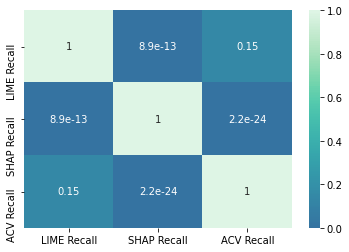

('Bike Rentals', 'lin_reg')


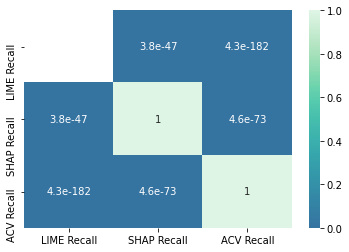

('Facebook', 'decision_tree')


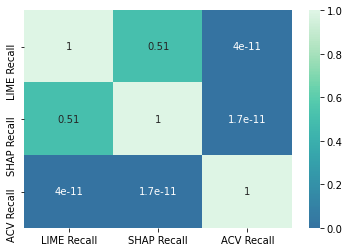

('Facebook', 'lin_reg')


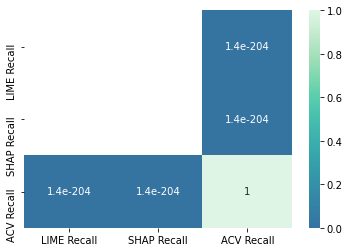

('Housing', 'decision_tree')


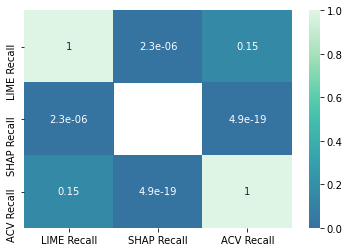

('Housing', 'lin_reg')


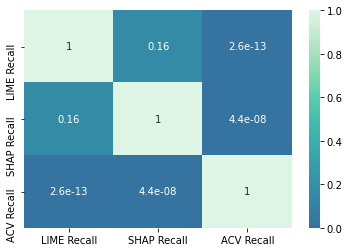

('Real Estate', 'decision_tree')


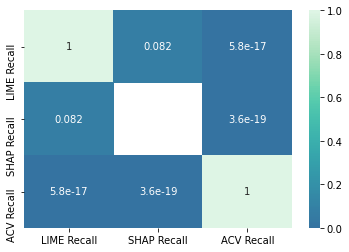

('Real Estate', 'lin_reg')


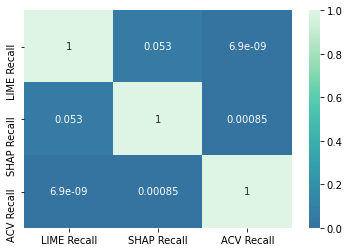

('Solar Flare', 'decision_tree')


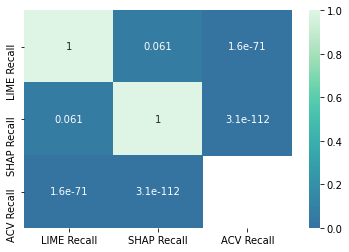

('Solar Flare', 'lin_reg')


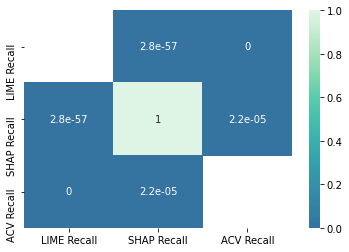

('Student Results', 'decision_tree')


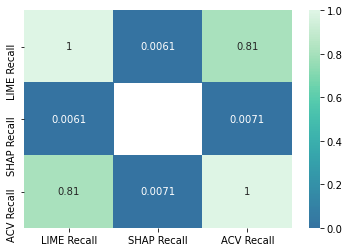

('Student Results', 'lin_reg')


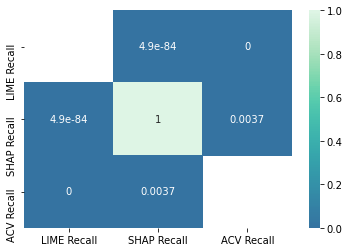

('Wine Quality', 'decision_tree')


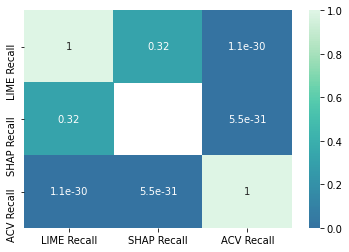

('Wine Quality', 'lin_reg')


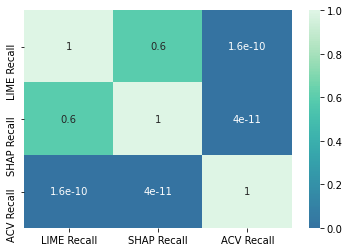

In [78]:
for i in range(len(indices)):
    print(indices[i])
    mat = precision_pval_mats[i]
#    fig, ax = plt.subplots(figsize=(15, 1.5))
    sns.heatmap(mat, vmin=0, vmax=1, annot=True, cmap="mako", center = 0.05, 
                xticklabels=reg_recall_columns, yticklabels=reg_recall_columns)
#    plt.xticks(cls_f1_columns)
#    plt.yticks(cls_f1_columns)
    plt.show()

In [46]:
# #cls_for_friedman = cls_results.dropna(0)
# method_groups = cls_results.groupby(["Dataset","Model"])

# for index,group in method_groups:
    
#     #print(index)
#     #print(group.shape)
    
#     precision_results = group[cls_precision_columns]
#     stat, pval = scipy.stats.friedmanchisquare(*precision_results.values.transpose())
    
#     print("Dataset:{0} \t Model: {1} \nPrecision - Friedman Test statisic: {2}, p-value: {3}".format(index[0], index[1], round(stat, 4), pval))
    
#     #print("Mean results\n", np.mean(precision_results))
    
#     if pval == None or pval == np.nan:
#         print(precision_results.median(1))
    
#     elif pval < 0.05:
#         posthoc = posthoc_nemenyi_friedman(precision_results)
        
#         different = []
        
#         #print(posthoc)
        
#         for col in posthoc.columns:
#             for ind in posthoc.index:
#                 if posthoc.loc[ind,col] < 0.05:
#                     different.append(tuple(sorted([ind,col])))
#         different = set(different)
#         #print(different)
            
#         if different != set():
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05)
#             plt.show()
#         else:
#             print("Posthoc test shows no statistically significant differences")
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
        
#         sns.boxplot(data = precision_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     else:
#         print("No statistically significant difference between results.")
#         print(precision_results.median(0))
        
#         sns.boxplot(data = precision_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     recall_results = group[cls_recall_columns]
#     stat, pval = scipy.stats.friedmanchisquare(*recall_results.values.transpose())
    
#     print("Dataset:{0} \t Model: {1} \nRecall - Friedman Test statisic: {2}, p-value: {3}".format(index[0], index[1], round(stat, 4), pval))
    
#     #print("Mean results\n", np.mean(recall_results))
    
#     if pval == None or pval == np.nan:
#         print("P-val is negligible")
#         print(recall_results.median(1))
        
#     elif pval < 0.05:
#         posthoc = posthoc_nemenyi_friedman(recall_results)
        
#         different = []
        
#         #print(posthoc)
        
#         for col in posthoc.columns:
#             for ind in posthoc.index:
#                 if posthoc.loc[ind,col] < 0.05:
#                     different.append(tuple(sorted([ind,col])))
#         different = set(different)
#         #print(different)
            
#         if different != set():
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
#         else:
#             print("Posthoc test shows no statistically significant differences")
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
        
#         sns.boxplot(data = recall_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     else:
#         print("No statistically significant difference between results.")
#         print(recall_results.median(0))
        
#         sns.boxplot(data = recall_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
#         print(recall_results)
        
        
#     f1_results = group[cls_f1_columns]
#     stat, pval = scipy.stats.friedmanchisquare(*f1_results.values.transpose())
    
#     print("Dataset:{0} \t Model: {1} \nF1 - Friedman Test statisic: {2}, p-value: {3}".format(index[0], index[1], round(stat, 4), pval))
    
#     #print("Mean results\n", np.mean(recall_results))
    
#     if pval == None or pval == np.nan:
#         print("P-val is negligible")
#         print(recall_results.median(1))
        
#     elif pval < 0.05:
#         posthoc = posthoc_nemenyi_friedman(f1_results)
        
#         different = []
        
#         #print(posthoc)
        
#         for col in posthoc.columns:
#             for ind in posthoc.index:
#                 if posthoc.loc[ind,col] < 0.05:
#                     different.append(tuple(sorted([ind,col])))
#         different = set(different)
#         #print(different)
            
#         if different != set():
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
#         else:
#             print("Posthoc test shows no statistically significant differences")
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
        
#         sns.boxplot(data = f1_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     else:
#         print("No statistically significant difference between results.")
#         print(f1_results.median(0))
        
#         sns.boxplot(data = f1_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
#         print(f1_results)

In [47]:
# #cls_for_friedman = cls_results.dropna(0)
# method_groups = cls_results.groupby("Dataset")

# for index,group in method_groups:
    
#     #print(index)
#     #print(group.shape)
    
#     precision_results = group[cls_precision_columns]
#     stat, pval = scipy.stats.friedmanchisquare(*precision_results.values.transpose())
    
#     print("Dataset:{0} \nPrecision - Friedman Test statisic: {1}, p-value: {2}".format(index, round(stat, 4), pval))
    
#     #print("Mean results\n", np.mean(precision_results))
    
#     if pval == None or pval == np.nan:
#         print(precision_results.median(1))
    
#     elif pval < 0.05:
#         posthoc = posthoc_nemenyi_friedman(precision_results)
        
#         different = []
        
#         #print(posthoc)
        
#         for col in posthoc.columns:
#             for ind in posthoc.index:
#                 if posthoc.loc[ind,col] < 0.05:
#                     different.append(tuple(sorted([ind,col])))
#         different = set(different)
#         #print(different)
            
#         if different != set():
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05)
#             plt.show()
#         else:
#             print("Posthoc test shows no statistically significant differences")
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
            
#         sns.boxplot(data = precision_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     else:
#         print("No statistically significant difference between results.")
#         print(precision_results.median(0))
        
#         sns.boxplot(data = precision_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     recall_results = group[cls_recall_columns]
#     stat, pval = scipy.stats.friedmanchisquare(*recall_results.values.transpose())
    
#     print("Dataset:{0} \nRecall - Friedman Test statisic: {1}, p-value: {2}".format(index, round(stat, 4), pval))
    
#     #print("Mean results\n", np.mean(recall_results))
    
#     if pval == None or pval == np.nan:
#         print("P-val is negligible")
#         print(recall_results.median(1))
        
#     elif pval < 0.05:
#         posthoc = posthoc_nemenyi_friedman(recall_results)
        
#         different = []
        
#         #print(posthoc)
        
#         for col in posthoc.columns:
#             for ind in posthoc.index:
#                 if posthoc.loc[ind,col] < 0.05:
#                     different.append(tuple(sorted([ind,col])))
#         different = set(different)
#         #print(different)
            
#         if different != set():
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
#         else:
#             print("Posthoc test shows no statistically significant differences")
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
        
#         sns.boxplot(data = recall_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     else:
#         print("No statistically significant difference between results.")
#         print(recall_results.median(0))
        
#         sns.boxplot(data = recall_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
#         print(recall_results)
        
#     f1_results = group[cls_f1_columns]
#     stat, pval = scipy.stats.friedmanchisquare(*f1_results.values.transpose())
    
#     print("Dataset:{0} \nF1 - Friedman Test statisic: {1}, p-value: {2}".format(index, round(stat, 4), pval))
    
#     #print("Mean results\n", np.mean(recall_results))
    
#     if pval == None or pval == np.nan:
#         print("P-val is negligible")
#         print(recall_results.median(1))
        
#     elif pval < 0.05:
#         posthoc = posthoc_nemenyi_friedman(f1_results)
        
#         different = []
        
#         #print(posthoc)
        
#         for col in posthoc.columns:
#             for ind in posthoc.index:
#                 if posthoc.loc[ind,col] < 0.05:
#                     different.append(tuple(sorted([ind,col])))
#         different = set(different)
#         #print(different)
            
#         if different != set():
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
#         else:
#             print("Posthoc test shows no statistically significant differences")
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
        
#         sns.boxplot(data = f1_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     else:
#         print("No statistically significant difference between results.")
#         print(f1_results.median(0))
        
#         sns.boxplot(data = f1_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
#         print(f1_results)

In [48]:
# #cls_for_friedman = cls_results.dropna(0)
# method_groups = cls_results.groupby("Model")

# for index,group in method_groups:
    
#     #print(index)
#     #print(group.shape)
    
#     precision_results = group[cls_precision_columns]
#     stat, pval = scipy.stats.friedmanchisquare(*precision_results.values.transpose())
    
#     print("Model:{0} \nPrecision - Friedman Test statisic: {1}, p-value: {2}".format(index, round(stat, 4), pval))
    
#     #print("Mean results\n", np.mean(precision_results))
    
#     if pval == None or pval == np.nan:
#         print(precision_results.median(1))
    
#     elif pval < 0.05:
#         posthoc = posthoc_nemenyi_friedman(precision_results)
        
#         different = []
        
#         #print(posthoc)
        
#         for col in posthoc.columns:
#             for ind in posthoc.index:
#                 if posthoc.loc[ind,col] < 0.05:
#                     different.append(tuple(sorted([ind,col])))
#         different = set(different)
#         #print(different)
            
#         if different != set():
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05)
#             plt.show()
#         else:
#             print("Posthoc test shows no statistically significant differences")
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
#         sns.boxplot(data = precision_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     else:
#         print("No statistically significant difference between results.")
#         print(precision_results.median(0))
        
#         sns.boxplot(data = precision_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     recall_results = group[cls_recall_columns]
#     stat, pval = scipy.stats.friedmanchisquare(*recall_results.values.transpose())
    
#     print("Model:{0} \nRecall - Friedman Test statisic: {1}, p-value: {2}".format(index, round(stat, 4), pval))
    
#     #print("Mean results\n", np.mean(recall_results))
    
#     if pval == None or pval == np.nan:
#         print("P-val is negligible")
#         print(recall_results.median(1))
        
#     elif pval < 0.05:
#         posthoc = posthoc_nemenyi_friedman(recall_results)
        
#         different = []
        
#         #print(posthoc)
        
#         for col in posthoc.columns:
#             for ind in posthoc.index:
#                 if posthoc.loc[ind,col] < 0.05:
#                     different.append(tuple(sorted([ind,col])))
#         different = set(different)
#         #print(different)
            
#         if different != set():
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
#         else:
#             print("Posthoc test shows no statistically significant differences")
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
            
#         sns.boxplot(data = recall_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     else:
#         print("No statistically significant difference between results.")
#         print(recall_results.median(0))
        
#         sns.boxplot(data = recall_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
#         print(recall_results)
        
#     f1_results = group[cls_f1_columns]
#     stat, pval = scipy.stats.friedmanchisquare(*f1_results.values.transpose())
    
#     print("Dataset:{0} \nF1 - Friedman Test statisic: {1}, p-value: {2}".format(index, round(stat, 4), pval))
    
#     #print("Mean results\n", np.mean(recall_results))
    
#     if pval == None or pval == np.nan:
#         print("P-val is negligible")
#         print(recall_results.median(1))
        
#     elif pval < 0.05:
#         posthoc = posthoc_nemenyi_friedman(f1_results)
        
#         different = []
        
#         #print(posthoc)
        
#         for col in posthoc.columns:
#             for ind in posthoc.index:
#                 if posthoc.loc[ind,col] < 0.05:
#                     different.append(tuple(sorted([ind,col])))
#         different = set(different)
#         #print(different)
            
#         if different != set():
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
#         else:
#             print("Posthoc test shows no statistically significant differences")
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
        
#         sns.boxplot(data = f1_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     else:
#         print("No statistically significant difference between results.")
#         print(f1_results.median(0))
        
#         sns.boxplot(data = f1_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
#         print(f1_results)

In [49]:
# method_rec_means = cls_results.groupby(["Dataset", "Model"]).mean()[cls_recall_columns]
# stat, pval = scipy.stats.friedmanchisquare(*method_rec_means.values)
# print("Recall - Friedman Test statisic: {0}, p-value: {1}".format(round(stat, 4), pval))
# if pval < 0.05:
#     posthoc = posthoc_nemenyi_friedman(method_rec_means.values)        
#     different = []

#     #print(posthoc)

#     for col in posthoc.columns:
#         for ind in posthoc.index:
#             if posthoc.loc[ind,col] < 0.05:
#                 different.append(tuple(sorted([ind,col])))
#     different = set(different)
#     #print(different)

#     if different != set():
#         ax = plt.axes((0,0,1,1))
#         sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05, 
#                     xticklabels = cls_recall_columns, yticklabels = cls_recall_columns)
#         plt.show()
#     else:
#         print("Posthoc test shows no statistically significant differences")
#         ax = plt.axes((0,0,1,1))
#         sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05, 
#                     xticklabels = cls_recall_columns, yticklabels = cls_recall_columns)
#         plt.show()

#     sns.boxplot(data = method_rec_means.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#     plt.show()
        
# else:
#     print("No statistically significant difference between results.")
#     print(method_rec_means.median(0))

#     sns.boxplot(data = method_rec_means.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#     plt.show()
    
# method_rec_means = cls_results.groupby("Dataset").mean()[cls_recall_columns]
# stat, pval = scipy.stats.friedmanchisquare(*method_rec_means.values)
# print("Recall - Friedman Test statisic: {0}, p-value: {1}".format(round(stat, 4), pval))
# if pval < 0.05:
#     posthoc = posthoc_nemenyi_friedman(method_rec_means.values)        
#     different = []

#     #print(posthoc)

#     for col in posthoc.columns:
#         for ind in posthoc.index:
#             if posthoc.loc[ind,col] < 0.05:
#                 different.append(tuple(sorted([ind,col])))
#     different = set(different)
#     #print(different)

#     if different != set():
#         ax = plt.axes((0,0,1,1))
#         sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05, 
#                     xticklabels = cls_recall_columns, yticklabels = cls_recall_columns)
#         plt.show()
#     else:
#         print("Posthoc test shows no statistically significant differences")
#         ax = plt.axes((0,0,1,1))
#         sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05, 
#                     xticklabels = cls_recall_columns, yticklabels = cls_recall_columns)
#         plt.show()

#     sns.boxplot(data = method_rec_means.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#     plt.show()
        
# else:
#     print("No statistically significant difference between results.")
#     print(method_rec_means.median(0))

#     sns.boxplot(data = method_rec_means.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#     plt.show()
    
# method_rec_means = cls_results.groupby("Model").mean()[cls_recall_columns]
# stat, pval = scipy.stats.friedmanchisquare(*method_rec_means.values)
# print("Recall - Friedman Test statisic: {0}, p-value: {1}".format(round(stat, 4), pval))
# if pval < 0.05:
#     posthoc = posthoc_nemenyi_friedman(method_rec_means.values)        
#     different = []

#     #print(posthoc)

#     for col in posthoc.columns:
#         for ind in posthoc.index:
#             if posthoc.loc[ind,col] < 0.05:
#                 different.append(tuple(sorted([ind,col])))
#     different = set(different)
#     #print(different)

#     if different != set():
#         ax = plt.axes((0,0,1,1))
#         sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05, 
#                     xticklabels = cls_recall_columns, yticklabels = cls_recall_columns)
#         plt.show()
#     else:
#         print("Posthoc test shows no statistically significant differences")
#         ax = plt.axes((0,0,1,1))
#         sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05, 
#                     xticklabels = cls_recall_columns, yticklabels = cls_recall_columns)
#         plt.show()

#     sns.boxplot(data = method_rec_means.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#     plt.show()
        
# else:
#     print("No statistically significant difference between results.")
#     print(method_rec_means.median(0))

#     sns.boxplot(data = method_rec_means.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#     plt.show()

In [50]:
# method_prec_means = cls_results.groupby(["Dataset", "Model"]).mean()[cls_precision_columns]
# stat, pval = scipy.stats.friedmanchisquare(*method_prec_means.values)
# print("Precision - Friedman Test statisic: {0}, p-value: {1}".format(round(stat, 4), pval))
# if pval < 0.05:
#     posthoc = posthoc_nemenyi_friedman(method_prec_means.values)        
#     different = []

#     #print(posthoc)

#     for col in posthoc.columns:
#         for ind in posthoc.index:
#             if posthoc.loc[ind,col] < 0.05:
#                 different.append(tuple(sorted([ind,col])))
#     different = set(different)
#     #print(different)

#     if different != set():
#         ax = plt.axes((0,0,1,1))
#         sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05, 
#                     xticklabels = cls_recall_columns, yticklabels = cls_recall_columns)
#         plt.show()
#     else:
#         print("Posthoc test shows no statistically significant differences")
#         ax = plt.axes((0,0,1,1))
#         sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05, 
#                     xticklabels = cls_recall_columns, yticklabels = cls_recall_columns)
#         plt.show()

#     sns.boxplot(data = method_prec_means.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#     plt.show()
        
# else:
#     print("No statistically significant difference between results.")
#     print(method_prec_means.median(0))

#     sns.boxplot(data = method_prec_means.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#     plt.show()
    
# method_prec_means = cls_results.groupby("Dataset").mean()[cls_precision_columns]
# stat, pval = scipy.stats.friedmanchisquare(*method_prec_means.values)
# print("Precision - Friedman Test statisic: {0}, p-value: {1}".format(round(stat, 4), pval))
# if pval < 0.05:
#     posthoc = posthoc_nemenyi_friedman(method_prec_means.values)        
#     different = []

#     #print(posthoc)

#     for col in posthoc.columns:
#         for ind in posthoc.index:
#             if posthoc.loc[ind,col] < 0.05:
#                 different.append(tuple(sorted([ind,col])))
#     different = set(different)
#     #print(different)

#     if different != set():
#         ax = plt.axes((0,0,1,1))
#         sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05, 
#                     xticklabels = cls_recall_columns, yticklabels = cls_recall_columns)
#         plt.show()
#     else:
#         print("Posthoc test shows no statistically significant differences")
#         ax = plt.axes((0,0,1,1))
#         sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05, 
#                     xticklabels = cls_recall_columns, yticklabels = cls_recall_columns)
#         plt.show()

#     sns.boxplot(data = method_prec_means.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#     plt.show()
        
# else:
#     print("No statistically significant difference between results.")
#     print(method_prec_means.median(0))

#     sns.boxplot(data = method_prec_means.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#     plt.show()
    
# method_prec_means = cls_results.groupby("Model").mean()[cls_precision_columns]
# stat, pval = scipy.stats.friedmanchisquare(*method_prec_means.values)
# print("Precision - Friedman Test statisic: {0}, p-value: {1}".format(round(stat, 4), pval))
# if pval < 0.05:
#     posthoc = posthoc_nemenyi_friedman(method_prec_means.values)        
#     different = []

#     #print(posthoc)

#     for col in posthoc.columns:
#         for ind in posthoc.index:
#             if posthoc.loc[ind,col] < 0.05:
#                 different.append(tuple(sorted([ind,col])))
#     different = set(different)
#     #print(different)

#     if different != set():
#         ax = plt.axes((0,0,1,1))
#         sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05, 
#                     xticklabels = cls_recall_columns, yticklabels = cls_recall_columns)
#         plt.show()
#     else:
#         print("Posthoc test shows no statistically significant differences")
#         ax = plt.axes((0,0,1,1))
#         sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05, 
#                     xticklabels = cls_recall_columns, yticklabels = cls_recall_columns)
#         plt.show()

#     sns.boxplot(data = method_prec_means.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#     plt.show()
        
# else:
#     print("No statistically significant difference between results.")
#     print(method_prec_means.median(0))

#     sns.boxplot(data = method_prec_means.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#     plt.show()

In [51]:
# method_f1_means = cls_results.groupby(["Dataset", "Model"]).mean()[cls_f1_columns]
# stat, pval = scipy.stats.friedmanchisquare(*method_f1_means.values)
# print("Precision - Friedman Test statisic: {0}, p-value: {1}".format(round(stat, 4), pval))
# if pval < 0.05:
#     posthoc = posthoc_nemenyi_friedman(method_f1_means.values)        
#     different = []

#     #print(posthoc)

#     for col in posthoc.columns:
#         for ind in posthoc.index:
#             if posthoc.loc[ind,col] < 0.05:
#                 different.append(tuple(sorted([ind,col])))
#     different = set(different)
#     #print(different)

#     if different != set():
#         ax = plt.axes((0,0,1,1))
#         sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05, 
#                     xticklabels = cls_recall_columns, yticklabels = cls_recall_columns)
#         plt.show()
#     else:
#         print("Posthoc test shows no statistically significant differences")
#         ax = plt.axes((0,0,1,1))
#         sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05, 
#                     xticklabels = cls_recall_columns, yticklabels = cls_recall_columns)
#         plt.show()

#     sns.boxplot(data = method_f1_means.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#     plt.show()
        
# else:
#     print("No statistically significant difference between results.")
#     print(method_f1_means.median(0))

#     sns.boxplot(data = method_f1_means.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#     plt.show()
    
# method_f1_means = cls_results.groupby("Dataset").mean()[cls_f1_columns]
# stat, pval = scipy.stats.friedmanchisquare(*method_f1_means.values)#ranspose())
# print("Precision - Friedman Test statisic: {0}, p-value: {1}".format(round(stat, 4), pval))
# if pval < 0.05:
#     posthoc = posthoc_nemenyi_friedman(method_f1_means.values)        
#     different = []

#     #print(posthoc)

#     for col in posthoc.columns:
#         for ind in posthoc.index:
#             if posthoc.loc[ind,col] < 0.05:
#                 different.append(tuple(sorted([ind,col])))
#     different = set(different)
#     #print(different)

#     if different != set():
#         ax = plt.axes((0,0,1,1))
#         sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05, 
#                     xticklabels = cls_recall_columns, yticklabels = cls_recall_columns)
#         plt.show()
#     else:
#         print("Posthoc test shows no statistically significant differences")
#         ax = plt.axes((0,0,1,1))
#         sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05, 
#                     xticklabels = cls_recall_columns, yticklabels = cls_recall_columns)
#         plt.show()

#     sns.boxplot(data = method_f1_means.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#     plt.show()
        
# else:
#     print("No statistically significant difference between results.")
#     print(method_f1_means.median(0))

#     sns.boxplot(data = method_f1_means.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#     plt.show()
    
# method_f1_means = cls_results.groupby("Model").mean()[cls_f1_columns]
# stat, pval = scipy.stats.friedmanchisquare(*method_f1_means.values)#ranspose())
# print("Precision - Friedman Test statisic: {0}, p-value: {1}".format(round(stat, 4), pval))
# if pval < 0.05:
#     posthoc = posthoc_nemenyi_friedman(method_f1_means.values)        
#     different = []

#     #print(posthoc)

#     for col in posthoc.columns:
#         for ind in posthoc.index:
#             if posthoc.loc[ind,col] < 0.05:
#                 different.append(tuple(sorted([ind,col])))
#     different = set(different)
#     #print(different)

#     if different != set():
#         ax = plt.axes((0,0,1,1))
#         sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05, 
#                     xticklabels = cls_recall_columns, yticklabels = cls_recall_columns)
#         plt.show()
#     else:
#         print("Posthoc test shows no statistically significant differences")
#         ax = plt.axes((0,0,1,1))
#         sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05, 
#                     xticklabels = cls_recall_columns, yticklabels = cls_recall_columns)
#         plt.show()

#     sns.boxplot(data = method_f1_means.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#     plt.show()
        
# else:
#     print("No statistically significant difference between results.")
#     print(method_f1_means.median(0))

#     sns.boxplot(data = method_f1_means.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#     plt.show()

In [ ]:
# #cls_for_friedman = cls_results.dropna(0)
# method_groups = reg_results.groupby(["Dataset","Model"])

# for index,group in method_groups:
    
#     #print(index)
#     #print(group.shape)
    
#     precision_results = group[reg_precision_columns]
#     stat, pval = scipy.stats.friedmanchisquare(*precision_results.values.transpose())
    
#     print("Dataset:{0} \t Model: {1} \nPrecision - Friedman Test statisic: {2}, p-value: {3}".format(index[0], index[1], round(stat, 4), pval))
    
#     #print("Mean results\n", np.mean(precision_results))
    
#     if pval == None or pval == np.nan:
#         print(precision_results.median(1))
    
#     elif pval < 0.05:
#         posthoc = posthoc_nemenyi_friedman(precision_results)
        
#         different = []
        
#         #print(posthoc)
        
#         for col in posthoc.columns:
#             for ind in posthoc.index:
#                 if posthoc.loc[ind,col] < 0.05:
#                     different.append(tuple(sorted([ind,col])))
#         different = set(different)
#         #print(different)
            
#         if different != set():
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05)
#             plt.show()
#         else:
#             print("Posthoc test shows no statistically significant differences")
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
        
#         sns.boxplot(data = precision_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     else:
#         print("No statistically significant difference between results.")
#         print(precision_results.median(0))
        
#         sns.boxplot(data = precision_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     recall_results = group[reg_recall_columns]
#     stat, pval = scipy.stats.friedmanchisquare(*recall_results.values.transpose())
    
#     print("Dataset:{0} \t Model: {1} \nRecall - Friedman Test statisic: {2}, p-value: {3}".format(index[0], index[1], round(stat, 4), pval))
    
#     #print("Mean results\n", np.mean(recall_results))
    
#     if pval == None or pval == np.nan:
#         print("P-val is negligible")
#         print(recall_results.median(1))
        
#     elif pval < 0.05:
#         posthoc = posthoc_nemenyi_friedman(recall_results)
        
#         different = []
        
#         #print(posthoc)
        
#         for col in posthoc.columns:
#             for ind in posthoc.index:
#                 if posthoc.loc[ind,col] < 0.05:
#                     different.append(tuple(sorted([ind,col])))
#         different = set(different)
#         #print(different)
            
#         if different != set():
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
#         else:
#             print("Posthoc test shows no statistically significant differences")
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
        
#         sns.boxplot(data = recall_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     else:
#         print("No statistically significant difference between results.")
#         print(recall_results.median(0))
        
#         sns.boxplot(data = recall_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
#         print(recall_results)

In [ ]:
# #cls_for_friedman = cls_results.dropna(0)
# method_groups = reg_results.groupby("Dataset")

# for index,group in method_groups:
    
#     #print(index)
#     #print(group.shape)
    
#     precision_results = group[reg_precision_columns]
#     stat, pval = scipy.stats.friedmanchisquare(*precision_results.values.transpose())
    
#     print("Dataset:{0} \nPrecision - Friedman Test statisic: {1}, p-value: {2}".format(index, round(stat, 4), pval))
    
#     #print("Mean results\n", np.mean(precision_results))
    
#     if pval == None or pval == np.nan:
#         print(precision_results.median(1))
    
#     elif pval < 0.05:
#         posthoc = posthoc_nemenyi_friedman(precision_results)
        
#         different = []
        
#         #print(posthoc)
        
#         for col in posthoc.columns:
#             for ind in posthoc.index:
#                 if posthoc.loc[ind,col] < 0.05:
#                     different.append(tuple(sorted([ind,col])))
#         different = set(different)
#         #print(different)
            
#         if different != set():
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05)
#             plt.show()
#         else:
#             print("Posthoc test shows no statistically significant differences")
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
            
#         sns.boxplot(data = precision_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     else:
#         print("No statistically significant difference between results.")
#         print(precision_results.median(0))
        
#         sns.boxplot(data = precision_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     recall_results = group[reg_recall_columns]
#     stat, pval = scipy.stats.friedmanchisquare(*recall_results.values.transpose())
    
#     print("Dataset:{0} \nRecall - Friedman Test statisic: {1}, p-value: {2}".format(index, round(stat, 4), pval))
    
#     #print("Mean results\n", np.mean(recall_results))
    
#     if pval == None or pval == np.nan:
#         print("P-val is negligible")
#         print(recall_results.median(1))
        
#     elif pval < 0.05:
#         posthoc = posthoc_nemenyi_friedman(recall_results)
        
#         different = []
        
#         #print(posthoc)
        
#         for col in posthoc.columns:
#             for ind in posthoc.index:
#                 if posthoc.loc[ind,col] < 0.05:
#                     different.append(tuple(sorted([ind,col])))
#         different = set(different)
#         #print(different)
            
#         if different != set():
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
#         else:
#             print("Posthoc test shows no statistically significant differences")
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
            
#         sns.boxplot(data = recall_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
            
#     else:
#         print("No statistically significant difference between results.")
#         print(recall_results.median(0))
        
#         sns.boxplot(data = recall_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
#         print(recall_results)

In [ ]:
# #cls_for_friedman = cls_results.dropna(0)
# method_groups = reg_results.groupby("Model")

# for index,group in method_groups:
    
#     #print(index)
#     #print(group.shape)
    
#     precision_results = group[reg_precision_columns]
#     stat, pval = scipy.stats.friedmanchisquare(*precision_results.values.transpose())
    
#     print("Dataset:{0} \nPrecision - Friedman Test statisic: {1}, p-value: {2}".format(index, round(stat, 4), pval))
    
#     #print("Mean results\n", np.mean(precision_results))
    
#     if pval == None or pval == np.nan:
#         print(precision_results.median(1))
    
#     elif pval < 0.05:
#         posthoc = posthoc_nemenyi_friedman(precision_results)
        
#         different = []
        
#         #print(posthoc)
        
#         for col in posthoc.columns:
#             for ind in posthoc.index:
#                 if posthoc.loc[ind,col] < 0.05:
#                     different.append(tuple(sorted([ind,col])))
#         different = set(different)
#         #print(different)
            
#         if different != set():
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.05)
#             plt.show()
#         else:
#             print("Posthoc test shows no statistically significant differences")
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
            
#         sns.boxplot(data = precision_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     else:
#         print("No statistically significant difference between results.")
#         print(precision_results.median(0))
        
#         sns.boxplot(data = precision_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     recall_results = group[reg_recall_columns]
#     stat, pval = scipy.stats.friedmanchisquare(*recall_results.values.transpose())
    
#     print("Dataset:{0} \nRecall - Friedman Test statisic: {1}, p-value: {2}".format(index, round(stat, 4), pval))
    
#     #print("Mean results\n", np.mean(recall_results))
    
#     if pval == None or pval == np.nan:
#         print("P-val is negligible")
#         print(recall_results.median(1))
        
#     elif pval < 0.05:
#         posthoc = posthoc_nemenyi_friedman(recall_results)
        
#         different = []
        
#         #print(posthoc)
        
#         for col in posthoc.columns:
#             for ind in posthoc.index:
#                 if posthoc.loc[ind,col] < 0.05:
#                     different.append(tuple(sorted([ind,col])))
#         different = set(different)
#         #print(different)
            
#         if different != set():
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
#         else:
#             print("Posthoc test shows no statistically significant differences")
#             ax = plt.axes((0,0,1,1))
#             sns.heatmap(posthoc,  vmin=0, vmax=1, annot=True, cmap="mako",ax=ax, center = 0.0)
#             plt.show()
            
#         sns.boxplot(data = recall_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
        
#     else:
#         print("No statistically significant difference between results.")
#         print(recall_results.median(0))
        
#         sns.boxplot(data = recall_results.melt(var_name = "metric", value_name = "result"), x = "metric", y = "result")
#         plt.show()
#         print(recall_results)

In [ ]:
print("--------------------Classification results by prediction type--------------------")
prediction_groups = cls_results.drop(['Actual','Prediction', "Prediction Type Numeric"], axis=1).groupby("Prediction Type")
for pred_type, group in prediction_groups:
    print(pred_type)
    ax = plt.axes((0,0,1.5,1.5))
    sns.heatmap(group.corr("spearman"),  vmin=-1, vmax=1, annot=True, cmap=bright_palette,ax=ax)
    plt.show()

In [ ]:
print("--------------------Classification aggregate results by prediction type--------------------")
prediction_group_means = cls_results.drop(['Actual','Prediction','Prediction Probability'], axis=1).groupby('Prediction Type').mean()
ax = plt.axes((0,0,1.5,1.5))
sns.heatmap(prediction_group_means.corr("spearman"), vmin=-1, vmax=1, annot=True, cmap=bright_palette,ax=ax)
plt.show()

In [ ]:
data_groups = cls_results.drop(['Actual','Prediction', 'Model Accuracy', 'F1 Score'], axis=1).groupby(["Dataset","Model"])
for data_name, group in data_groups:
    print(data_name)
    ax = plt.axes((0,0,1.5,1.5))
    sns.heatmap(group.corr("spearman"),  vmin=-1, vmax=1, annot=True, cmap=bright_palette,ax=ax)
    plt.show()

In [ ]:
data_groups = reg_results.drop(['Actual','Prediction', 'MAPE', 'R-Squared'], axis=1).groupby(["Dataset","Model"])
for data_name, group in data_groups:
    print(data_name)
    ax = plt.axes((0,0,1.5,1.5))
    sns.heatmap(group.corr("spearman"),  vmin=-1, vmax=1, annot=True, cmap=bright_palette,ax=ax)
    plt.show()

In [ ]:
dataset_means = cls_results.drop(['Actual','Prediction','Prediction Probability'], axis=1).groupby(['Dataset','Model']).mean()
ax = plt.axes((0,0,1.5,1.5))
sns.heatmap(dataset_means.corr("spearman"), vmin=-1, vmax=1, annot=True, cmap=bright_palette,ax=ax)
plt.show()

# ax = plt.axes((0,0,1,1))
# sns.heatmap(dataset_means.corr("pearson"), vmin=-1, vmax=1, annot=True, cmap=bright_palette,ax=ax)
# plt.show()


In [ ]:
dataset_means = reg_results.drop(['Actual','Prediction'], axis=1).groupby(['Dataset','Model']).mean()
ax = plt.axes((0,0,1.5,1.5))
sns.heatmap(dataset_means.corr("spearman"), vmin=-1, vmax=1, annot=True, cmap=bright_palette,ax=ax)
plt.show()

In [ ]:
dataset_means

In [ ]:
for data in datasets:
    data_name = data_names[data]
    
    specific_results = orig_data[orig_data["Dataset"] == data_name]
    
    for method in cls_xai:
        
        print(data_name, ":", method)
        
        ax = plt.axes((0,0,0.75,0.75))
        sns.scatterplot(specific_results["Prediction Probability"], specific_results[method+" Recall"], ax=ax, 
                        hue=specific_results["Prediction"], palette=sns.diverging_palette(145, 300, s=60, n=2))
        plt.show()
        
        ax = plt.axes((0,0,0.75,0.75))
        sns.scatterplot(specific_results["Prediction Probability"], specific_results[method+" Precision"], ax=ax, 
                        hue=specific_results["Prediction"], palette=sns.diverging_palette(145, 300, s=60, n=2))
        plt.show()

In [ ]:
for data in datasets:
    data_name = data_names[data]
    
    specific_results = orig_data[orig_data["Dataset"] == data_name]
    accuracy = specific_results["Model Accuracy"].mean()
    
    specific_results = specific_results.drop(['Actual', 'Prediction', 'Model Accuracy', 'F1 Score'], axis=1)
    dataset_groups = specific_results.groupby("Prediction Type")
    
    print(data_name, "\t", accuracy)
    
    for pred_type, group in dataset_groups:
        print(pred_type)
        ax = plt.axes((0,0,1,1))
        sns.heatmap(group.corr("pearson"),  vmin=-1, vmax=1, annot=True, cmap=bright_palette,ax=ax)
        plt.show()

In [ ]:
data_data = orig_data[orig_data["Dataset"] == "Iris"]
grouped = data_data.groupby("Prediction Type")
for name, group in grouped:
    print(name)

In [ ]:
specific_results.columns

In [ ]:
raise Exception("Done")

# Graph Generation

In [ ]:
datasets = ["diabetes", "breast_cancer", "income", "housing", "student_scores", "bike_sharing"]
classifiers = ["decision_tree", "xgboost"]
data_names = {"breast_cancer":"Breast Cancer", "diabetes":"Diabetes", "income": "Adult Income",
              "housing": "House Prices", "student_scores": "Student Scores", "bike_sharing": "Bike Rentals"}
explainers = ["LIME", "SHAP"]

all_data = pd.DataFrame()

for data in datasets:
    
    for classifier in classifiers:
        results = pd.read_csv(os.path.join(PATH, data, classifier, "results.csv"), sep = ";")
        results["Classifier"] = [classifier]*results.shape[0]
        results["Dataset"] = [data_names[data]]*results.shape[0]
        all_data = all_data.append(results)
        preds = all_data["Prediction"]
        
diabetes_data = all_data[all_data["Dataset"]=="Diabetes"]
cancer_data = all_data[all_data["Dataset"]=="Breast Cancer"]
income_data = all_data[all_data["Dataset"] == data_names['income']]

housing_data = all_data[all_data["Dataset"] == data_names['housing']]
student_data = all_data[all_data["Dataset"] == data_names['student_scores']]
bike_data = all_data[all_data["Dataset"] == data_names['bike_sharing']]

In [ ]:
classification_results = [diabetes_data, cancer_data, income_data]

for each in classification_results:
    preds = each["Prediction"]
    int_preds = [int(pred) for pred in preds]
    each["Prediction"] = int_preds